# Preliminary Analysis of CoronaVirus Time Series Data
In this notebook we will conduct some preliminary analysis and forecasting on the Coronavirus time seires data. For this analysis we will look at forecasting using the data scraper.

**Warning this is a basic analysis/machine learning model. The goal of this notebook is to gage the utility of data augmentation/transfer learning for virus forecasting. NOT provide actionable insights. It would additional rounds of training/validation + verification by epidemiologists and public health experts before I would be confident relying on using it for any actionable insights**

In [0]:
#!git clone https://github.com/CoronaWhy/task-geo.git
#!os.chdir('task-geo')
import pandas as pd
!wget -O coronavirus_timeseries.csv https://coronadatascraper.com/timeseries.csv
!pip install wandb
!wandb login
import wandb
from tensorflow import keras
from wandb.keras import WandbCallback 

In [2]:
df = pd.read_csv("coronavirus_timeseries.csv")
df['month'] = pd.to_datetime(df['date']).map(lambda x: x.month)
df['weekday'] = pd.to_datetime(df['date']).map(lambda x: x.weekday())

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [0]:
unqiue_counties = df['county'].unique()
print(len(unqiue_counties))

2015


We will now construct a list of suitable data at the county level.

In [3]:
def loop_through_geo_codes(df, column='full_county'):
  df_county_list = []
  df['full_county'] = df['state'] + "_" + df['county'] 
  for code in df['full_county'].unique():
    mask = df['full_county'] == code
    df_code = df[mask]
    ts_count = len(df_code)
    if ts_count > 60:
      df_county_list.append(df_code)
  return df_county_list 
county_info = loop_through_geo_codes(df)
print(len(county_info))

38


## Forecasting in Antwerp
We will now piece together some simple tutorial code for forecasting new cases in Antwerp.

In [0]:
antwerp_df = df[df['county']=='Antwerp'].fillna(0)
antwerp_relevant = antwerp_df[['cases', 'deaths', 'recovered', 'population', 'lat', 'long']].values
antwerp_df['new_cases'] = antwerp_df.cases.diff()
print(len(antwerp_df))

98


## Data Augmentation
We will now explore using the tsaug library for forecasting.

In [0]:
!pip install tsaug

In [0]:
from tsaug.visualization import plot 
from tsaug import TimeWarp, Crop, Quantize, Drift, Reverse
my_augmenter = (TimeWarp() * 5, # random time warping 5 times in parallel 
                Crop(size=300),  # random crop subsequences with length 300
                Quantize(n_levels=[10, 20, 30]),  # random quantize to 10-, 20-, or 30- level sets
                Drift(max_drift=(0.1, 0.5)),   # with 80% probability, random drift the signal up to 10% - 50%
                Reverse()) #0.5  # with 50% probability, reverse the sequence)

In [0]:
#X_aug = my_augmenter[0].augment(antwerp_relevant)
print(antwerp_relevant.shape)
X_aug = TimeWarp(antwerp[:70])

## Models and Forecasting
We will now define some simple models in Keras for forecasting.

In [0]:
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import RobustScaler
scaler_dict = {}
config_default = {"epochs":30, "validation_split":0.1, 
          "loss":"mean_squared_error", "optimizer":'adam', 
          "geo_segment":"antwerp", "seq_len":7, "train_steps":70, 
          "test_steps":27, "scaler":"RobustScaler", "new_cases":True, 
          "beta":0.899, "additional_features":["weekday","month"]}
r = RobustScaler()
x_train_full = antwerp_df[['deaths', 'new_cases']][1:config_default["train_steps"]]
x_train_full = pd.DataFrame(r.fit_transform(x_train_full))
y_train_full = x_train_full
r_test = RobustScaler()
test_orig = antwerp_df[['deaths', 'new_cases']][70:]
test = pd.DataFrame(r_test.fit_transform(test_orig))

In [0]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [6]:
sweep_config = {
  "name": "Default sweep",
  "method": "grid",
  "parameters": {
        "batch_size": {
            "values": [2, 3, 4, 5]
        },
        "learn":{
            "values":[0.001, 0.002, 0.004, 0.01]
        },
        "seq_len":{
            "values":[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
        }
    }
}
sweep_id = wandb.sweep(sweep_config, project="covid-forecast")

Create sweep with ID: ib4coca5
Sweep URL: https://app.wandb.ai/igodfried/covid-forecast/sweeps/ib4coca5


In [0]:
import matplotlib.pyplot as plt
def train(x_train_full, y_train_full, test, test_first, scaler, config_default):
  run = wandb.init(project="covid-forecast", config=config_default, magic=True)
  config = wandb.config
  X_train, Y_train = create_dataset(x_train_full, y_train_full, config["seq_len"])
  X_test, y_test = create_dataset(test, test, config["seq_len"])
  opt = keras.optimizers.Adam(learning_rate=config["learn"], beta_1=config["beta"], beta_2=0.999, amsgrad=False)
  model = keras.Sequential()
  model.add(
    keras.layers.Bidirectional(
      keras.layers.LSTM(
        units=128,
        input_shape=(X_train.shape[1], X_train.shape[2])
      )
    )
  ) 
  model.add(keras.layers.Dropout(rate=0.2))
  model.add(keras.layers.Dense(units=2))
  model.compile(loss=config["loss"], optimizer=opt)

  history = model.fit(
      X_train, Y_train,
      epochs=config["epochs"],
      batch_size=config["batch_size"],
      validation_split=config["validation_split"],
      callbacks=[WandbCallback()],
      shuffle=False
  )
  evaluate_single(model, X_test, y_test, scaler)
  evaluate_plot_multi(model, test_first, config, X_test, scaler)
  return model

def evaluate_single(model, x_test, y_test, scaler):
  y_preds = model.predict(x_test)
  y_preds = scaler.inverse_transform(y_preds)
  y_test = scaler.inverse_transform(y_test)
  complete_mse = tf.keras.losses.MSE( y_preds[:, 1], y_test[:, 1])
  wandb.run.summary["test_mse"] = complete_mse
  return complete_mse

def evaluate_plot_multi(model, test_orig, config, x_test, scaler, predictor="new_cases"):
  arr = predict_multi(model, len(test_orig)-config["seq_len"], x_test[0, :, :], config)
  test_orig['predicted_cases'] = 0
  test_orig['predicted_cases'][config["seq_len"]:] = scaler.inverse_transform(arr.squeeze(0))[:, 1]
  plt.plot(test_orig['predicted_cases'], label='predicted_cases')
  plt.plot(test_orig[predictor], label='actual_cases')
  plt.legend();
  wandb.log({"test":plt})
  plt.plot(test_orig['predicted_cases'], label='predicted_cases')
  plt.plot(test_orig[predictor], label='actual_cases')
  plt.legend();
  wandb.Image(plt, caption="Plot")
  large_mse = tf.keras.losses.MSE(
    scaler.inverse_transform(arr.squeeze(0))[:, 1], test_orig[predictor][config["seq_len"]:].values
  )
  wandb.run.summary["test_mse_full"] =  large_mse
  return large_mse

def predict_multi(model, time_steps, start_rows, config):
  start_rows=np.expand_dims(start_rows, axis=0)
  for i in range(0, time_steps):
    out = model.predict(start_rows[:, i:, :])
    out = out[np.newaxis, ...]
    start_rows = np.concatenate((start_rows, out), axis=1)
  return start_rows[:, config["seq_len"]:, :]


In [0]:
wandb.agent(sweep_id, function=train)


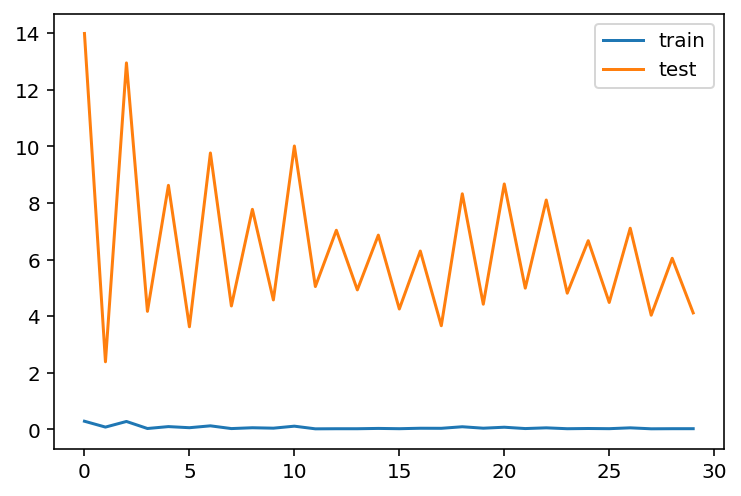

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

### Forecasting on all county levels
Now that we have loooked at Antwerp specifically we will design a general function to work on all geographic counties.

In [0]:
# TODO figure out how to get this into a function. Horrible to use global vars 
#like this. Still waiting on Slack response though.
#def run_geo_sweeps(county_info):
# refactor
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import RobustScaler
def run_geo_sweeps(county_info, start_idx=0, end_idx=1):
  for s in range(start_idx, end_idx):
    county = county_info[s].fillna(0)
    county_name = county['full_county'].values[0]
    config_default = {"epochs":30, "validation_split":0.1, 
            "loss":"mean_squared_error", "optimizer":'adam', 
            "geo_segment":county_name, "seq_len":7, "train_steps":60, 
            "test_steps":27, "scaler":"RobustScaler", "new_cases":True, 
            "beta":0.899, "additional_features":["none"]}
    county['new_cases'] = county.cases.diff()
    r = RobustScaler()
    x_train_full = county[['deaths', 'new_cases']][1:config_default["train_steps"]]
    x_train_full = pd.DataFrame(r.fit_transform(x_train_full))
    y_train_full = x_train_full
    r_test = RobustScaler()
    test_orig = county[['deaths', 'new_cases']][60:]
    test = pd.DataFrame(r_test.fit_transform(test_orig), columns=["deaths", "new_cases"])
    sweep_id = wandb.sweep(sweep_config, project="covid-forecast")
    wandb.agent(sweep_id, lambda:train(x_train_full, y_train_full, test, test_orig, r_test, config_default))


In [0]:
run_geo_sweeps(county_info, 5, 7)

Create sweep with ID: e1disro5
Sweep URL: https://app.wandb.ai/igodfried/covid-forecast/sweeps/e1disro5
wandb: Agent Starting Run: bmhvyacm with config:
	batch_size: 2
	learn: 0.001
	seq_len: 1
wandb: Agent Started Run: bmhvyacm


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

26/26 [==============================] - 1s 34ms/step - loss: 2.5804 - val_loss: 84.3759
Epoch 2/30
26/26 [==============================] - 0s 6ms/step - loss: 2.2704 - val_loss: 75.0432
Epoch 3/30
26/26 [==============================] - 0s 6ms/step - loss: 2.0067 - val_loss: 66.6620
Epoch 4/30
26/26 [==============================] - 0s 6ms/step - loss: 1.7567 - val_loss: 58.4012
Epoch 5/30
26/26 [==============================] - 0s 5ms/step - loss: 1.5512 - val_loss: 50.0217
Epoch 6/30
2

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: bmhvyacm 

wandb: Agent Starting Run: g8hdwnco with config:
	batch_size: 2
	learn: 0.001
	seq_len: 2
wandb: Agent Started Run: g8hdwnco


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

26/26 [==============================] - 1s 34ms/step - loss: 2.5747 - val_loss: 72.6402
Epoch 2/30
26/26 [==============================] - 0s 7ms/step - loss: 1.7608 - val_loss: 52.9064
Epoch 3/30
26/26 [==============================] - 0s 7ms/step - loss: 1.1978 - val_loss: 35.9473
Epoch 4/30
26/26 [==============================] - 0s 7ms/step - loss: 0.8674 - val_loss: 22.7777
Epoch 5/30
26/26 [==============================] - 0s 8ms/step - loss: 0.7515 - val_loss: 15.3278
Epoch 6/30
2

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: g8hdwnco 

wandb: Agent Starting Run: vim91g79 with config:
	batch_size: 2
	learn: 0.001
	seq_len: 3
wandb: Agent Started Run: vim91g79


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

25/25 [==============================] - 1s 35ms/step - loss: 2.3086 - val_loss: 69.6572
Epoch 2/30
25/25 [==============================] - 0s 9ms/step - loss: 1.4546 - val_loss: 41.9180
Epoch 3/30
25/25 [==============================] - 0s 8ms/step - loss: 0.8596 - val_loss: 20.1006
Epoch 4/30
25/25 [==============================] - 0s 7ms/step - loss: 0.7173 - val_loss: 9.3095
Epoch 5/30
25/25 [==============================] - 0s 6ms/step - loss: 0.6641 - val_loss: 9.3845
Epoch 6/30
25/

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: vim91g79 

wandb: Agent Starting Run: tmmwiuvw with config:
	batch_size: 2
	learn: 0.001
	seq_len: 4
wandb: Agent Started Run: tmmwiuvw


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

25/25 [==============================] - 1s 37ms/step - loss: 2.5810 - val_loss: 69.2025
Epoch 2/30
25/25 [==============================] - 0s 10ms/step - loss: 1.3184 - val_loss: 36.0487
Epoch 3/30
25/25 [==============================] - 0s 9ms/step - loss: 0.6663 - val_loss: 14.6064
Epoch 4/30
25/25 [==============================] - 0s 10ms/step - loss: 0.6858 - val_loss: 10.5765
Epoch 5/30
25/25 [==============================] - 0s 8ms/step - loss: 0.5870 - val_loss: 15.6529
Epoch 6/30

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: tmmwiuvw 

wandb: Agent Starting Run: x8hjx1jm with config:
	batch_size: 2
	learn: 0.001
	seq_len: 5
wandb: Agent Started Run: x8hjx1jm


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

24/24 [==============================] - 1s 38ms/step - loss: 2.2203 - val_loss: 60.9305
Epoch 2/30
24/24 [==============================] - 0s 9ms/step - loss: 1.1401 - val_loss: 27.1849
Epoch 3/30
24/24 [==============================] - 0s 11ms/step - loss: 0.6170 - val_loss: 8.4802
Epoch 4/30
24/24 [==============================] - 0s 9ms/step - loss: 0.5609 - val_loss: 8.7766
Epoch 5/30
24/24 [==============================] - 0s 7ms/step - loss: 0.5203 - val_loss: 10.0379
Epoch 6/30
24

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: x8hjx1jm 

wandb: Agent Starting Run: vnpkbat9 with config:
	batch_size: 2
	learn: 0.001
	seq_len: 6
wandb: Agent Started Run: vnpkbat9


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

24/24 [==============================] - 1s 42ms/step - loss: 2.7842 - val_loss: 66.6435
Epoch 2/30
24/24 [==============================] - 0s 11ms/step - loss: 1.3356 - val_loss: 31.4949
Epoch 3/30
24/24 [==============================] - 0s 12ms/step - loss: 0.6817 - val_loss: 12.5958
Epoch 4/30
24/24 [==============================] - 0s 10ms/step - loss: 0.5660 - val_loss: 15.0950
Epoch 5/30
24/24 [==============================] - 0s 9ms/step - loss: 0.6449 - val_loss: 16.0337
Epoch 6/3

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: vnpkbat9 

wandb: Agent Starting Run: wyu7el01 with config:
	batch_size: 2
	learn: 0.001
	seq_len: 7
wandb: Agent Started Run: wyu7el01


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

23/23 [==============================] - 1s 41ms/step - loss: 2.4008 - val_loss: 63.4500
Epoch 2/30
23/23 [==============================] - 0s 11ms/step - loss: 1.0929 - val_loss: 23.0116
Epoch 3/30
23/23 [==============================] - 0s 10ms/step - loss: 0.6990 - val_loss: 6.8500
Epoch 4/30
23/23 [==============================] - 0s 9ms/step - loss: 0.6751 - val_loss: 11.7679
Epoch 5/30
23/23 [==============================] - 0s 10ms/step - loss: 0.6105 - val_loss: 11.3534
Epoch 6/30

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: wyu7el01 

wandb: Agent Starting Run: klolzfni with config:
	batch_size: 2
	learn: 0.001
	seq_len: 8
wandb: Agent Started Run: klolzfni


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

23/23 [==============================] - 1s 44ms/step - loss: 2.4278 - val_loss: 57.1136
Epoch 2/30
23/23 [==============================] - 0s 12ms/step - loss: 0.8277 - val_loss: 17.3969
Epoch 3/30
23/23 [==============================] - 0s 14ms/step - loss: 0.7555 - val_loss: 9.8552
Epoch 4/30
23/23 [==============================] - 0s 11ms/step - loss: 0.7524 - val_loss: 19.2124
Epoch 5/30
23/23 [==============================] - 0s 11ms/step - loss: 0.5765 - val_loss: 13.4201
Epoch 6/3

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: klolzfni 

wandb: Agent Starting Run: abvhx1i3 with config:
	batch_size: 2
	learn: 0.001
	seq_len: 9
wandb: Agent Started Run: abvhx1i3


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

23/23 [==============================] - 1s 47ms/step - loss: 3.8692 - val_loss: 64.3418
Epoch 2/30
23/23 [==============================] - 0s 14ms/step - loss: 1.2391 - val_loss: 21.4433
Epoch 3/30
23/23 [==============================] - 0s 15ms/step - loss: 0.9991 - val_loss: 8.1909
Epoch 4/30
23/23 [==============================] - 0s 11ms/step - loss: 1.3467 - val_loss: 18.8704
Epoch 5/30
23/23 [==============================] - 0s 14ms/step - loss: 0.4972 - val_loss: 9.5043
Epoch 6/30

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: abvhx1i3 

wandb: Agent Starting Run: o6uiwuei with config:
	batch_size: 2
	learn: 0.001
	seq_len: 10
wandb: Agent Started Run: o6uiwuei


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

22/22 [==============================] - 1s 46ms/step - loss: 3.0273 - val_loss: 59.0138
Epoch 2/30
22/22 [==============================] - 0s 13ms/step - loss: 1.1097 - val_loss: 19.5756
Epoch 3/30
22/22 [==============================] - 0s 14ms/step - loss: 0.8499 - val_loss: 8.0046
Epoch 4/30
22/22 [==============================] - 0s 16ms/step - loss: 1.0580 - val_loss: 16.9128
Epoch 5/30
22/22 [==============================] - 0s 13ms/step - loss: 0.5117 - val_loss: 10.0104
Epoch 6/3

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: o6uiwuei 

wandb: Agent Starting Run: 8zpx9j53 with config:
	batch_size: 2
	learn: 0.002
	seq_len: 1
wandb: Agent Started Run: 8zpx9j53


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

26/26 [==============================] - 1s 33ms/step - loss: 2.3185 - val_loss: 74.4887
Epoch 2/30
26/26 [==============================] - 0s 6ms/step - loss: 1.7030 - val_loss: 56.5378
Epoch 3/30
26/26 [==============================] - 0s 6ms/step - loss: 1.2836 - val_loss: 40.9049
Epoch 4/30
26/26 [==============================] - 0s 6ms/step - loss: 0.9269 - val_loss: 27.5129
Epoch 5/30
26/26 [==============================] - 0s 6ms/step - loss: 0.7864 - val_loss: 17.5734
Epoch 6/30
2

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 8zpx9j53 

wandb: Agent Starting Run: ko9fnazd with config:
	batch_size: 2
	learn: 0.002
	seq_len: 2
wandb: Agent Started Run: ko9fnazd


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

26/26 [==============================] - 1s 37ms/step - loss: 2.2512 - val_loss: 59.7682
Epoch 2/30
26/26 [==============================] - 0s 8ms/step - loss: 0.9773 - val_loss: 26.5890
Epoch 3/30
26/26 [==============================] - 0s 8ms/step - loss: 0.6971 - val_loss: 10.1197
Epoch 4/30
26/26 [==============================] - 0s 7ms/step - loss: 0.6820 - val_loss: 12.4516
Epoch 5/30
26/26 [==============================] - 0s 6ms/step - loss: 0.6286 - val_loss: 14.1083
Epoch 6/30
2

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: ko9fnazd 

wandb: Agent Starting Run: mhpao1qn with config:
	batch_size: 2
	learn: 0.002
	seq_len: 3
wandb: Agent Started Run: mhpao1qn


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

25/25 [==============================] - 1s 35ms/step - loss: 1.8783 - val_loss: 49.0183
Epoch 2/30
25/25 [==============================] - 0s 7ms/step - loss: 0.7521 - val_loss: 11.9390
Epoch 3/30
25/25 [==============================] - 0s 7ms/step - loss: 0.6512 - val_loss: 8.6414
Epoch 4/30
25/25 [==============================] - 0s 6ms/step - loss: 0.6714 - val_loss: 11.0562
Epoch 5/30
25/25 [==============================] - 0s 7ms/step - loss: 0.6161 - val_loss: 15.5565
Epoch 6/30
25

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: mhpao1qn 

wandb: Agent Starting Run: xi1d24i0 with config:
	batch_size: 2
	learn: 0.002
	seq_len: 4
wandb: Agent Started Run: xi1d24i0


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

25/25 [==============================] - 1s 38ms/step - loss: 1.9022 - val_loss: 44.6210
Epoch 2/30
25/25 [==============================] - 0s 9ms/step - loss: 0.7493 - val_loss: 7.7612
Epoch 3/30
25/25 [==============================] - 0s 8ms/step - loss: 0.5895 - val_loss: 12.3925
Epoch 4/30
25/25 [==============================] - 0s 10ms/step - loss: 0.5181 - val_loss: 13.7125
Epoch 5/30
25/25 [==============================] - 0s 8ms/step - loss: 0.6382 - val_loss: 16.7341
Epoch 6/30
2

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: xi1d24i0 

wandb: Agent Starting Run: 1232ysop with config:
	batch_size: 2
	learn: 0.002
	seq_len: 5
wandb: Agent Started Run: 1232ysop


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

24/24 [==============================] - 1s 41ms/step - loss: 1.9283 - val_loss: 45.9369
Epoch 2/30
24/24 [==============================] - 0s 9ms/step - loss: 0.6603 - val_loss: 6.7859
Epoch 3/30
24/24 [==============================] - 0s 7ms/step - loss: 0.5810 - val_loss: 11.0464
Epoch 4/30
24/24 [==============================] - 0s 9ms/step - loss: 0.7253 - val_loss: 12.1745
Epoch 5/30
24/24 [==============================] - 0s 8ms/step - loss: 0.7426 - val_loss: 18.2405
Epoch 6/30
24

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 1232ysop 

wandb: Agent Starting Run: xr71dy7u with config:
	batch_size: 2
	learn: 0.002
	seq_len: 6
wandb: Agent Started Run: xr71dy7u


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

24/24 [==============================] - 1s 42ms/step - loss: 1.8467 - val_loss: 38.9467
Epoch 2/30
24/24 [==============================] - 0s 10ms/step - loss: 0.8442 - val_loss: 6.4018
Epoch 3/30
24/24 [==============================] - 0s 11ms/step - loss: 0.6903 - val_loss: 18.1245
Epoch 4/30
24/24 [==============================] - 0s 9ms/step - loss: 0.7361 - val_loss: 15.4972
Epoch 5/30
24/24 [==============================] - 0s 9ms/step - loss: 0.9770 - val_loss: 20.7774
Epoch 6/30


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: xr71dy7u 

wandb: Agent Starting Run: gvfgun1i with config:
	batch_size: 2
	learn: 0.002
	seq_len: 7
wandb: Agent Started Run: gvfgun1i


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

23/23 [==============================] - 1s 43ms/step - loss: 2.1040 - val_loss: 49.5979
Epoch 2/30
23/23 [==============================] - 0s 9ms/step - loss: 0.6848 - val_loss: 8.2281
Epoch 3/30
23/23 [==============================] - 0s 9ms/step - loss: 0.6969 - val_loss: 12.6453
Epoch 4/30
23/23 [==============================] - 0s 10ms/step - loss: 0.8942 - val_loss: 21.8558
Epoch 5/30
23/23 [==============================] - 0s 10ms/step - loss: 0.6355 - val_loss: 13.5061
Epoch 6/30


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: gvfgun1i 

wandb: Agent Starting Run: gzce3ow3 with config:
	batch_size: 2
	learn: 0.002
	seq_len: 8
wandb: Agent Started Run: gzce3ow3


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

23/23 [==============================] - 1s 44ms/step - loss: 2.1080 - val_loss: 39.7240
Epoch 2/30
23/23 [==============================] - 0s 13ms/step - loss: 0.8071 - val_loss: 7.0676
Epoch 3/30
23/23 [==============================] - 0s 13ms/step - loss: 0.5912 - val_loss: 14.0509
Epoch 4/30
23/23 [==============================] - 0s 10ms/step - loss: 0.7692 - val_loss: 14.6061
Epoch 5/30
23/23 [==============================] - 0s 11ms/step - loss: 1.3103 - val_loss: 22.3372
Epoch 6/3

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: gzce3ow3 

wandb: Agent Starting Run: um688i90 with config:
	batch_size: 2
	learn: 0.002
	seq_len: 9
wandb: Agent Started Run: um688i90


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

23/23 [==============================] - 1s 45ms/step - loss: 2.7182 - val_loss: 35.6275
Epoch 2/30
23/23 [==============================] - 0s 14ms/step - loss: 0.8365 - val_loss: 5.9686
Epoch 3/30
23/23 [==============================] - 0s 12ms/step - loss: 1.1646 - val_loss: 14.4278
Epoch 4/30
23/23 [==============================] - 0s 11ms/step - loss: 1.3331 - val_loss: 11.0822
Epoch 5/30
23/23 [==============================] - 0s 12ms/step - loss: 2.5064 - val_loss: 30.5866
Epoch 6/3

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: um688i90 

wandb: Agent Starting Run: t3ilh35x with config:
	batch_size: 2
	learn: 0.002
	seq_len: 10
wandb: Agent Started Run: t3ilh35x


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

22/22 [==============================] - 1s 47ms/step - loss: 2.2701 - val_loss: 33.6590
Epoch 2/30
22/22 [==============================] - 0s 12ms/step - loss: 1.0710 - val_loss: 4.5443
Epoch 3/30
22/22 [==============================] - 0s 11ms/step - loss: 0.6378 - val_loss: 13.5751
Epoch 4/30
22/22 [==============================] - 0s 12ms/step - loss: 0.8151 - val_loss: 8.5279
Epoch 5/30
22/22 [==============================] - 0s 12ms/step - loss: 1.8064 - val_loss: 21.7079
Epoch 6/30

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: t3ilh35x 

wandb: Agent Starting Run: kxqui6oi with config:
	batch_size: 2
	learn: 0.004
	seq_len: 1
wandb: Agent Started Run: kxqui6oi


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

26/26 [==============================] - 1s 34ms/step - loss: 1.9233 - val_loss: 60.0043
Epoch 2/30
26/26 [==============================] - 0s 6ms/step - loss: 0.9992 - val_loss: 28.8147
Epoch 3/30
26/26 [==============================] - 0s 6ms/step - loss: 0.6127 - val_loss: 9.5411
Epoch 4/30
26/26 [==============================] - 0s 6ms/step - loss: 0.5687 - val_loss: 7.6497
Epoch 5/30
26/26 [==============================] - 0s 5ms/step - loss: 0.5714 - val_loss: 8.1018
Epoch 6/30
26/2

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: kxqui6oi 

wandb: Agent Starting Run: z2l0mcf8 with config:
	batch_size: 2
	learn: 0.004
	seq_len: 2
wandb: Agent Started Run: z2l0mcf8


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

26/26 [==============================] - 1s 36ms/step - loss: 1.8275 - val_loss: 46.0426
Epoch 2/30
26/26 [==============================] - 0s 8ms/step - loss: 0.7915 - val_loss: 7.3771
Epoch 3/30
26/26 [==============================] - 0s 6ms/step - loss: 0.6752 - val_loss: 16.7667
Epoch 4/30
26/26 [==============================] - 0s 6ms/step - loss: 0.7616 - val_loss: 18.5929
Epoch 5/30
26/26 [==============================] - 0s 7ms/step - loss: 0.6904 - val_loss: 16.4253
Epoch 6/30
26

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: z2l0mcf8 

wandb: Agent Starting Run: 1g79db6u with config:
	batch_size: 2
	learn: 0.004
	seq_len: 3
wandb: Agent Started Run: 1g79db6u


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

25/25 [==============================] - 1s 37ms/step - loss: 1.4154 - val_loss: 27.6682
Epoch 2/30
25/25 [==============================] - 0s 7ms/step - loss: 1.5100 - val_loss: 2.5690
Epoch 3/30
25/25 [==============================] - 0s 6ms/step - loss: 1.4576 - val_loss: 35.9098
Epoch 4/30
25/25 [==============================] - 0s 6ms/step - loss: 0.6685 - val_loss: 17.6037
Epoch 5/30
25/25 [==============================] - 0s 7ms/step - loss: 0.5843 - val_loss: 11.5077
Epoch 6/30
25

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 1g79db6u 

wandb: Agent Starting Run: dzdfamvg with config:
	batch_size: 2
	learn: 0.004
	seq_len: 4
wandb: Agent Started Run: dzdfamvg


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

25/25 [==============================] - 1s 38ms/step - loss: 1.4411 - val_loss: 23.1492
Epoch 2/30
25/25 [==============================] - 0s 9ms/step - loss: 1.3380 - val_loss: 4.0061
Epoch 3/30
25/25 [==============================] - 0s 8ms/step - loss: 2.0562 - val_loss: 45.8534
Epoch 4/30
25/25 [==============================] - 0s 8ms/step - loss: 0.6414 - val_loss: 16.2901
Epoch 5/30
25/25 [==============================] - 0s 10ms/step - loss: 0.5239 - val_loss: 13.3981
Epoch 6/30
2

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: dzdfamvg 

wandb: Agent Starting Run: 0ebv22go with config:
	batch_size: 2
	learn: 0.004
	seq_len: 5
wandb: Agent Started Run: 0ebv22go


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

24/24 [==============================] - 1s 40ms/step - loss: 1.1316 - val_loss: 15.2192
Epoch 2/30
24/24 [==============================] - 0s 9ms/step - loss: 2.1199 - val_loss: 3.1095
Epoch 3/30
24/24 [==============================] - 0s 7ms/step - loss: 2.7220 - val_loss: 76.6704
Epoch 4/30
24/24 [==============================] - 0s 8ms/step - loss: 1.6416 - val_loss: 45.6995
Epoch 5/30
24/24 [==============================] - 0s 9ms/step - loss: 0.7564 - val_loss: 15.6592
Epoch 6/30
24

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 0ebv22go 

wandb: Agent Starting Run: q1cre89f with config:
	batch_size: 2
	learn: 0.004
	seq_len: 6
wandb: Agent Started Run: q1cre89f


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

24/24 [==============================] - 1s 44ms/step - loss: 1.0716 - val_loss: 11.8753
Epoch 2/30
24/24 [==============================] - 0s 12ms/step - loss: 1.1640 - val_loss: 14.5004
Epoch 3/30
24/24 [==============================] - 0s 10ms/step - loss: 0.6730 - val_loss: 17.0995
Epoch 4/30
24/24 [==============================] - 0s 11ms/step - loss: 0.9330 - val_loss: 23.6616
Epoch 5/30
24/24 [==============================] - 0s 12ms/step - loss: 1.1079 - val_loss: 20.3247
Epoch 6/

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: q1cre89f 

wandb: Agent Starting Run: 5l5rxsn1 with config:
	batch_size: 2
	learn: 0.004
	seq_len: 7
wandb: Agent Started Run: 5l5rxsn1


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

23/23 [==============================] - 1s 47ms/step - loss: 1.2410 - val_loss: 14.9550
Epoch 2/30
23/23 [==============================] - 0s 11ms/step - loss: 3.3948 - val_loss: 4.4227
Epoch 3/30
23/23 [==============================] - 0s 11ms/step - loss: 2.1472 - val_loss: 46.3133
Epoch 4/30
23/23 [==============================] - 0s 13ms/step - loss: 0.9201 - val_loss: 17.7695
Epoch 5/30
23/23 [==============================] - 0s 11ms/step - loss: 0.9217 - val_loss: 9.2723
Epoch 6/30

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 5l5rxsn1 

wandb: Agent Starting Run: 573idnt4 with config:
	batch_size: 2
	learn: 0.004
	seq_len: 8
wandb: Agent Started Run: 573idnt4


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

23/23 [==============================] - 1s 49ms/step - loss: 1.0053 - val_loss: 14.2750
Epoch 2/30
23/23 [==============================] - 0s 15ms/step - loss: 2.2406 - val_loss: 18.0247
Epoch 3/30
23/23 [==============================] - 0s 13ms/step - loss: 0.6272 - val_loss: 13.6604
Epoch 4/30
23/23 [==============================] - 0s 14ms/step - loss: 1.8486 - val_loss: 20.9131
Epoch 5/30
23/23 [==============================] - 0s 12ms/step - loss: 2.6904 - val_loss: 57.0714
Epoch 6/

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 573idnt4 

wandb: Agent Starting Run: 6zhzxtmz with config:
	batch_size: 2
	learn: 0.004
	seq_len: 9
wandb: Agent Started Run: 6zhzxtmz


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

23/23 [==============================] - 1s 49ms/step - loss: 0.9719 - val_loss: 4.7219
Epoch 2/30
23/23 [==============================] - 0s 13ms/step - loss: 2.8254 - val_loss: 6.7839
Epoch 3/30
23/23 [==============================] - 0s 13ms/step - loss: 0.9238 - val_loss: 14.9356
Epoch 4/30
23/23 [==============================] - 0s 13ms/step - loss: 1.7895 - val_loss: 11.9275
Epoch 5/30
23/23 [==============================] - 0s 17ms/step - loss: 3.1865 - val_loss: 36.0160
Epoch 6/30

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 6zhzxtmz 

wandb: Agent Starting Run: 07g6mlq7 with config:
	batch_size: 2
	learn: 0.004
	seq_len: 10
wandb: Agent Started Run: 07g6mlq7


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

22/22 [==============================] - 1s 49ms/step - loss: 1.0037 - val_loss: 9.1496
Epoch 2/30
22/22 [==============================] - 0s 14ms/step - loss: 2.1260 - val_loss: 5.8184
Epoch 3/30
22/22 [==============================] - 0s 15ms/step - loss: 1.4806 - val_loss: 16.0267
Epoch 4/30
22/22 [==============================] - 0s 15ms/step - loss: 2.5401 - val_loss: 37.2536
Epoch 5/30
22/22 [==============================] - 0s 14ms/step - loss: 0.5957 - val_loss: 14.3321
Epoch 6/30

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 07g6mlq7 

wandb: Agent Starting Run: cixqcmbk with config:
	batch_size: 2
	learn: 0.01
	seq_len: 1
wandb: Agent Started Run: cixqcmbk


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

26/26 [==============================] - 1s 34ms/step - loss: 1.4471 - val_loss: 37.5017
Epoch 2/30
26/26 [==============================] - 0s 6ms/step - loss: 0.8995 - val_loss: 2.4141
Epoch 3/30
26/26 [==============================] - 0s 5ms/step - loss: 0.9640 - val_loss: 20.9780
Epoch 4/30
26/26 [==============================] - 0s 5ms/step - loss: 0.7587 - val_loss: 10.3651
Epoch 5/30
26/26 [==============================] - 0s 5ms/step - loss: 0.6009 - val_loss: 12.3025
Epoch 6/30
26

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: cixqcmbk 

wandb: Agent Starting Run: 7de1pjr4 with config:
	batch_size: 2
	learn: 0.01
	seq_len: 2
wandb: Agent Started Run: 7de1pjr4


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

26/26 [==============================] - 1s 37ms/step - loss: 0.9079 - val_loss: 11.8351
Epoch 2/30
26/26 [==============================] - 0s 7ms/step - loss: 0.7210 - val_loss: 16.8945
Epoch 3/30
26/26 [==============================] - 0s 7ms/step - loss: 1.8572 - val_loss: 48.5674
Epoch 4/30
26/26 [==============================] - 0s 7ms/step - loss: 1.1585 - val_loss: 12.7163
Epoch 5/30
26/26 [==============================] - 0s 7ms/step - loss: 2.1571 - val_loss: 54.1324
Epoch 6/30
2

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 7de1pjr4 

wandb: Agent Starting Run: 94mbso61 with config:
	batch_size: 2
	learn: 0.01
	seq_len: 3
wandb: Agent Started Run: 94mbso61


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

25/25 [==============================] - 1s 37ms/step - loss: 0.9169 - val_loss: 5.1294
Epoch 2/30
25/25 [==============================] - 0s 6ms/step - loss: 1.1514 - val_loss: 36.5662
Epoch 3/30
25/25 [==============================] - 0s 7ms/step - loss: 1.2356 - val_loss: 16.3453
Epoch 4/30
25/25 [==============================] - 0s 7ms/step - loss: 1.9542 - val_loss: 55.5292
Epoch 5/30
25/25 [==============================] - 0s 6ms/step - loss: 0.7414 - val_loss: 18.3384
Epoch 6/30
25

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 94mbso61 

wandb: Agent Starting Run: v3g3gnmf with config:
	batch_size: 2
	learn: 0.01
	seq_len: 4
wandb: Agent Started Run: v3g3gnmf


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

25/25 [==============================] - 1s 39ms/step - loss: 0.9270 - val_loss: 4.8825
Epoch 2/30
25/25 [==============================] - 0s 9ms/step - loss: 1.2643 - val_loss: 32.5747
Epoch 3/30
25/25 [==============================] - 0s 9ms/step - loss: 2.0335 - val_loss: 19.6955
Epoch 4/30
25/25 [==============================] - 0s 9ms/step - loss: 1.5968 - val_loss: 35.4622
Epoch 5/30
25/25 [==============================] - 0s 8ms/step - loss: 1.2387 - val_loss: 22.2822
Epoch 6/30
25

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: v3g3gnmf 

wandb: Agent Starting Run: ypjqsqtk with config:
	batch_size: 2
	learn: 0.01
	seq_len: 5
wandb: Agent Started Run: ypjqsqtk


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

24/24 [==============================] - 1s 40ms/step - loss: 0.8444 - val_loss: 10.9375
Epoch 2/30
24/24 [==============================] - 0s 10ms/step - loss: 1.3733 - val_loss: 33.7641
Epoch 3/30
24/24 [==============================] - 0s 9ms/step - loss: 2.3939 - val_loss: 17.4644
Epoch 4/30
24/24 [==============================] - 0s 8ms/step - loss: 1.5906 - val_loss: 42.3934
Epoch 5/30
24/24 [==============================] - 0s 8ms/step - loss: 1.0085 - val_loss: 22.6465
Epoch 6/30


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: ypjqsqtk 

wandb: Agent Starting Run: th57ah77 with config:
	batch_size: 2
	learn: 0.01
	seq_len: 6
wandb: Agent Started Run: th57ah77


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

24/24 [==============================] - 1s 43ms/step - loss: 1.2913 - val_loss: 5.4248
Epoch 2/30
24/24 [==============================] - 0s 10ms/step - loss: 2.1849 - val_loss: 43.1081
Epoch 3/30
24/24 [==============================] - 0s 12ms/step - loss: 3.2760 - val_loss: 30.1664
Epoch 4/30
24/24 [==============================] - 0s 10ms/step - loss: 1.0483 - val_loss: 36.5692
Epoch 5/30
24/24 [==============================] - 0s 10ms/step - loss: 1.2105 - val_loss: 24.2598
Epoch 6/3

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: th57ah77 

wandb: Agent Starting Run: zxlctfjd with config:
	batch_size: 2
	learn: 0.01
	seq_len: 7
wandb: Agent Started Run: zxlctfjd


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

23/23 [==============================] - 1s 43ms/step - loss: 0.9312 - val_loss: 10.6400
Epoch 2/30
23/23 [==============================] - 0s 10ms/step - loss: 2.9569 - val_loss: 36.4824
Epoch 3/30
23/23 [==============================] - 0s 11ms/step - loss: 3.9188 - val_loss: 25.3998
Epoch 4/30
23/23 [==============================] - 0s 11ms/step - loss: 1.3951 - val_loss: 39.9068
Epoch 5/30
23/23 [==============================] - 0s 11ms/step - loss: 1.1480 - val_loss: 17.7442
Epoch 6/

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: zxlctfjd 

wandb: Agent Starting Run: 4zgdf7kv with config:
	batch_size: 2
	learn: 0.01
	seq_len: 8
wandb: Agent Started Run: 4zgdf7kv


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

23/23 [==============================] - 1s 44ms/step - loss: 1.4520 - val_loss: 4.6554
Epoch 2/30
23/23 [==============================] - 0s 12ms/step - loss: 3.6135 - val_loss: 56.9218
Epoch 3/30
23/23 [==============================] - 0s 15ms/step - loss: 1.3203 - val_loss: 18.5119
Epoch 4/30
23/23 [==============================] - 0s 11ms/step - loss: 2.5161 - val_loss: 21.2837
Epoch 5/30
23/23 [==============================] - 0s 13ms/step - loss: 2.0604 - val_loss: 59.9696
Epoch 6/3

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 4zgdf7kv 

wandb: Agent Starting Run: u6awrjql with config:
	batch_size: 2
	learn: 0.01
	seq_len: 9
wandb: Agent Started Run: u6awrjql


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

23/23 [==============================] - 1s 47ms/step - loss: 1.1548 - val_loss: 2.8996
Epoch 2/30
23/23 [==============================] - 0s 13ms/step - loss: 2.3700 - val_loss: 28.3440
Epoch 3/30
23/23 [==============================] - 0s 13ms/step - loss: 1.5683 - val_loss: 19.8387
Epoch 4/30
23/23 [==============================] - 0s 12ms/step - loss: 2.4048 - val_loss: 23.9124
Epoch 5/30
23/23 [==============================] - 0s 13ms/step - loss: 1.1281 - val_loss: 8.2520
Epoch 6/30

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: u6awrjql 

wandb: Agent Starting Run: g5kaubkq with config:
	batch_size: 2
	learn: 0.01
	seq_len: 10
wandb: Agent Started Run: g5kaubkq


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

22/22 [==============================] - 1s 48ms/step - loss: 1.0166 - val_loss: 9.4840
Epoch 2/30
22/22 [==============================] - 0s 11ms/step - loss: 4.5707 - val_loss: 64.6999
Epoch 3/30
22/22 [==============================] - 0s 11ms/step - loss: 1.2288 - val_loss: 11.4763
Epoch 4/30
22/22 [==============================] - 0s 13ms/step - loss: 0.5332 - val_loss: 22.1467
Epoch 5/30
22/22 [==============================] - 0s 12ms/step - loss: 2.0479 - val_loss: 38.6438
Epoch 6/3

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: g5kaubkq 

wandb: Agent Starting Run: nhoeqnun with config:
	batch_size: 3
	learn: 0.001
	seq_len: 1
wandb: Agent Started Run: nhoeqnun


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

18/18 [==============================] - 1s 48ms/step - loss: 3.1597 - val_loss: 86.4055
Epoch 2/30
18/18 [==============================] - 0s 7ms/step - loss: 2.8687 - val_loss: 79.1763
Epoch 3/30
18/18 [==============================] - 0s 9ms/step - loss: 2.5149 - val_loss: 72.3429
Epoch 4/30
18/18 [==============================] - 0s 8ms/step - loss: 2.2659 - val_loss: 65.5716
Epoch 5/30
18/18 [==============================] - 0s 9ms/step - loss: 2.0665 - val_loss: 58.8698
Epoch 6/30
1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: nhoeqnun 

wandb: Agent Starting Run: 062qgzae with config:
	batch_size: 3
	learn: 0.001
	seq_len: 2
wandb: Agent Started Run: 062qgzae


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

17/17 [==============================] - 1s 52ms/step - loss: 2.3972 - val_loss: 77.1571
Epoch 2/30
17/17 [==============================] - 0s 8ms/step - loss: 1.9446 - val_loss: 63.8052
Epoch 3/30
17/17 [==============================] - 0s 9ms/step - loss: 1.5897 - val_loss: 51.6308
Epoch 4/30
17/17 [==============================] - 0s 8ms/step - loss: 1.3289 - val_loss: 39.9200
Epoch 5/30
17/17 [==============================] - 0s 9ms/step - loss: 1.0244 - val_loss: 29.3454
Epoch 6/30
1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 062qgzae 

wandb: Agent Starting Run: 9gvhb4xn with config:
	batch_size: 3
	learn: 0.001
	seq_len: 3
wandb: Agent Started Run: 9gvhb4xn


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

17/17 [==============================] - 1s 52ms/step - loss: 2.9911 - val_loss: 81.0347
Epoch 2/30
17/17 [==============================] - 0s 9ms/step - loss: 2.0385 - val_loss: 58.7548
Epoch 3/30
17/17 [==============================] - 0s 9ms/step - loss: 1.3226 - val_loss: 39.0691
Epoch 4/30
17/17 [==============================] - 0s 11ms/step - loss: 0.9769 - val_loss: 22.5430
Epoch 5/30
17/17 [==============================] - 0s 10ms/step - loss: 0.7372 - val_loss: 13.3091
Epoch 6/30

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 9gvhb4xn 

wandb: Agent Starting Run: 0hjnwvm3 with config:
	batch_size: 3
	learn: 0.001
	seq_len: 4
wandb: Agent Started Run: 0hjnwvm3


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

17/17 [==============================] - 1s 53ms/step - loss: 2.7889 - val_loss: 68.5582
Epoch 2/30
17/17 [==============================] - 0s 10ms/step - loss: 1.7013 - val_loss: 42.8483
Epoch 3/30
17/17 [==============================] - 0s 9ms/step - loss: 0.9512 - val_loss: 21.9514
Epoch 4/30
17/17 [==============================] - 0s 12ms/step - loss: 0.7122 - val_loss: 12.0153
Epoch 5/30
17/17 [==============================] - 0s 11ms/step - loss: 0.6290 - val_loss: 11.4728
Epoch 6/3

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 0hjnwvm3 

wandb: Agent Starting Run: 2f5pn5km with config:
	batch_size: 3
	learn: 0.001
	seq_len: 5
wandb: Agent Started Run: 2f5pn5km


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

16/16 [==============================] - 1s 56ms/step - loss: 2.7364 - val_loss: 79.4467
Epoch 2/30
16/16 [==============================] - 0s 10ms/step - loss: 1.9600 - val_loss: 53.5820
Epoch 3/30
16/16 [==============================] - 0s 10ms/step - loss: 1.2726 - val_loss: 32.2708
Epoch 4/30
16/16 [==============================] - 0s 10ms/step - loss: 0.7528 - val_loss: 16.3564
Epoch 5/30
16/16 [==============================] - 0s 11ms/step - loss: 0.5697 - val_loss: 9.4925
Epoch 6/3

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 2f5pn5km 

wandb: Agent Starting Run: 7fvv8g8p with config:
	batch_size: 3
	learn: 0.001
	seq_len: 6
wandb: Agent Started Run: 7fvv8g8p


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

16/16 [==============================] - 1s 62ms/step - loss: 3.1029 - val_loss: 76.9933
Epoch 2/30
16/16 [==============================] - 0s 12ms/step - loss: 1.8949 - val_loss: 47.3419
Epoch 3/30
16/16 [==============================] - 0s 14ms/step - loss: 0.9873 - val_loss: 23.9094
Epoch 4/30
16/16 [==============================] - 0s 13ms/step - loss: 0.6735 - val_loss: 10.7657
Epoch 5/30
16/16 [==============================] - 0s 10ms/step - loss: 0.6266 - val_loss: 13.6732
Epoch 6/

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 7fvv8g8p 

wandb: Agent Starting Run: wky3auj9 with config:
	batch_size: 3
	learn: 0.001
	seq_len: 7
wandb: Agent Started Run: wky3auj9


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

16/16 [==============================] - 1s 59ms/step - loss: 3.0611 - val_loss: 69.7646
Epoch 2/30
16/16 [==============================] - 0s 13ms/step - loss: 1.6044 - val_loss: 37.3454
Epoch 3/30
16/16 [==============================] - 0s 17ms/step - loss: 0.7322 - val_loss: 16.1292
Epoch 4/30
16/16 [==============================] - 0s 12ms/step - loss: 0.5536 - val_loss: 12.9853
Epoch 5/30
16/16 [==============================] - 0s 11ms/step - loss: 0.6922 - val_loss: 14.3497
Epoch 6/

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: wky3auj9 

wandb: Agent Starting Run: ab32dlmg with config:
	batch_size: 3
	learn: 0.001
	seq_len: 8
wandb: Agent Started Run: ab32dlmg


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

15/15 [==============================] - 1s 62ms/step - loss: 2.6572 - val_loss: 75.8653
Epoch 2/30
15/15 [==============================] - 0s 13ms/step - loss: 1.7806 - val_loss: 44.2114
Epoch 3/30
15/15 [==============================] - 0s 14ms/step - loss: 0.7994 - val_loss: 19.4465
Epoch 4/30
15/15 [==============================] - 0s 14ms/step - loss: 0.6090 - val_loss: 8.8654
Epoch 5/30
15/15 [==============================] - 0s 13ms/step - loss: 0.4904 - val_loss: 12.5651
Epoch 6/3

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: ab32dlmg 

wandb: Agent Starting Run: i8ag83ks with config:
	batch_size: 3
	learn: 0.001
	seq_len: 9
wandb: Agent Started Run: i8ag83ks


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

15/15 [==============================] - 1s 62ms/step - loss: 3.6805 - val_loss: 82.1492
Epoch 2/30
15/15 [==============================] - 0s 13ms/step - loss: 2.0563 - val_loss: 46.0488
Epoch 3/30
15/15 [==============================] - 0s 15ms/step - loss: 0.6410 - val_loss: 18.3131
Epoch 4/30
15/15 [==============================] - 0s 15ms/step - loss: 0.8616 - val_loss: 10.0077
Epoch 5/30
15/15 [==============================] - 0s 15ms/step - loss: 0.7443 - val_loss: 16.6676
Epoch 6/

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: i8ag83ks 

wandb: Agent Starting Run: j8m45cwm with config:
	batch_size: 3
	learn: 0.001
	seq_len: 10
wandb: Agent Started Run: j8m45cwm


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

15/15 [==============================] - 1s 66ms/step - loss: 4.2200 - val_loss: 81.3463
Epoch 2/30
15/15 [==============================] - 0s 17ms/step - loss: 2.2642 - val_loss: 43.2600
Epoch 3/30
15/15 [==============================] - 0s 18ms/step - loss: 0.6767 - val_loss: 16.9772
Epoch 4/30
15/15 [==============================] - 0s 18ms/step - loss: 0.8475 - val_loss: 9.2690
Epoch 5/30
15/15 [==============================] - 0s 14ms/step - loss: 0.8427 - val_loss: 19.7681
Epoch 6/3

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: j8m45cwm 

wandb: Agent Starting Run: ci6951ta with config:
	batch_size: 3
	learn: 0.002
	seq_len: 1
wandb: Agent Started Run: ci6951ta


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

18/18 [==============================] - 1s 49ms/step - loss: 2.8092 - val_loss: 74.9748
Epoch 2/30
18/18 [==============================] - 0s 7ms/step - loss: 2.1399 - val_loss: 59.5522
Epoch 3/30
18/18 [==============================] - 0s 8ms/step - loss: 1.5713 - val_loss: 45.1759
Epoch 4/30
18/18 [==============================] - 0s 8ms/step - loss: 1.1924 - val_loss: 32.5237
Epoch 5/30
18/18 [==============================] - 0s 9ms/step - loss: 0.8384 - val_loss: 22.1605
Epoch 6/30
1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: ci6951ta 

wandb: Agent Starting Run: rbz65hkk with config:
	batch_size: 3
	learn: 0.002
	seq_len: 2
wandb: Agent Started Run: rbz65hkk


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

17/17 [==============================] - 1s 52ms/step - loss: 2.3573 - val_loss: 74.1820
Epoch 2/30
17/17 [==============================] - 0s 8ms/step - loss: 1.5863 - val_loss: 49.0938
Epoch 3/30
17/17 [==============================] - 0s 9ms/step - loss: 1.0300 - val_loss: 28.8739
Epoch 4/30
17/17 [==============================] - 0s 8ms/step - loss: 0.7500 - val_loss: 14.6235
Epoch 5/30
17/17 [==============================] - 0s 8ms/step - loss: 0.7057 - val_loss: 9.4753
Epoch 6/30
17

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: rbz65hkk 

wandb: Agent Starting Run: p0570cyy with config:
	batch_size: 3
	learn: 0.002
	seq_len: 3
wandb: Agent Started Run: p0570cyy


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

17/17 [==============================] - 1s 54ms/step - loss: 2.6165 - val_loss: 69.8127
Epoch 2/30
17/17 [==============================] - 0s 10ms/step - loss: 1.3043 - val_loss: 31.9368
Epoch 3/30
17/17 [==============================] - 0s 9ms/step - loss: 0.6690 - val_loss: 9.3044
Epoch 4/30
17/17 [==============================] - 0s 11ms/step - loss: 0.7347 - val_loss: 8.0202
Epoch 5/30
17/17 [==============================] - 0s 8ms/step - loss: 0.5679 - val_loss: 14.0301
Epoch 6/30
1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: p0570cyy 

wandb: Agent Starting Run: o51k40o5 with config:
	batch_size: 3
	learn: 0.002
	seq_len: 4
wandb: Agent Started Run: o51k40o5


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

17/17 [==============================] - 1s 53ms/step - loss: 2.4185 - val_loss: 57.9553
Epoch 2/30
17/17 [==============================] - 0s 11ms/step - loss: 0.7794 - val_loss: 18.8859
Epoch 3/30
17/17 [==============================] - 0s 10ms/step - loss: 0.8938 - val_loss: 12.7263
Epoch 4/30
17/17 [==============================] - 0s 10ms/step - loss: 0.7435 - val_loss: 23.4431
Epoch 5/30
17/17 [==============================] - 0s 9ms/step - loss: 0.4691 - val_loss: 18.5517
Epoch 6/3

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: o51k40o5 

wandb: Agent Starting Run: ls1u1pu8 with config:
	batch_size: 3
	learn: 0.002
	seq_len: 5
wandb: Agent Started Run: ls1u1pu8


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

16/16 [==============================] - 1s 56ms/step - loss: 2.3441 - val_loss: 65.3254
Epoch 2/30
16/16 [==============================] - 0s 11ms/step - loss: 1.0906 - val_loss: 24.8546
Epoch 3/30
16/16 [==============================] - 0s 11ms/step - loss: 0.6620 - val_loss: 7.3366
Epoch 4/30
16/16 [==============================] - 0s 9ms/step - loss: 0.5577 - val_loss: 10.8638
Epoch 5/30
16/16 [==============================] - 0s 8ms/step - loss: 0.5151 - val_loss: 12.0472
Epoch 6/30


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: ls1u1pu8 

wandb: Agent Starting Run: awn09j4e with config:
	batch_size: 3
	learn: 0.002
	seq_len: 6
wandb: Agent Started Run: awn09j4e


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

16/16 [==============================] - 1s 59ms/step - loss: 2.5023 - val_loss: 57.1276
Epoch 2/30
16/16 [==============================] - 0s 13ms/step - loss: 0.8590 - val_loss: 14.0053
Epoch 3/30
16/16 [==============================] - 0s 13ms/step - loss: 0.9415 - val_loss: 6.1401
Epoch 4/30
16/16 [==============================] - 0s 13ms/step - loss: 0.9301 - val_loss: 19.4015
Epoch 5/30
16/16 [==============================] - 0s 10ms/step - loss: 0.5430 - val_loss: 13.4636
Epoch 6/3

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: awn09j4e 

wandb: Agent Starting Run: cdx1u2wy with config:
	batch_size: 3
	learn: 0.002
	seq_len: 7
wandb: Agent Started Run: cdx1u2wy


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

16/16 [==============================] - 1s 59ms/step - loss: 2.4795 - val_loss: 51.2150
Epoch 2/30
16/16 [==============================] - 0s 13ms/step - loss: 0.6667 - val_loss: 12.1486
Epoch 3/30
16/16 [==============================] - 0s 13ms/step - loss: 0.7528 - val_loss: 14.0352
Epoch 4/30
16/16 [==============================] - 0s 13ms/step - loss: 0.9406 - val_loss: 24.6807
Epoch 5/30
16/16 [==============================] - 0s 12ms/step - loss: 0.6689 - val_loss: 20.8751
Epoch 6/

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: cdx1u2wy 

wandb: Agent Starting Run: 34frudww with config:
	batch_size: 3
	learn: 0.002
	seq_len: 8
wandb: Agent Started Run: 34frudww


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

15/15 [==============================] - 1s 62ms/step - loss: 2.3376 - val_loss: 57.4488
Epoch 2/30
15/15 [==============================] - 0s 13ms/step - loss: 0.7375 - val_loss: 17.2295
Epoch 3/30
15/15 [==============================] - 0s 13ms/step - loss: 1.1057 - val_loss: 8.5393
Epoch 4/30
15/15 [==============================] - 0s 11ms/step - loss: 1.5492 - val_loss: 33.7092
Epoch 5/30
15/15 [==============================] - 0s 11ms/step - loss: 1.0695 - val_loss: 25.5425
Epoch 6/3

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 34frudww 

wandb: Agent Starting Run: y06c6vtz with config:
	batch_size: 3
	learn: 0.002
	seq_len: 9
wandb: Agent Started Run: y06c6vtz


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

15/15 [==============================] - 1s 64ms/step - loss: 3.0683 - val_loss: 67.6907
Epoch 2/30
15/15 [==============================] - 0s 16ms/step - loss: 0.8139 - val_loss: 18.0193
Epoch 3/30
15/15 [==============================] - 0s 15ms/step - loss: 1.3238 - val_loss: 9.6859
Epoch 4/30
15/15 [==============================] - 0s 13ms/step - loss: 2.1336 - val_loss: 36.6035
Epoch 5/30
15/15 [==============================] - 0s 14ms/step - loss: 1.2738 - val_loss: 25.1794
Epoch 6/3

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: y06c6vtz 

wandb: Agent Starting Run: hbxp44eu with config:
	batch_size: 3
	learn: 0.002
	seq_len: 10
wandb: Agent Started Run: hbxp44eu


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

15/15 [==============================] - 1s 71ms/step - loss: 3.0524 - val_loss: 52.7696
Epoch 2/30
15/15 [==============================] - 0s 20ms/step - loss: 0.5957 - val_loss: 12.3456
Epoch 3/30
15/15 [==============================] - 0s 16ms/step - loss: 1.0511 - val_loss: 13.8113
Epoch 4/30
15/15 [==============================] - 0s 15ms/step - loss: 1.7387 - val_loss: 28.8321
Epoch 5/30
15/15 [==============================] - 0s 16ms/step - loss: 0.5633 - val_loss: 15.7861
Epoch 6/

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: hbxp44eu 

wandb: Agent Starting Run: nm0xm4gv with config:
	batch_size: 3
	learn: 0.004
	seq_len: 1
wandb: Agent Started Run: nm0xm4gv


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

18/18 [==============================] - 1s 50ms/step - loss: 2.6912 - val_loss: 72.1711
Epoch 2/30
18/18 [==============================] - 0s 9ms/step - loss: 1.6338 - val_loss: 45.5872
Epoch 3/30
18/18 [==============================] - 0s 8ms/step - loss: 0.8278 - val_loss: 22.8359
Epoch 4/30
18/18 [==============================] - 0s 8ms/step - loss: 0.5919 - val_loss: 10.2429
Epoch 5/30
18/18 [==============================] - 0s 8ms/step - loss: 0.6096 - val_loss: 8.1454
Epoch 6/30
18

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: nm0xm4gv 

wandb: Agent Starting Run: 0moz4t1z with config:
	batch_size: 3
	learn: 0.004
	seq_len: 2
wandb: Agent Started Run: 0moz4t1z


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

17/17 [==============================] - 1s 51ms/step - loss: 2.1827 - val_loss: 65.1058
Epoch 2/30
17/17 [==============================] - 0s 9ms/step - loss: 0.9990 - val_loss: 25.5575
Epoch 3/30
17/17 [==============================] - 0s 9ms/step - loss: 0.6848 - val_loss: 6.7351
Epoch 4/30
17/17 [==============================] - 0s 8ms/step - loss: 0.7002 - val_loss: 11.1515
Epoch 5/30
17/17 [==============================] - 0s 7ms/step - loss: 0.5249 - val_loss: 12.8302
Epoch 6/30
17

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 0moz4t1z 

wandb: Agent Starting Run: l1x2nvt3 with config:
	batch_size: 3
	learn: 0.004
	seq_len: 3
wandb: Agent Started Run: l1x2nvt3


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

17/17 [==============================] - 1s 53ms/step - loss: 2.1332 - val_loss: 52.1308
Epoch 2/30
17/17 [==============================] - 0s 10ms/step - loss: 0.7856 - val_loss: 9.6015
Epoch 3/30
17/17 [==============================] - 0s 8ms/step - loss: 0.8009 - val_loss: 18.6244
Epoch 4/30
17/17 [==============================] - 0s 9ms/step - loss: 0.6427 - val_loss: 15.8872
Epoch 5/30
17/17 [==============================] - 0s 9ms/step - loss: 0.6188 - val_loss: 15.4316
Epoch 6/30
1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: l1x2nvt3 

wandb: Agent Starting Run: fl4hqpzj with config:
	batch_size: 3
	learn: 0.004
	seq_len: 4
wandb: Agent Started Run: fl4hqpzj


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

17/17 [==============================] - 1s 55ms/step - loss: 2.1019 - val_loss: 40.8508
Epoch 2/30
17/17 [==============================] - 0s 12ms/step - loss: 1.2113 - val_loss: 4.7747
Epoch 3/30
17/17 [==============================] - 0s 10ms/step - loss: 1.1635 - val_loss: 27.1987
Epoch 4/30
17/17 [==============================] - 0s 11ms/step - loss: 0.6934 - val_loss: 19.4951
Epoch 5/30
17/17 [==============================] - 0s 9ms/step - loss: 0.7104 - val_loss: 15.9646
Epoch 6/30

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: fl4hqpzj 

wandb: Agent Starting Run: qebzsx9n with config:
	batch_size: 3
	learn: 0.004
	seq_len: 5
wandb: Agent Started Run: qebzsx9n


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

16/16 [==============================] - 1s 58ms/step - loss: 1.7940 - val_loss: 40.9434
Epoch 2/30
16/16 [==============================] - 0s 10ms/step - loss: 0.6163 - val_loss: 6.7292
Epoch 3/30
16/16 [==============================] - 0s 8ms/step - loss: 0.7895 - val_loss: 19.8856
Epoch 4/30
16/16 [==============================] - 0s 8ms/step - loss: 1.0230 - val_loss: 15.6542
Epoch 5/30
16/16 [==============================] - 0s 10ms/step - loss: 0.9621 - val_loss: 18.4092
Epoch 6/30


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: qebzsx9n 

wandb: Agent Starting Run: tbivvxgy with config:
	batch_size: 3
	learn: 0.004
	seq_len: 6
wandb: Agent Started Run: tbivvxgy


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

16/16 [==============================] - 1s 59ms/step - loss: 1.6989 - val_loss: 25.5819
Epoch 2/30
16/16 [==============================] - 0s 12ms/step - loss: 1.6010 - val_loss: 2.6179
Epoch 3/30
16/16 [==============================] - 0s 12ms/step - loss: 2.9451 - val_loss: 60.1510
Epoch 4/30
16/16 [==============================] - 0s 11ms/step - loss: 1.4965 - val_loss: 35.9674
Epoch 5/30
16/16 [==============================] - 0s 10ms/step - loss: 0.7010 - val_loss: 16.0283
Epoch 6/3

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: tbivvxgy 

wandb: Agent Starting Run: 9wf238ob with config:
	batch_size: 3
	learn: 0.004
	seq_len: 7
wandb: Agent Started Run: 9wf238ob


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

16/16 [==============================] - 1s 59ms/step - loss: 2.0986 - val_loss: 32.1171
Epoch 2/30
16/16 [==============================] - 0s 15ms/step - loss: 1.5045 - val_loss: 6.3005
Epoch 3/30
16/16 [==============================] - 0s 11ms/step - loss: 2.6625 - val_loss: 50.1636
Epoch 4/30
16/16 [==============================] - 0s 15ms/step - loss: 1.0658 - val_loss: 26.8830
Epoch 5/30
16/16 [==============================] - 0s 11ms/step - loss: 0.6944 - val_loss: 15.8036
Epoch 6/3

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 9wf238ob 

wandb: Agent Starting Run: 48oax4o2 with config:
	batch_size: 3
	learn: 0.004
	seq_len: 8
wandb: Agent Started Run: 48oax4o2


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

15/15 [==============================] - 1s 63ms/step - loss: 1.8905 - val_loss: 35.7719
Epoch 2/30
15/15 [==============================] - 0s 13ms/step - loss: 0.9636 - val_loss: 4.5183
Epoch 3/30
15/15 [==============================] - 0s 12ms/step - loss: 0.9842 - val_loss: 14.6934
Epoch 4/30
15/15 [==============================] - 0s 13ms/step - loss: 1.5739 - val_loss: 29.4798
Epoch 5/30
15/15 [==============================] - 0s 12ms/step - loss: 0.5320 - val_loss: 16.8193
Epoch 6/3

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 48oax4o2 

wandb: Agent Starting Run: 1wlhsd6g with config:
	batch_size: 3
	learn: 0.004
	seq_len: 9
wandb: Agent Started Run: 1wlhsd6g


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

15/15 [==============================] - 1s 64ms/step - loss: 2.1377 - val_loss: 31.0667
Epoch 2/30
15/15 [==============================] - 0s 15ms/step - loss: 1.8094 - val_loss: 4.1730
Epoch 3/30
15/15 [==============================] - 0s 13ms/step - loss: 1.5141 - val_loss: 29.4678
Epoch 4/30
15/15 [==============================] - 0s 12ms/step - loss: 0.6705 - val_loss: 13.6724
Epoch 5/30
15/15 [==============================] - 0s 11ms/step - loss: 1.2616 - val_loss: 15.9308
Epoch 6/3

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 1wlhsd6g 

wandb: Agent Starting Run: rdqv19ep with config:
	batch_size: 3
	learn: 0.004
	seq_len: 10
wandb: Agent Started Run: rdqv19ep


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

15/15 [==============================] - 1s 69ms/step - loss: 1.9878 - val_loss: 21.4046
Epoch 2/30
15/15 [==============================] - 0s 18ms/step - loss: 4.7216 - val_loss: 11.6553
Epoch 3/30
15/15 [==============================] - 0s 18ms/step - loss: 3.9183 - val_loss: 90.4198
Epoch 4/30
15/15 [==============================] - 0s 13ms/step - loss: 2.3108 - val_loss: 73.3048
Epoch 5/30
15/15 [==============================] - 0s 13ms/step - loss: 1.9964 - val_loss: 51.3167
Epoch 6/

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: rdqv19ep 

wandb: Agent Starting Run: bgg9g4x0 with config:
	batch_size: 3
	learn: 0.01
	seq_len: 1
wandb: Agent Started Run: bgg9g4x0


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

18/18 [==============================] - 1s 47ms/step - loss: 2.2596 - val_loss: 54.1683
Epoch 2/30
18/18 [==============================] - 0s 7ms/step - loss: 0.5607 - val_loss: 10.8137
Epoch 3/30
18/18 [==============================] - 0s 9ms/step - loss: 0.5694 - val_loss: 7.6919
Epoch 4/30
18/18 [==============================] - 0s 6ms/step - loss: 1.0040 - val_loss: 22.2027
Epoch 5/30
18/18 [==============================] - 0s 7ms/step - loss: 0.6404 - val_loss: 14.7807
Epoch 6/30
18

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: bgg9g4x0 

wandb: Agent Starting Run: iwqm3r15 with config:
	batch_size: 3
	learn: 0.01
	seq_len: 2
wandb: Agent Started Run: iwqm3r15


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

17/17 [==============================] - 1s 49ms/step - loss: 1.4205 - val_loss: 29.3104
Epoch 2/30
17/17 [==============================] - 0s 9ms/step - loss: 1.6183 - val_loss: 2.4086
Epoch 3/30
17/17 [==============================] - 0s 8ms/step - loss: 2.3599 - val_loss: 68.0097
Epoch 4/30
17/17 [==============================] - 0s 7ms/step - loss: 0.8459 - val_loss: 27.7833
Epoch 5/30
17/17 [==============================] - 0s 6ms/step - loss: 0.7294 - val_loss: 9.6350
Epoch 6/30
17/

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: iwqm3r15 

wandb: Agent Starting Run: rbjtnqti with config:
	batch_size: 3
	learn: 0.01
	seq_len: 3
wandb: Agent Started Run: rbjtnqti


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

17/17 [==============================] - 1s 52ms/step - loss: 1.2358 - val_loss: 12.5431
Epoch 2/30
17/17 [==============================] - 0s 10ms/step - loss: 2.7424 - val_loss: 7.1600
Epoch 3/30
17/17 [==============================] - 0s 8ms/step - loss: 3.7162 - val_loss: 92.8081
Epoch 4/30
17/17 [==============================] - 0s 7ms/step - loss: 2.5594 - val_loss: 60.0440
Epoch 5/30
17/17 [==============================] - 0s 9ms/step - loss: 0.7525 - val_loss: 16.6111
Epoch 6/30
1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: rbjtnqti 

wandb: Agent Starting Run: x6lazzkz with config:
	batch_size: 3
	learn: 0.01
	seq_len: 4
wandb: Agent Started Run: x6lazzkz


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

17/17 [==============================] - 1s 53ms/step - loss: 1.0037 - val_loss: 9.9992
Epoch 2/30
17/17 [==============================] - 0s 8ms/step - loss: 0.8665 - val_loss: 22.5393
Epoch 3/30
17/17 [==============================] - 0s 9ms/step - loss: 1.7468 - val_loss: 25.1792
Epoch 4/30
17/17 [==============================] - 0s 8ms/step - loss: 2.6639 - val_loss: 58.1562
Epoch 5/30
17/17 [==============================] - 0s 9ms/step - loss: 1.2192 - val_loss: 18.9988
Epoch 6/30
17

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: x6lazzkz 

wandb: Agent Starting Run: nwp2rp4v with config:
	batch_size: 3
	learn: 0.01
	seq_len: 5
wandb: Agent Started Run: nwp2rp4v


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

16/16 [==============================] - 1s 54ms/step - loss: 0.8388 - val_loss: 5.0021
Epoch 2/30
16/16 [==============================] - 0s 9ms/step - loss: 4.9144 - val_loss: 13.0250
Epoch 3/30
16/16 [==============================] - 0s 8ms/step - loss: 2.9065 - val_loss: 90.6386
Epoch 4/30
16/16 [==============================] - 0s 8ms/step - loss: 1.8274 - val_loss: 56.7644
Epoch 5/30
16/16 [==============================] - 0s 8ms/step - loss: 0.6489 - val_loss: 16.7473
Epoch 6/30
16

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: nwp2rp4v 

wandb: Agent Starting Run: kg8x15me with config:
	batch_size: 3
	learn: 0.01
	seq_len: 6
wandb: Agent Started Run: kg8x15me


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

16/16 [==============================] - 1s 57ms/step - loss: 1.0840 - val_loss: 11.8828
Epoch 2/30
16/16 [==============================] - 0s 10ms/step - loss: 1.9452 - val_loss: 49.9016
Epoch 3/30
16/16 [==============================] - 0s 10ms/step - loss: 1.9680 - val_loss: 28.8350
Epoch 4/30
16/16 [==============================] - 0s 11ms/step - loss: 2.6451 - val_loss: 51.6213
Epoch 5/30
16/16 [==============================] - 0s 12ms/step - loss: 0.9089 - val_loss: 24.1077
Epoch 6/

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: kg8x15me 

wandb: Agent Starting Run: fpw2fwll with config:
	batch_size: 3
	learn: 0.01
	seq_len: 7
wandb: Agent Started Run: fpw2fwll


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

16/16 [==============================] - 1s 58ms/step - loss: 1.3489 - val_loss: 12.5861
Epoch 2/30
16/16 [==============================] - 0s 11ms/step - loss: 1.7917 - val_loss: 43.6358
Epoch 3/30
16/16 [==============================] - 0s 11ms/step - loss: 1.9411 - val_loss: 26.6830
Epoch 4/30
16/16 [==============================] - 0s 12ms/step - loss: 2.3829 - val_loss: 44.1196
Epoch 5/30
16/16 [==============================] - 0s 12ms/step - loss: 0.9190 - val_loss: 28.9655
Epoch 6/

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: fpw2fwll 

wandb: Agent Starting Run: vy4yz07e with config:
	batch_size: 3
	learn: 0.01
	seq_len: 8
wandb: Agent Started Run: vy4yz07e


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

15/15 [==============================] - 1s 65ms/step - loss: 0.4977 - val_loss: 7.1595
Epoch 2/30
15/15 [==============================] - 0s 11ms/step - loss: 2.2001 - val_loss: 46.5197
Epoch 3/30
15/15 [==============================] - 0s 12ms/step - loss: 2.4489 - val_loss: 29.5067
Epoch 4/30
15/15 [==============================] - 0s 11ms/step - loss: 1.8275 - val_loss: 47.5241
Epoch 5/30
15/15 [==============================] - 0s 12ms/step - loss: 0.6951 - val_loss: 20.1587
Epoch 6/3

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: vy4yz07e 

wandb: Agent Starting Run: cr0bkkwg with config:
	batch_size: 3
	learn: 0.01
	seq_len: 9
wandb: Agent Started Run: cr0bkkwg


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

15/15 [==============================] - 1s 62ms/step - loss: 0.8617 - val_loss: 16.0709
Epoch 2/30
15/15 [==============================] - 0s 12ms/step - loss: 2.6632 - val_loss: 56.0336
Epoch 3/30
15/15 [==============================] - 0s 13ms/step - loss: 1.2358 - val_loss: 8.6372
Epoch 4/30
15/15 [==============================] - 0s 12ms/step - loss: 1.9485 - val_loss: 31.3381
Epoch 5/30
15/15 [==============================] - 0s 12ms/step - loss: 1.7009 - val_loss: 19.7097
Epoch 6/3

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: cr0bkkwg 

wandb: Agent Starting Run: 2u9deuy5 with config:
	batch_size: 3
	learn: 0.01
	seq_len: 10
wandb: Agent Started Run: 2u9deuy5


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

15/15 [==============================] - 1s 66ms/step - loss: 1.0298 - val_loss: 14.9787
Epoch 2/30
15/15 [==============================] - 0s 15ms/step - loss: 4.6225 - val_loss: 63.8844
Epoch 3/30
15/15 [==============================] - 0s 17ms/step - loss: 0.5919 - val_loss: 14.6761
Epoch 4/30
15/15 [==============================] - 0s 14ms/step - loss: 1.9612 - val_loss: 25.0099
Epoch 5/30
15/15 [==============================] - 0s 13ms/step - loss: 2.2345 - val_loss: 27.6244
Epoch 6/

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 2u9deuy5 

wandb: Agent Starting Run: dphh9leq with config:
	batch_size: 4
	learn: 0.001
	seq_len: 1
wandb: Agent Started Run: dphh9leq


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

13/13 [==============================] - 1s 67ms/step - loss: 2.5024 - val_loss: 85.9514
Epoch 2/30
13/13 [==============================] - 0s 8ms/step - loss: 2.3280 - val_loss: 80.9188
Epoch 3/30
13/13 [==============================] - 0s 9ms/step - loss: 2.1986 - val_loss: 76.0327
Epoch 4/30
13/13 [==============================] - 0s 8ms/step - loss: 2.0887 - val_loss: 71.3747
Epoch 5/30
13/13 [==============================] - 0s 8ms/step - loss: 1.9377 - val_loss: 66.7898
Epoch 6/30
1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: dphh9leq 

wandb: Agent Starting Run: aibn80pb with config:
	batch_size: 4
	learn: 0.001
	seq_len: 2
wandb: Agent Started Run: aibn80pb


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

13/13 [==============================] - 1s 66ms/step - loss: 2.9213 - val_loss: 78.4081
Epoch 2/30
13/13 [==============================] - 0s 11ms/step - loss: 2.4738 - val_loss: 66.0576
Epoch 3/30
13/13 [==============================] - 0s 11ms/step - loss: 2.0647 - val_loss: 54.7192
Epoch 4/30
13/13 [==============================] - 0s 11ms/step - loss: 1.7397 - val_loss: 44.1677
Epoch 5/30
13/13 [==============================] - 0s 11ms/step - loss: 1.4354 - val_loss: 34.3707
Epoch 6/

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: aibn80pb 

wandb: Agent Starting Run: rk80evo9 with config:
	batch_size: 4
	learn: 0.001
	seq_len: 3
wandb: Agent Started Run: rk80evo9


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

13/13 [==============================] - 1s 65ms/step - loss: 3.1143 - val_loss: 79.6842
Epoch 2/30
13/13 [==============================] - 0s 11ms/step - loss: 2.4121 - val_loss: 61.6374
Epoch 3/30
13/13 [==============================] - 0s 12ms/step - loss: 1.6763 - val_loss: 45.7718
Epoch 4/30
13/13 [==============================] - 0s 11ms/step - loss: 1.2221 - val_loss: 31.5250
Epoch 5/30
13/13 [==============================] - 0s 11ms/step - loss: 0.9126 - val_loss: 20.1526
Epoch 6/

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: rk80evo9 

wandb: Agent Starting Run: yngbf9np with config:
	batch_size: 4
	learn: 0.001
	seq_len: 4
wandb: Agent Started Run: yngbf9np


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

13/13 [==============================] - 1s 69ms/step - loss: 3.3203 - val_loss: 78.3193
Epoch 2/30
13/13 [==============================] - 0s 11ms/step - loss: 2.0691 - val_loss: 55.7284
Epoch 3/30
13/13 [==============================] - 0s 11ms/step - loss: 1.2697 - val_loss: 35.0811
Epoch 4/30
13/13 [==============================] - 0s 13ms/step - loss: 0.7450 - val_loss: 19.0906
Epoch 5/30
13/13 [==============================] - 0s 15ms/step - loss: 0.6126 - val_loss: 13.6233
Epoch 6/

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: yngbf9np 

wandb: Agent Starting Run: rqlrna4b with config:
	batch_size: 4
	learn: 0.001
	seq_len: 5
wandb: Agent Started Run: rqlrna4b


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

12/12 [==============================] - 1s 72ms/step - loss: 2.5384 - val_loss: 80.7842
Epoch 2/30
12/12 [==============================] - 0s 12ms/step - loss: 1.9411 - val_loss: 59.1920
Epoch 3/30
12/12 [==============================] - 0s 12ms/step - loss: 1.4137 - val_loss: 40.0168
Epoch 4/30
12/12 [==============================] - 0s 11ms/step - loss: 0.9426 - val_loss: 23.2350
Epoch 5/30
12/12 [==============================] - 0s 12ms/step - loss: 0.6322 - val_loss: 11.7512
Epoch 6/

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: rqlrna4b 

wandb: Agent Starting Run: hhxg0eq8 with config:
	batch_size: 4
	learn: 0.001
	seq_len: 6
wandb: Agent Started Run: hhxg0eq8


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

12/12 [==============================] - 1s 75ms/step - loss: 3.3915 - val_loss: 81.8871
Epoch 2/30
12/12 [==============================] - 0s 14ms/step - loss: 2.4279 - val_loss: 58.2287
Epoch 3/30
12/12 [==============================] - 0s 14ms/step - loss: 1.6604 - val_loss: 36.9579
Epoch 4/30
12/12 [==============================] - 0s 18ms/step - loss: 1.0106 - val_loss: 18.5779
Epoch 5/30
12/12 [==============================] - 0s 16ms/step - loss: 0.6923 - val_loss: 9.0689
Epoch 6/3

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: hhxg0eq8 

wandb: Agent Starting Run: hjp7bju2 with config:
	batch_size: 4
	learn: 0.001
	seq_len: 7
wandb: Agent Started Run: hjp7bju2


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

12/12 [==============================] - 1s 75ms/step - loss: 3.1616 - val_loss: 71.7062
Epoch 2/30
12/12 [==============================] - 0s 15ms/step - loss: 2.0726 - val_loss: 46.5889
Epoch 3/30
12/12 [==============================] - 0s 14ms/step - loss: 1.0609 - val_loss: 25.0381
Epoch 4/30
12/12 [==============================] - 0s 16ms/step - loss: 0.6458 - val_loss: 11.0899
Epoch 5/30
12/12 [==============================] - 0s 16ms/step - loss: 0.8556 - val_loss: 9.1266
Epoch 6/3

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: hjp7bju2 

wandb: Agent Starting Run: na21hais with config:
	batch_size: 4
	learn: 0.001
	seq_len: 8
wandb: Agent Started Run: na21hais


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

12/12 [==============================] - 1s 76ms/step - loss: 3.4945 - val_loss: 73.8658
Epoch 2/30
12/12 [==============================] - 0s 15ms/step - loss: 2.1660 - val_loss: 47.4281
Epoch 3/30
12/12 [==============================] - 0s 15ms/step - loss: 0.9175 - val_loss: 24.5194
Epoch 4/30
12/12 [==============================] - 0s 17ms/step - loss: 0.5739 - val_loss: 12.6413
Epoch 5/30
12/12 [==============================] - 0s 13ms/step - loss: 0.7054 - val_loss: 13.2387
Epoch 6/

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: na21hais 

wandb: Agent Starting Run: x82xm4k2 with config:
	batch_size: 4
	learn: 0.001
	seq_len: 9
wandb: Agent Started Run: x82xm4k2


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

12/12 [==============================] - 1s 78ms/step - loss: 5.0481 - val_loss: 59.7247
Epoch 2/30
12/12 [==============================] - 0s 17ms/step - loss: 2.7685 - val_loss: 32.1902
Epoch 3/30
12/12 [==============================] - 0s 19ms/step - loss: 0.7282 - val_loss: 13.4154
Epoch 4/30
12/12 [==============================] - 0s 19ms/step - loss: 0.6038 - val_loss: 6.0478
Epoch 5/30
12/12 [==============================] - 0s 14ms/step - loss: 0.4798 - val_loss: 7.6370
Epoch 6/30

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: x82xm4k2 

wandb: Agent Starting Run: t9ze0qbd with config:
	batch_size: 4
	learn: 0.001
	seq_len: 10
wandb: Agent Started Run: t9ze0qbd


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

11/11 [==============================] - 1s 82ms/step - loss: 3.4664 - val_loss: 68.0310
Epoch 2/30
11/11 [==============================] - 0s 17ms/step - loss: 2.4110 - val_loss: 45.5468
Epoch 3/30
11/11 [==============================] - 0s 16ms/step - loss: 1.3014 - val_loss: 24.4956
Epoch 4/30
11/11 [==============================] - 0s 17ms/step - loss: 0.4984 - val_loss: 10.4833
Epoch 5/30
11/11 [==============================] - 0s 16ms/step - loss: 0.5980 - val_loss: 7.1401
Epoch 6/3

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: t9ze0qbd 

wandb: Agent Starting Run: udfcdop6 with config:
	batch_size: 4
	learn: 0.002
	seq_len: 1
wandb: Agent Started Run: udfcdop6


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

13/13 [==============================] - 1s 64ms/step - loss: 2.4510 - val_loss: 84.8631
Epoch 2/30
13/13 [==============================] - 0s 9ms/step - loss: 2.1604 - val_loss: 75.2946
Epoch 3/30
13/13 [==============================] - 0s 11ms/step - loss: 1.8792 - val_loss: 66.2453
Epoch 4/30
13/13 [==============================] - 0s 9ms/step - loss: 1.6246 - val_loss: 57.4060
Epoch 5/30
13/13 [==============================] - 0s 9ms/step - loss: 1.3953 - val_loss: 48.6357
Epoch 6/30


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: udfcdop6 

wandb: Agent Starting Run: tgozf4m7 with config:
	batch_size: 4
	learn: 0.002
	seq_len: 2
wandb: Agent Started Run: tgozf4m7


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

13/13 [==============================] - 1s 66ms/step - loss: 3.2231 - val_loss: 84.9361
Epoch 2/30
13/13 [==============================] - 0s 10ms/step - loss: 2.3160 - val_loss: 61.5668
Epoch 3/30
13/13 [==============================] - 0s 11ms/step - loss: 1.6769 - val_loss: 41.8366
Epoch 4/30
13/13 [==============================] - 0s 11ms/step - loss: 1.1125 - val_loss: 25.6398
Epoch 5/30
13/13 [==============================] - 0s 11ms/step - loss: 0.8712 - val_loss: 14.6964
Epoch 6/

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: tgozf4m7 

wandb: Agent Starting Run: uudeubyg with config:
	batch_size: 4
	learn: 0.002
	seq_len: 3
wandb: Agent Started Run: uudeubyg


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

13/13 [==============================] - 1s 67ms/step - loss: 2.6435 - val_loss: 63.1559
Epoch 2/30
13/13 [==============================] - 0s 12ms/step - loss: 1.2658 - val_loss: 32.7141
Epoch 3/30
13/13 [==============================] - 0s 12ms/step - loss: 0.7280 - val_loss: 13.1231
Epoch 4/30
13/13 [==============================] - 0s 13ms/step - loss: 0.8226 - val_loss: 12.0286
Epoch 5/30
13/13 [==============================] - 0s 11ms/step - loss: 0.6211 - val_loss: 17.2605
Epoch 6/

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: uudeubyg 

wandb: Agent Starting Run: cl0gprey with config:
	batch_size: 4
	learn: 0.002
	seq_len: 4
wandb: Agent Started Run: cl0gprey


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

13/13 [==============================] - 1s 71ms/step - loss: 2.9462 - val_loss: 66.0909
Epoch 2/30
13/13 [==============================] - 0s 12ms/step - loss: 1.0908 - val_loss: 27.1850
Epoch 3/30
13/13 [==============================] - 0s 12ms/step - loss: 0.7420 - val_loss: 9.6379
Epoch 4/30
13/13 [==============================] - 0s 11ms/step - loss: 0.5830 - val_loss: 13.0869
Epoch 5/30
13/13 [==============================] - 0s 13ms/step - loss: 0.5596 - val_loss: 16.4337
Epoch 6/3

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: cl0gprey 

wandb: Agent Starting Run: l827t63l with config:
	batch_size: 4
	learn: 0.002
	seq_len: 5
wandb: Agent Started Run: l827t63l


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

12/12 [==============================] - 1s 73ms/step - loss: 2.3950 - val_loss: 69.1678
Epoch 2/30
12/12 [==============================] - 0s 13ms/step - loss: 1.2645 - val_loss: 31.9573
Epoch 3/30
12/12 [==============================] - 0s 12ms/step - loss: 0.6990 - val_loss: 11.2505
Epoch 4/30
12/12 [==============================] - 0s 12ms/step - loss: 0.6728 - val_loss: 6.3483
Epoch 5/30
12/12 [==============================] - 0s 10ms/step - loss: 0.5180 - val_loss: 12.6296
Epoch 6/3

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: l827t63l 

wandb: Agent Starting Run: xnutp7l4 with config:
	batch_size: 4
	learn: 0.002
	seq_len: 6
wandb: Agent Started Run: xnutp7l4


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

12/12 [==============================] - 1s 76ms/step - loss: 3.0743 - val_loss: 70.9471
Epoch 2/30
12/12 [==============================] - 0s 15ms/step - loss: 1.5125 - val_loss: 29.4531
Epoch 3/30
12/12 [==============================] - 0s 15ms/step - loss: 0.8019 - val_loss: 9.1941
Epoch 4/30
12/12 [==============================] - 0s 15ms/step - loss: 0.6053 - val_loss: 11.4079
Epoch 5/30
12/12 [==============================] - 0s 13ms/step - loss: 0.6067 - val_loss: 15.5313
Epoch 6/3

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: xnutp7l4 

wandb: Agent Starting Run: fyps8qg5 with config:
	batch_size: 4
	learn: 0.002
	seq_len: 7
wandb: Agent Started Run: fyps8qg5


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

12/12 [==============================] - 1s 77ms/step - loss: 3.0543 - val_loss: 67.8463
Epoch 2/30
12/12 [==============================] - 0s 16ms/step - loss: 1.0080 - val_loss: 23.0092
Epoch 3/30
12/12 [==============================] - 0s 17ms/step - loss: 1.1456 - val_loss: 8.7230
Epoch 4/30
12/12 [==============================] - 0s 16ms/step - loss: 1.0754 - val_loss: 27.2479
Epoch 5/30
12/12 [==============================] - 0s 13ms/step - loss: 0.6122 - val_loss: 21.5942
Epoch 6/3

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: fyps8qg5 

wandb: Agent Starting Run: wcwhgta7 with config:
	batch_size: 4
	learn: 0.002
	seq_len: 8
wandb: Agent Started Run: wcwhgta7


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

12/12 [==============================] - 1s 79ms/step - loss: 2.9539 - val_loss: 57.7104
Epoch 2/30
12/12 [==============================] - 0s 17ms/step - loss: 0.7672 - val_loss: 17.7831
Epoch 3/30
12/12 [==============================] - 0s 18ms/step - loss: 1.1633 - val_loss: 9.9577
Epoch 4/30
12/12 [==============================] - 0s 16ms/step - loss: 0.9841 - val_loss: 25.6947
Epoch 5/30
12/12 [==============================] - 0s 13ms/step - loss: 0.5971 - val_loss: 21.1672
Epoch 6/3

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: wcwhgta7 

wandb: Agent Starting Run: ek7f1hld with config:
	batch_size: 4
	learn: 0.002
	seq_len: 9
wandb: Agent Started Run: ek7f1hld


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

12/12 [==============================] - 1s 79ms/step - loss: 5.7040 - val_loss: 65.7832
Epoch 2/30
12/12 [==============================] - 0s 18ms/step - loss: 1.5902 - val_loss: 18.6299
Epoch 3/30
12/12 [==============================] - 0s 18ms/step - loss: 1.0463 - val_loss: 5.7127
Epoch 4/30
12/12 [==============================] - 0s 14ms/step - loss: 1.0941 - val_loss: 12.9922
Epoch 5/30
12/12 [==============================] - 0s 14ms/step - loss: 0.4026 - val_loss: 7.2574
Epoch 6/30

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: ek7f1hld 

wandb: Agent Starting Run: 4ddvbk7l with config:
	batch_size: 4
	learn: 0.002
	seq_len: 10
wandb: Agent Started Run: 4ddvbk7l


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

11/11 [==============================] - 1s 83ms/step - loss: 3.1908 - val_loss: 57.0384
Epoch 2/30
11/11 [==============================] - 0s 17ms/step - loss: 1.1719 - val_loss: 18.5203
Epoch 3/30
11/11 [==============================] - 0s 19ms/step - loss: 1.0993 - val_loss: 7.5984
Epoch 4/30
11/11 [==============================] - 0s 15ms/step - loss: 1.1653 - val_loss: 18.2334
Epoch 5/30
11/11 [==============================] - 0s 14ms/step - loss: 0.5936 - val_loss: 12.5533
Epoch 6/3

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 4ddvbk7l 

wandb: Agent Starting Run: u5h2ej27 with config:
	batch_size: 4
	learn: 0.004
	seq_len: 1
wandb: Agent Started Run: u5h2ej27


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

13/13 [==============================] - 1s 63ms/step - loss: 2.3345 - val_loss: 79.5622
Epoch 2/30
13/13 [==============================] - 0s 8ms/step - loss: 1.7791 - val_loss: 61.4052
Epoch 3/30
13/13 [==============================] - 0s 9ms/step - loss: 1.3249 - val_loss: 44.0132
Epoch 4/30
13/13 [==============================] - 0s 8ms/step - loss: 0.8936 - val_loss: 28.1839
Epoch 5/30
13/13 [==============================] - 0s 8ms/step - loss: 0.7057 - val_loss: 16.1086
Epoch 6/30
1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: u5h2ej27 

wandb: Agent Starting Run: 0obnzdei with config:
	batch_size: 4
	learn: 0.004
	seq_len: 2
wandb: Agent Started Run: 0obnzdei


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

13/13 [==============================] - 1s 66ms/step - loss: 2.7462 - val_loss: 70.5280
Epoch 2/30
13/13 [==============================] - 0s 10ms/step - loss: 1.3743 - val_loss: 33.0550
Epoch 3/30
13/13 [==============================] - 0s 11ms/step - loss: 0.7695 - val_loss: 10.0015
Epoch 4/30
13/13 [==============================] - 0s 12ms/step - loss: 0.7987 - val_loss: 5.4628
Epoch 5/30
13/13 [==============================] - 0s 10ms/step - loss: 0.6151 - val_loss: 10.1905
Epoch 6/3

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 0obnzdei 

wandb: Agent Starting Run: 2gpmqmpi with config:
	batch_size: 4
	learn: 0.004
	seq_len: 3
wandb: Agent Started Run: 2gpmqmpi


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

13/13 [==============================] - 2s 123ms/step - loss: 2.3397 - val_loss: 51.6248
Epoch 2/30
13/13 [==============================] - 0s 25ms/step - loss: 0.6150 - val_loss: 9.0261
Epoch 3/30
13/13 [==============================] - 0s 15ms/step - loss: 0.8291 - val_loss: 9.6125
Epoch 4/30
13/13 [==============================] - 0s 15ms/step - loss: 0.7056 - val_loss: 23.9935
Epoch 5/30
13/13 [==============================] - 0s 15ms/step - loss: 0.5148 - val_loss: 19.6100
Epoch 6/3

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 2gpmqmpi 

wandb: Agent Starting Run: ibrz3hdn with config:
	batch_size: 4
	learn: 0.004
	seq_len: 4
wandb: Agent Started Run: ibrz3hdn


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

13/13 [==============================] - 1s 72ms/step - loss: 2.4252 - val_loss: 50.7377
Epoch 2/30
13/13 [==============================] - 0s 13ms/step - loss: 0.9073 - val_loss: 8.6481
Epoch 3/30
13/13 [==============================] - 0s 9ms/step - loss: 0.8730 - val_loss: 20.7995
Epoch 4/30
13/13 [==============================] - 0s 10ms/step - loss: 0.5952 - val_loss: 19.7999
Epoch 5/30
13/13 [==============================] - 0s 9ms/step - loss: 0.4921 - val_loss: 21.0115
Epoch 6/30


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: ibrz3hdn 

wandb: Agent Starting Run: zjzgk3ej with config:
	batch_size: 4
	learn: 0.004
	seq_len: 5
wandb: Agent Started Run: zjzgk3ej


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

12/12 [==============================] - 1s 73ms/step - loss: 1.9325 - val_loss: 50.9292
Epoch 2/30
12/12 [==============================] - 0s 12ms/step - loss: 0.5724 - val_loss: 8.9526
Epoch 3/30
12/12 [==============================] - 0s 10ms/step - loss: 0.9315 - val_loss: 10.7862
Epoch 4/30
12/12 [==============================] - 0s 10ms/step - loss: 1.0460 - val_loss: 28.3552
Epoch 5/30
12/12 [==============================] - 0s 9ms/step - loss: 0.6196 - val_loss: 17.3479
Epoch 6/30

wandb: Network error resolved after 0:00:18.030273, resuming normal operation.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: zjzgk3ej 

wandb: Agent Starting Run: oo6k883v with config:
	batch_size: 4
	learn: 0.004
	seq_len: 6
wandb: Agent Started Run: oo6k883v


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

12/12 [==============================] - 1s 77ms/step - loss: 2.2187 - val_loss: 39.1109
Epoch 2/30
12/12 [==============================] - 0s 14ms/step - loss: 1.0771 - val_loss: 6.3807
Epoch 3/30
12/12 [==============================] - 0s 14ms/step - loss: 1.3218 - val_loss: 27.2550
Epoch 4/30
12/12 [==============================] - 0s 13ms/step - loss: 0.9424 - val_loss: 16.2020
Epoch 5/30
12/12 [==============================] - 0s 12ms/step - loss: 0.8182 - val_loss: 19.5192
Epoch 6/3

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: oo6k883v 

wandb: Agent Starting Run: 8umlw2kk with config:
	batch_size: 4
	learn: 0.004
	seq_len: 7
wandb: Agent Started Run: 8umlw2kk


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

12/12 [==============================] - 1s 76ms/step - loss: 2.2529 - val_loss: 38.9944
Epoch 2/30
12/12 [==============================] - 0s 17ms/step - loss: 1.1328 - val_loss: 5.6936
Epoch 3/30
12/12 [==============================] - 0s 15ms/step - loss: 2.6334 - val_loss: 44.1998
Epoch 4/30
12/12 [==============================] - 0s 15ms/step - loss: 1.1577 - val_loss: 28.1824
Epoch 5/30
12/12 [==============================] - 0s 13ms/step - loss: 0.7174 - val_loss: 16.0965
Epoch 6/3

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 8umlw2kk 

wandb: Agent Starting Run: 5zhifb04 with config:
	batch_size: 4
	learn: 0.004
	seq_len: 8
wandb: Agent Started Run: 5zhifb04


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

12/12 [==============================] - 1s 84ms/step - loss: 2.2199 - val_loss: 31.4074
Epoch 2/30
12/12 [==============================] - 0s 19ms/step - loss: 1.5378 - val_loss: 8.9461
Epoch 3/30
12/12 [==============================] - 0s 19ms/step - loss: 3.5563 - val_loss: 63.2758
Epoch 4/30
12/12 [==============================] - 0s 15ms/step - loss: 1.8881 - val_loss: 41.2931
Epoch 5/30
12/12 [==============================] - 0s 16ms/step - loss: 0.6903 - val_loss: 20.9030
Epoch 6/3

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 5zhifb04 

wandb: Agent Starting Run: tpspifnv with config:
	batch_size: 4
	learn: 0.004
	seq_len: 9
wandb: Agent Started Run: tpspifnv


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

12/12 [==============================] - 1s 84ms/step - loss: 4.0789 - val_loss: 34.3776
Epoch 2/30
12/12 [==============================] - 0s 20ms/step - loss: 1.1088 - val_loss: 5.7361
Epoch 3/30
12/12 [==============================] - 0s 17ms/step - loss: 1.6526 - val_loss: 9.7886
Epoch 4/30
12/12 [==============================] - 0s 14ms/step - loss: 1.4240 - val_loss: 5.7696
Epoch 5/30
12/12 [==============================] - 0s 15ms/step - loss: 1.3981 - val_loss: 14.1101
Epoch 6/30


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: tpspifnv 

wandb: Agent Starting Run: 8wxeupmn with config:
	batch_size: 4
	learn: 0.004
	seq_len: 10
wandb: Agent Started Run: 8wxeupmn


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

11/11 [==============================] - 1s 87ms/step - loss: 2.6591 - val_loss: 41.2983
Epoch 2/30
11/11 [==============================] - 0s 18ms/step - loss: 0.8053 - val_loss: 5.9455
Epoch 3/30
11/11 [==============================] - 0s 15ms/step - loss: 1.7853 - val_loss: 8.0482
Epoch 4/30
11/11 [==============================] - 0s 14ms/step - loss: 2.8733 - val_loss: 44.5285
Epoch 5/30
11/11 [==============================] - 0s 16ms/step - loss: 2.0760 - val_loss: 35.3009
Epoch 6/30

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 8wxeupmn 

wandb: Agent Starting Run: dlpqi599 with config:
	batch_size: 4
	learn: 0.01
	seq_len: 1
wandb: Agent Started Run: dlpqi599


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

13/13 [==============================] - 1s 64ms/step - loss: 2.1724 - val_loss: 68.6428
Epoch 2/30
13/13 [==============================] - 0s 8ms/step - loss: 1.0008 - val_loss: 27.4499
Epoch 3/30
13/13 [==============================] - 0s 8ms/step - loss: 0.5985 - val_loss: 5.6787
Epoch 4/30
13/13 [==============================] - 0s 7ms/step - loss: 0.6735 - val_loss: 7.9120
Epoch 5/30
13/13 [==============================] - 0s 6ms/step - loss: 0.6159 - val_loss: 11.5710
Epoch 6/30
13/

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: dlpqi599 

wandb: Agent Starting Run: 4j55kepz with config:
	batch_size: 4
	learn: 0.01
	seq_len: 2
wandb: Agent Started Run: 4j55kepz


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

13/13 [==============================] - 1s 67ms/step - loss: 2.0125 - val_loss: 39.7084
Epoch 2/30
13/13 [==============================] - 0s 10ms/step - loss: 1.0027 - val_loss: 3.4435
Epoch 3/30
13/13 [==============================] - 0s 8ms/step - loss: 1.3057 - val_loss: 30.8368
Epoch 4/30
13/13 [==============================] - 0s 10ms/step - loss: 0.8883 - val_loss: 9.3363
Epoch 5/30
13/13 [==============================] - 0s 10ms/step - loss: 1.0135 - val_loss: 21.3846
Epoch 6/30


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 4j55kepz 

wandb: Agent Starting Run: ypaobr5g with config:
	batch_size: 4
	learn: 0.01
	seq_len: 3
wandb: Agent Started Run: ypaobr5g


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

13/13 [==============================] - 1s 67ms/step - loss: 1.2876 - val_loss: 11.8692
Epoch 2/30
13/13 [==============================] - 0s 12ms/step - loss: 4.8980 - val_loss: 3.9387
Epoch 3/30
13/13 [==============================] - 0s 11ms/step - loss: 4.1909 - val_loss: 89.8530
Epoch 4/30
13/13 [==============================] - 0s 10ms/step - loss: 2.5872 - val_loss: 61.5438
Epoch 5/30
13/13 [==============================] - 0s 11ms/step - loss: 1.3514 - val_loss: 30.7525
Epoch 6/3

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: ypaobr5g 

wandb: Agent Starting Run: gkevy2z8 with config:
	batch_size: 4
	learn: 0.01
	seq_len: 4
wandb: Agent Started Run: gkevy2z8


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

13/13 [==============================] - 1s 69ms/step - loss: 1.3079 - val_loss: 16.7810
Epoch 2/30
13/13 [==============================] - 0s 13ms/step - loss: 1.7111 - val_loss: 14.2788
Epoch 3/30
13/13 [==============================] - 0s 10ms/step - loss: 3.7733 - val_loss: 70.4072
Epoch 4/30
13/13 [==============================] - 0s 10ms/step - loss: 1.2120 - val_loss: 27.4429
Epoch 5/30
13/13 [==============================] - 0s 12ms/step - loss: 1.5372 - val_loss: 17.4703
Epoch 6/

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: gkevy2z8 

wandb: Agent Starting Run: 37xcigpw with config:
	batch_size: 4
	learn: 0.01
	seq_len: 5
wandb: Agent Started Run: 37xcigpw


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

12/12 [==============================] - 1s 75ms/step - loss: 1.3534 - val_loss: 18.2315
Epoch 2/30
12/12 [==============================] - 0s 12ms/step - loss: 2.2339 - val_loss: 10.1778
Epoch 3/30
12/12 [==============================] - 0s 10ms/step - loss: 2.5184 - val_loss: 61.1705
Epoch 4/30
12/12 [==============================] - 0s 10ms/step - loss: 0.8837 - val_loss: 22.8805
Epoch 5/30
12/12 [==============================] - 0s 10ms/step - loss: 1.6824 - val_loss: 12.8580
Epoch 6/

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 37xcigpw 

wandb: Agent Starting Run: w3y810tv with config:
	batch_size: 4
	learn: 0.01
	seq_len: 6
wandb: Agent Started Run: w3y810tv


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

12/12 [==============================] - 1s 73ms/step - loss: 0.9375 - val_loss: 4.8719
Epoch 2/30
12/12 [==============================] - 0s 12ms/step - loss: 5.6060 - val_loss: 14.1869
Epoch 3/30
12/12 [==============================] - 0s 12ms/step - loss: 4.1103 - val_loss: 119.4785
Epoch 4/30
12/12 [==============================] - 0s 12ms/step - loss: 2.0035 - val_loss: 75.1488
Epoch 5/30
12/12 [==============================] - 0s 13ms/step - loss: 1.9819 - val_loss: 44.6335
Epoch 6/

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: w3y810tv 

wandb: Agent Starting Run: u881lhgr with config:
	batch_size: 4
	learn: 0.01
	seq_len: 7
wandb: Agent Started Run: u881lhgr


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

12/12 [==============================] - 1s 81ms/step - loss: 1.2865 - val_loss: 5.1474
Epoch 2/30
12/12 [==============================] - 0s 14ms/step - loss: 8.6303 - val_loss: 5.2166
Epoch 3/30
12/12 [==============================] - 0s 14ms/step - loss: 4.1387 - val_loss: 89.3766
Epoch 4/30
12/12 [==============================] - 0s 14ms/step - loss: 2.5321 - val_loss: 46.7670
Epoch 5/30
12/12 [==============================] - 0s 11ms/step - loss: 1.1630 - val_loss: 25.3330
Epoch 6/30

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: u881lhgr 

wandb: Agent Starting Run: j7fl9sm5 with config:
	batch_size: 4
	learn: 0.01
	seq_len: 8
wandb: Agent Started Run: j7fl9sm5


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

12/12 [==============================] - 1s 76ms/step - loss: 1.2895 - val_loss: 17.1053
Epoch 2/30
12/12 [==============================] - 0s 13ms/step - loss: 1.4740 - val_loss: 28.0375
Epoch 3/30
12/12 [==============================] - 0s 14ms/step - loss: 3.3846 - val_loss: 22.3018
Epoch 4/30
12/12 [==============================] - 0s 14ms/step - loss: 2.8319 - val_loss: 72.0735
Epoch 5/30
12/12 [==============================] - 0s 12ms/step - loss: 2.2479 - val_loss: 46.8245
Epoch 6/

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: j7fl9sm5 

wandb: Agent Starting Run: tazpykow with config:
	batch_size: 4
	learn: 0.01
	seq_len: 9
wandb: Agent Started Run: tazpykow


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

12/12 [==============================] - 1s 77ms/step - loss: 1.2457 - val_loss: 2.5884
Epoch 2/30
12/12 [==============================] - 0s 16ms/step - loss: 5.3996 - val_loss: 3.1743
Epoch 3/30
12/12 [==============================] - 0s 15ms/step - loss: 6.0591 - val_loss: 58.2638
Epoch 4/30
12/12 [==============================] - 0s 15ms/step - loss: 2.0121 - val_loss: 16.6055
Epoch 5/30
12/12 [==============================] - 0s 13ms/step - loss: 1.4480 - val_loss: 11.9855
Epoch 6/30

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: tazpykow 

wandb: Agent Starting Run: 6zz2lovy with config:
	batch_size: 4
	learn: 0.01
	seq_len: 10
wandb: Agent Started Run: 6zz2lovy


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

11/11 [==============================] - 1s 83ms/step - loss: 0.7406 - val_loss: 2.5023
Epoch 2/30
11/11 [==============================] - 0s 14ms/step - loss: 2.6669 - val_loss: 8.6096
Epoch 3/30
11/11 [==============================] - 0s 12ms/step - loss: 0.9595 - val_loss: 4.6599
Epoch 4/30
11/11 [==============================] - 0s 13ms/step - loss: 1.2594 - val_loss: 13.4335
Epoch 5/30
11/11 [==============================] - 0s 13ms/step - loss: 2.3898 - val_loss: 21.0719
Epoch 6/30


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 6zz2lovy 

wandb: Agent Starting Run: es4mmv2k with config:
	batch_size: 5
	learn: 0.001
	seq_len: 1
wandb: Agent Started Run: es4mmv2k


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

11/11 [==============================] - 1s 74ms/step - loss: 3.6081 - val_loss: 77.1127
Epoch 2/30
11/11 [==============================] - 0s 10ms/step - loss: 3.2496 - val_loss: 71.6398
Epoch 3/30
11/11 [==============================] - 0s 10ms/step - loss: 2.9544 - val_loss: 66.3741
Epoch 4/30
11/11 [==============================] - 0s 10ms/step - loss: 2.8288 - val_loss: 61.3933
Epoch 5/30
11/11 [==============================] - 0s 10ms/step - loss: 2.4778 - val_loss: 56.5128
Epoch 6/

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: es4mmv2k 

wandb: Agent Starting Run: ha1ch26e with config:
	batch_size: 5
	learn: 0.001
	seq_len: 2
wandb: Agent Started Run: ha1ch26e


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

11/11 [==============================] - 1s 75ms/step - loss: 3.2382 - val_loss: 67.8383
Epoch 2/30
11/11 [==============================] - 0s 11ms/step - loss: 2.6847 - val_loss: 56.7000
Epoch 3/30
11/11 [==============================] - 0s 11ms/step - loss: 1.9782 - val_loss: 46.6235
Epoch 4/30
11/11 [==============================] - 0s 11ms/step - loss: 1.5549 - val_loss: 37.5448
Epoch 5/30
11/11 [==============================] - 0s 11ms/step - loss: 1.2129 - val_loss: 29.3669
Epoch 6/

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: ha1ch26e 

wandb: Agent Starting Run: xaiv4kdw with config:
	batch_size: 5
	learn: 0.001
	seq_len: 3
wandb: Agent Started Run: xaiv4kdw


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

10/10 [==============================] - 1s 82ms/step - loss: 2.5727 - val_loss: 74.4620
Epoch 2/30
10/10 [==============================] - 0s 11ms/step - loss: 2.1260 - val_loss: 61.7025
Epoch 3/30
10/10 [==============================] - 0s 11ms/step - loss: 1.8313 - val_loss: 50.0469
Epoch 4/30
10/10 [==============================] - 0s 11ms/step - loss: 1.4785 - val_loss: 39.1341
Epoch 5/30
10/10 [==============================] - 0s 11ms/step - loss: 1.1933 - val_loss: 29.1418
Epoch 6/

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: xaiv4kdw 

wandb: Agent Starting Run: itcmdqk8 with config:
	batch_size: 5
	learn: 0.001
	seq_len: 4
wandb: Agent Started Run: itcmdqk8


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

10/10 [==============================] - 1s 85ms/step - loss: 3.0024 - val_loss: 70.3091
Epoch 2/30
10/10 [==============================] - 0s 14ms/step - loss: 2.3844 - val_loss: 54.5849
Epoch 3/30
10/10 [==============================] - 0s 12ms/step - loss: 1.9332 - val_loss: 39.9515
Epoch 4/30
10/10 [==============================] - 0s 15ms/step - loss: 1.4011 - val_loss: 26.4645
Epoch 5/30
10/10 [==============================] - 0s 16ms/step - loss: 0.9599 - val_loss: 15.0358
Epoch 6/

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: itcmdqk8 

wandb: Agent Starting Run: kk4a1wg8 with config:
	batch_size: 5
	learn: 0.001
	seq_len: 5
wandb: Agent Started Run: kk4a1wg8


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

10/10 [==============================] - 1s 89ms/step - loss: 3.9182 - val_loss: 70.0742
Epoch 2/30
10/10 [==============================] - 0s 17ms/step - loss: 3.2212 - val_loss: 50.8654
Epoch 3/30
10/10 [==============================] - 0s 17ms/step - loss: 2.1155 - val_loss: 33.6792
Epoch 4/30
10/10 [==============================] - 0s 17ms/step - loss: 1.5190 - val_loss: 18.9772
Epoch 5/30
10/10 [==============================] - 0s 14ms/step - loss: 0.8931 - val_loss: 8.9984
Epoch 6/3

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: kk4a1wg8 

wandb: Agent Starting Run: lfl7ake3 with config:
	batch_size: 5
	learn: 0.001
	seq_len: 6
wandb: Agent Started Run: lfl7ake3


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

10/10 [==============================] - 1s 93ms/step - loss: 3.4898 - val_loss: 65.7420
Epoch 2/30
10/10 [==============================] - 0s 14ms/step - loss: 2.2808 - val_loss: 43.3557
Epoch 3/30
10/10 [==============================] - 0s 16ms/step - loss: 1.4022 - val_loss: 25.0066
Epoch 4/30
10/10 [==============================] - 0s 17ms/step - loss: 0.7362 - val_loss: 11.8756
Epoch 5/30
10/10 [==============================] - 0s 14ms/step - loss: 0.6730 - val_loss: 6.5624
Epoch 6/3

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: lfl7ake3 

wandb: Agent Starting Run: a7pd7t6m with config:
	batch_size: 5
	learn: 0.001
	seq_len: 7
wandb: Agent Started Run: a7pd7t6m


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

10/10 [==============================] - 1s 88ms/step - loss: 3.8184 - val_loss: 70.2173
Epoch 2/30
10/10 [==============================] - 0s 15ms/step - loss: 2.5407 - val_loss: 47.0609
Epoch 3/30
10/10 [==============================] - 0s 15ms/step - loss: 1.2548 - val_loss: 26.6471
Epoch 4/30
10/10 [==============================] - 0s 16ms/step - loss: 0.7153 - val_loss: 12.7254
Epoch 5/30
10/10 [==============================] - 0s 17ms/step - loss: 0.8301 - val_loss: 10.7143
Epoch 6/

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: a7pd7t6m 

wandb: Agent Starting Run: hdlq2obx with config:
	batch_size: 5
	learn: 0.001
	seq_len: 8
wandb: Agent Started Run: hdlq2obx


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

9/9 [==============================] - 1s 98ms/step - loss: 2.8643 - val_loss: 73.3934
Epoch 2/30
9/9 [==============================] - 0s 17ms/step - loss: 2.2695 - val_loss: 54.0698
Epoch 3/30
9/9 [==============================] - 0s 18ms/step - loss: 1.6691 - val_loss: 36.6525
Epoch 4/30
9/9 [==============================] - 0s 16ms/step - loss: 1.0391 - val_loss: 21.2643
Epoch 5/30
9/9 [==============================] - 0s 18ms/step - loss: 0.5767 - val_loss: 10.4908
Epoch 6/30
9/9 [==

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: hdlq2obx 

wandb: Agent Starting Run: 57fvshdy with config:
	batch_size: 5
	learn: 0.001
	seq_len: 9
wandb: Agent Started Run: 57fvshdy


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

9/9 [==============================] - 1s 97ms/step - loss: 3.4381 - val_loss: 80.6445
Epoch 2/30
9/9 [==============================] - 0s 16ms/step - loss: 2.5135 - val_loss: 57.5749
Epoch 3/30
9/9 [==============================] - 0s 16ms/step - loss: 1.6937 - val_loss: 37.5828
Epoch 4/30
9/9 [==============================] - 0s 16ms/step - loss: 0.8779 - val_loss: 21.3759
Epoch 5/30
9/9 [==============================] - 0s 17ms/step - loss: 0.4947 - val_loss: 11.4394
Epoch 6/30
9/9 [==

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 57fvshdy 

wandb: Agent Starting Run: ddg3il50 with config:
	batch_size: 5
	learn: 0.001
	seq_len: 10
wandb: Agent Started Run: ddg3il50


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

9/9 [==============================] - 1s 100ms/step - loss: 4.4990 - val_loss: 85.2765
Epoch 2/30
9/9 [==============================] - 0s 19ms/step - loss: 3.3646 - val_loss: 62.5980
Epoch 3/30
9/9 [==============================] - 0s 21ms/step - loss: 2.0899 - val_loss: 40.4884
Epoch 4/30
9/9 [==============================] - 0s 20ms/step - loss: 0.9169 - val_loss: 22.0784
Epoch 5/30
9/9 [==============================] - 0s 17ms/step - loss: 0.7427 - val_loss: 12.2202
Epoch 6/30
9/9 [=

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: ddg3il50 

wandb: Agent Starting Run: svdmr7qk with config:
	batch_size: 5
	learn: 0.002
	seq_len: 1
wandb: Agent Started Run: svdmr7qk


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

11/11 [==============================] - 1s 75ms/step - loss: 3.3962 - val_loss: 72.8850
Epoch 2/30
11/11 [==============================] - 0s 10ms/step - loss: 2.9351 - val_loss: 62.8604
Epoch 3/30
11/11 [==============================] - 0s 10ms/step - loss: 2.4122 - val_loss: 53.4730
Epoch 4/30
11/11 [==============================] - 0s 10ms/step - loss: 1.9696 - val_loss: 44.4981
Epoch 5/30
11/11 [==============================] - 0s 11ms/step - loss: 1.5627 - val_loss: 36.0329
Epoch 6/

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: svdmr7qk 

wandb: Agent Starting Run: 1jhv1nwr with config:
	batch_size: 5
	learn: 0.002
	seq_len: 2
wandb: Agent Started Run: 1jhv1nwr


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

11/11 [==============================] - 1s 78ms/step - loss: 3.6038 - val_loss: 72.8731
Epoch 2/30
11/11 [==============================] - 0s 10ms/step - loss: 2.4553 - val_loss: 52.1010
Epoch 3/30
11/11 [==============================] - 0s 12ms/step - loss: 1.4745 - val_loss: 33.9981
Epoch 4/30
11/11 [==============================] - 0s 11ms/step - loss: 0.8461 - val_loss: 19.1090
Epoch 5/30
11/11 [==============================] - 0s 12ms/step - loss: 0.8000 - val_loss: 11.0832
Epoch 6/

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 1jhv1nwr 

wandb: Agent Starting Run: oyt9oq2f with config:
	batch_size: 5
	learn: 0.002
	seq_len: 3
wandb: Agent Started Run: oyt9oq2f


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

10/10 [==============================] - 1s 87ms/step - loss: 2.5241 - val_loss: 67.9257
Epoch 2/30
10/10 [==============================] - 0s 11ms/step - loss: 1.7737 - val_loss: 44.4277
Epoch 3/30
10/10 [==============================] - 0s 11ms/step - loss: 1.2080 - val_loss: 25.1046
Epoch 4/30
10/10 [==============================] - 0s 11ms/step - loss: 0.8027 - val_loss: 11.1272
Epoch 5/30
10/10 [==============================] - 0s 12ms/step - loss: 0.7548 - val_loss: 4.7276
Epoch 6/3

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: oyt9oq2f 

wandb: Agent Starting Run: gtvodqvu with config:
	batch_size: 5
	learn: 0.002
	seq_len: 4
wandb: Agent Started Run: gtvodqvu


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

10/10 [==============================] - 1s 87ms/step - loss: 3.1094 - val_loss: 68.4834
Epoch 2/30
10/10 [==============================] - 0s 13ms/step - loss: 1.9675 - val_loss: 38.4840
Epoch 3/30
10/10 [==============================] - 0s 14ms/step - loss: 1.1465 - val_loss: 16.3721
Epoch 4/30
10/10 [==============================] - 0s 16ms/step - loss: 0.6612 - val_loss: 5.3443
Epoch 5/30
10/10 [==============================] - 0s 15ms/step - loss: 0.6871 - val_loss: 4.3812
Epoch 6/30

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: gtvodqvu 

wandb: Agent Starting Run: wagosyog with config:
	batch_size: 5
	learn: 0.002
	seq_len: 5
wandb: Agent Started Run: wagosyog


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

10/10 [==============================] - 1s 88ms/step - loss: 3.4755 - val_loss: 61.8417
Epoch 2/30
10/10 [==============================] - 0s 14ms/step - loss: 1.9404 - val_loss: 31.1196
Epoch 3/30
10/10 [==============================] - 0s 15ms/step - loss: 0.9402 - val_loss: 9.6532
Epoch 4/30
10/10 [==============================] - 0s 16ms/step - loss: 0.8091 - val_loss: 3.3440
Epoch 5/30
10/10 [==============================] - 0s 15ms/step - loss: 0.8651 - val_loss: 7.8116
Epoch 6/30


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: wagosyog 

wandb: Agent Starting Run: tgx4fdjo with config:
	batch_size: 5
	learn: 0.002
	seq_len: 6
wandb: Agent Started Run: tgx4fdjo


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

10/10 [==============================] - 1s 88ms/step - loss: 3.3625 - val_loss: 58.0971
Epoch 2/30
10/10 [==============================] - 0s 15ms/step - loss: 1.4456 - val_loss: 22.5006
Epoch 3/30
10/10 [==============================] - 0s 15ms/step - loss: 0.6829 - val_loss: 6.1842
Epoch 4/30
10/10 [==============================] - 0s 14ms/step - loss: 0.6874 - val_loss: 6.9246
Epoch 5/30
10/10 [==============================] - 0s 15ms/step - loss: 0.5697 - val_loss: 12.1228
Epoch 6/30

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: tgx4fdjo 

wandb: Agent Starting Run: u7hiuqum with config:
	batch_size: 5
	learn: 0.002
	seq_len: 7
wandb: Agent Started Run: u7hiuqum


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

10/10 [==============================] - 1s 92ms/step - loss: 3.4524 - val_loss: 56.6857
Epoch 2/30
10/10 [==============================] - 0s 16ms/step - loss: 1.1356 - val_loss: 18.7922
Epoch 3/30
10/10 [==============================] - 0s 16ms/step - loss: 1.2367 - val_loss: 5.2495
Epoch 4/30
10/10 [==============================] - 0s 14ms/step - loss: 0.7674 - val_loss: 12.3399
Epoch 5/30
10/10 [==============================] - 0s 15ms/step - loss: 0.5850 - val_loss: 15.0806
Epoch 6/3

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: u7hiuqum 

wandb: Agent Starting Run: pfuun5hf with config:
	batch_size: 5
	learn: 0.002
	seq_len: 8
wandb: Agent Started Run: pfuun5hf


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

9/9 [==============================] - 1s 96ms/step - loss: 2.4636 - val_loss: 56.1368
Epoch 2/30
9/9 [==============================] - 0s 16ms/step - loss: 1.2299 - val_loss: 22.6830
Epoch 3/30
9/9 [==============================] - 0s 16ms/step - loss: 0.5335 - val_loss: 6.8308
Epoch 4/30
9/9 [==============================] - 0s 15ms/step - loss: 0.5522 - val_loss: 6.0038
Epoch 5/30
9/9 [==============================] - 0s 13ms/step - loss: 0.5814 - val_loss: 8.3915
Epoch 6/30
9/9 [=====

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: pfuun5hf 

wandb: Agent Starting Run: n9gutv8o with config:
	batch_size: 5
	learn: 0.002
	seq_len: 9
wandb: Agent Started Run: n9gutv8o


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

9/9 [==============================] - 1s 101ms/step - loss: 3.2762 - val_loss: 71.9459
Epoch 2/30
9/9 [==============================] - 0s 15ms/step - loss: 1.5756 - val_loss: 32.8033
Epoch 3/30
9/9 [==============================] - 0s 15ms/step - loss: 0.5448 - val_loss: 11.5314
Epoch 4/30
9/9 [==============================] - 0s 15ms/step - loss: 0.6309 - val_loss: 8.3276
Epoch 5/30
9/9 [==============================] - 0s 13ms/step - loss: 0.6717 - val_loss: 14.3075
Epoch 6/30
9/9 [==

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: n9gutv8o 

wandb: Agent Starting Run: u0lwcix5 with config:
	batch_size: 5
	learn: 0.002
	seq_len: 10
wandb: Agent Started Run: u0lwcix5


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

9/9 [==============================] - 1s 101ms/step - loss: 3.8964 - val_loss: 68.0980
Epoch 2/30
9/9 [==============================] - 0s 18ms/step - loss: 1.7650 - val_loss: 29.5102
Epoch 3/30
9/9 [==============================] - 0s 19ms/step - loss: 0.7420 - val_loss: 11.0885
Epoch 4/30
9/9 [==============================] - 0s 17ms/step - loss: 0.6438 - val_loss: 10.8372
Epoch 5/30
9/9 [==============================] - 0s 15ms/step - loss: 0.6320 - val_loss: 14.0923
Epoch 6/30
9/9 [=

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: u0lwcix5 

wandb: Agent Starting Run: 416nwjpf with config:
	batch_size: 5
	learn: 0.004
	seq_len: 1
wandb: Agent Started Run: 416nwjpf


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

11/11 [==============================] - 1s 76ms/step - loss: 3.4623 - val_loss: 72.9621
Epoch 2/30
11/11 [==============================] - 0s 9ms/step - loss: 2.4577 - val_loss: 54.2833
Epoch 3/30
11/11 [==============================] - 0s 10ms/step - loss: 1.7375 - val_loss: 37.8852
Epoch 4/30
11/11 [==============================] - 0s 10ms/step - loss: 1.0421 - val_loss: 23.6160
Epoch 5/30
11/11 [==============================] - 0s 12ms/step - loss: 0.7144 - val_loss: 12.9856
Epoch 6/3

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 416nwjpf 

wandb: Agent Starting Run: r1w7l0k1 with config:
	batch_size: 5
	learn: 0.004
	seq_len: 2
wandb: Agent Started Run: r1w7l0k1


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

11/11 [==============================] - 2s 158ms/step - loss: 2.8555 - val_loss: 59.2596
Epoch 2/30
11/11 [==============================] - 0s 17ms/step - loss: 1.0761 - val_loss: 22.8610
Epoch 3/30
11/11 [==============================] - 0s 29ms/step - loss: 0.8230 - val_loss: 6.0660
Epoch 4/30
11/11 [==============================] - 0s 25ms/step - loss: 0.8203 - val_loss: 8.9223
Epoch 5/30
11/11 [==============================] - 0s 18ms/step - loss: 0.6338 - val_loss: 14.6326
Epoch 6/3

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: r1w7l0k1 

wandb: Agent Starting Run: 6intz1wr with config:
	batch_size: 5
	learn: 0.004
	seq_len: 3
wandb: Agent Started Run: 6intz1wr


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

10/10 [==============================] - 1s 82ms/step - loss: 2.3675 - val_loss: 60.1474
Epoch 2/30
10/10 [==============================] - 0s 12ms/step - loss: 1.0868 - val_loss: 20.2154
Epoch 3/30
10/10 [==============================] - 0s 12ms/step - loss: 0.6982 - val_loss: 4.3107
Epoch 4/30
10/10 [==============================] - 0s 8ms/step - loss: 0.6040 - val_loss: 7.1057
Epoch 5/30
10/10 [==============================] - 0s 8ms/step - loss: 0.5085 - val_loss: 12.2758
Epoch 6/30
1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 6intz1wr 

wandb: Agent Starting Run: 42x9n6ht with config:
	batch_size: 5
	learn: 0.004
	seq_len: 4
wandb: Agent Started Run: 42x9n6ht


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

10/10 [==============================] - 1s 90ms/step - loss: 2.6435 - val_loss: 53.4272
Epoch 2/30
10/10 [==============================] - 0s 15ms/step - loss: 0.9352 - val_loss: 12.0709
Epoch 3/30
10/10 [==============================] - 0s 15ms/step - loss: 0.9260 - val_loss: 2.8604
Epoch 4/30
10/10 [==============================] - 0s 11ms/step - loss: 0.7374 - val_loss: 10.0610
Epoch 5/30
10/10 [==============================] - 0s 10ms/step - loss: 0.5189 - val_loss: 9.0639
Epoch 6/30

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 42x9n6ht 

wandb: Agent Starting Run: hjmy2jts with config:
	batch_size: 5
	learn: 0.004
	seq_len: 5
wandb: Agent Started Run: hjmy2jts


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

10/10 [==============================] - 1s 87ms/step - loss: 3.3284 - val_loss: 50.0379
Epoch 2/30
10/10 [==============================] - 0s 15ms/step - loss: 0.9495 - val_loss: 7.5152
Epoch 3/30
10/10 [==============================] - 0s 15ms/step - loss: 1.6588 - val_loss: 2.9772
Epoch 4/30
10/10 [==============================] - 0s 13ms/step - loss: 1.3443 - val_loss: 18.9006
Epoch 5/30
10/10 [==============================] - 0s 14ms/step - loss: 0.9847 - val_loss: 15.8324
Epoch 6/30

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: hjmy2jts 

wandb: Agent Starting Run: 48se2rd3 with config:
	batch_size: 5
	learn: 0.004
	seq_len: 6
wandb: Agent Started Run: 48se2rd3


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

10/10 [==============================] - 1s 90ms/step - loss: 3.1941 - val_loss: 49.9127
Epoch 2/30
10/10 [==============================] - 0s 16ms/step - loss: 0.6487 - val_loss: 8.8410
Epoch 3/30
10/10 [==============================] - 0s 13ms/step - loss: 0.6953 - val_loss: 10.3768
Epoch 4/30
10/10 [==============================] - 0s 12ms/step - loss: 0.9759 - val_loss: 18.5388
Epoch 5/30
10/10 [==============================] - 0s 15ms/step - loss: 0.5289 - val_loss: 12.9634
Epoch 6/3

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 48se2rd3 

wandb: Agent Starting Run: 7fglf5ou with config:
	batch_size: 5
	learn: 0.004
	seq_len: 7
wandb: Agent Started Run: 7fglf5ou


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

10/10 [==============================] - 1s 91ms/step - loss: 2.8577 - val_loss: 41.4854
Epoch 2/30
10/10 [==============================] - 0s 17ms/step - loss: 1.0103 - val_loss: 6.3305
Epoch 3/30
10/10 [==============================] - 0s 16ms/step - loss: 0.8257 - val_loss: 18.4196
Epoch 4/30
10/10 [==============================] - 0s 17ms/step - loss: 0.8203 - val_loss: 16.7455
Epoch 5/30
10/10 [==============================] - 0s 14ms/step - loss: 0.6067 - val_loss: 17.8743
Epoch 6/3

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 7fglf5ou 

wandb: Agent Starting Run: 94mcgqpq with config:
	batch_size: 5
	learn: 0.004
	seq_len: 8
wandb: Agent Started Run: 94mcgqpq


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

9/9 [==============================] - 1s 99ms/step - loss: 1.8031 - val_loss: 29.7993
Epoch 2/30
9/9 [==============================] - 0s 18ms/step - loss: 0.6996 - val_loss: 4.3433
Epoch 3/30
9/9 [==============================] - 0s 13ms/step - loss: 1.1317 - val_loss: 15.3113
Epoch 4/30
9/9 [==============================] - 0s 13ms/step - loss: 0.5700 - val_loss: 8.6086
Epoch 5/30
9/9 [==============================] - 0s 13ms/step - loss: 0.5352 - val_loss: 11.3390
Epoch 6/30
9/9 [====

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 94mcgqpq 

wandb: Agent Starting Run: w7282bde with config:
	batch_size: 5
	learn: 0.004
	seq_len: 9
wandb: Agent Started Run: w7282bde


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

9/9 [==============================] - 1s 107ms/step - loss: 2.8201 - val_loss: 50.3684
Epoch 2/30
9/9 [==============================] - 0s 16ms/step - loss: 0.7032 - val_loss: 9.2373
Epoch 3/30
9/9 [==============================] - 0s 16ms/step - loss: 0.8377 - val_loss: 8.8859
Epoch 4/30
9/9 [==============================] - 0s 14ms/step - loss: 1.9452 - val_loss: 30.3781
Epoch 5/30
9/9 [==============================] - 0s 14ms/step - loss: 0.6802 - val_loss: 18.7012
Epoch 6/30
9/9 [===

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: w7282bde 

wandb: Agent Starting Run: s68lv5mw with config:
	batch_size: 5
	learn: 0.004
	seq_len: 10
wandb: Agent Started Run: s68lv5mw


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

9/9 [==============================] - 1s 104ms/step - loss: 3.2134 - val_loss: 48.1633
Epoch 2/30
9/9 [==============================] - 0s 22ms/step - loss: 0.7976 - val_loss: 9.1144
Epoch 3/30
9/9 [==============================] - 0s 19ms/step - loss: 1.4440 - val_loss: 9.9053
Epoch 4/30
9/9 [==============================] - 0s 19ms/step - loss: 2.5754 - val_loss: 32.1484
Epoch 5/30
9/9 [==============================] - 0s 15ms/step - loss: 1.0952 - val_loss: 21.1509
Epoch 6/30
9/9 [===

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: s68lv5mw 

wandb: Agent Starting Run: rdhce9ox with config:
	batch_size: 5
	learn: 0.01
	seq_len: 1
wandb: Agent Started Run: rdhce9ox


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

11/11 [==============================] - 1s 81ms/step - loss: 3.1250 - val_loss: 58.7823
Epoch 2/30
11/11 [==============================] - 0s 10ms/step - loss: 0.9865 - val_loss: 19.6581
Epoch 3/30
11/11 [==============================] - 0s 10ms/step - loss: 0.7488 - val_loss: 3.2233
Epoch 4/30
11/11 [==============================] - 0s 9ms/step - loss: 0.7278 - val_loss: 7.6321
Epoch 5/30
11/11 [==============================] - 0s 10ms/step - loss: 0.5864 - val_loss: 10.2867
Epoch 6/30


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: rdhce9ox 

wandb: Agent Starting Run: 43fnjiwm with config:
	batch_size: 5
	learn: 0.01
	seq_len: 2
wandb: Agent Started Run: 43fnjiwm


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

11/11 [==============================] - 1s 84ms/step - loss: 2.0228 - val_loss: 30.9724
Epoch 2/30
11/11 [==============================] - 0s 13ms/step - loss: 2.2725 - val_loss: 2.2736
Epoch 3/30
11/11 [==============================] - 0s 11ms/step - loss: 1.6707 - val_loss: 30.8584
Epoch 4/30
11/11 [==============================] - 0s 13ms/step - loss: 0.7273 - val_loss: 19.9890
Epoch 5/30
11/11 [==============================] - 0s 8ms/step - loss: 0.8464 - val_loss: 12.2146
Epoch 6/30

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 43fnjiwm 

wandb: Agent Starting Run: d0zctuby with config:
	batch_size: 5
	learn: 0.01
	seq_len: 3
wandb: Agent Started Run: d0zctuby


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

10/10 [==============================] - 1s 86ms/step - loss: 1.8644 - val_loss: 35.3984
Epoch 2/30
10/10 [==============================] - 0s 11ms/step - loss: 0.8322 - val_loss: 2.3473
Epoch 3/30
10/10 [==============================] - 0s 9ms/step - loss: 1.5735 - val_loss: 30.0590
Epoch 4/30
10/10 [==============================] - 0s 9ms/step - loss: 0.5755 - val_loss: 12.1409
Epoch 5/30
10/10 [==============================] - 0s 8ms/step - loss: 0.5111 - val_loss: 11.1540
Epoch 6/30
1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: d0zctuby 

wandb: Agent Starting Run: p66r84c2 with config:
	batch_size: 5
	learn: 0.01
	seq_len: 4
wandb: Agent Started Run: p66r84c2


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

10/10 [==============================] - 1s 88ms/step - loss: 1.6612 - val_loss: 19.5497
Epoch 2/30
10/10 [==============================] - 0s 16ms/step - loss: 1.9571 - val_loss: 2.2883
Epoch 3/30
10/10 [==============================] - 0s 14ms/step - loss: 3.6942 - val_loss: 74.5621
Epoch 4/30
10/10 [==============================] - 0s 15ms/step - loss: 1.8783 - val_loss: 43.1538
Epoch 5/30
10/10 [==============================] - 0s 11ms/step - loss: 0.7370 - val_loss: 15.2318
Epoch 6/3

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: p66r84c2 

wandb: Agent Starting Run: rmmlsjux with config:
	batch_size: 5
	learn: 0.01
	seq_len: 5
wandb: Agent Started Run: rmmlsjux


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

10/10 [==============================] - 1s 143ms/step - loss: 2.2487 - val_loss: 15.7146
Epoch 2/30
10/10 [==============================] - 0s 24ms/step - loss: 2.1474 - val_loss: 3.2332
Epoch 3/30
10/10 [==============================] - 0s 20ms/step - loss: 3.4795 - val_loss: 46.0477
Epoch 4/30
10/10 [==============================] - 0s 24ms/step - loss: 1.0515 - val_loss: 16.9114
Epoch 5/30
10/10 [==============================] - 0s 21ms/step - loss: 1.4135 - val_loss: 9.3119
Epoch 6/3

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: rmmlsjux 

wandb: Agent Starting Run: 86142kl6 with config:
	batch_size: 5
	learn: 0.01
	seq_len: 6
wandb: Agent Started Run: 86142kl6


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

10/10 [==============================] - 1s 92ms/step - loss: 1.7907 - val_loss: 9.3227
Epoch 2/30
10/10 [==============================] - 0s 14ms/step - loss: 3.6736 - val_loss: 17.5930
Epoch 3/30
10/10 [==============================] - 0s 15ms/step - loss: 5.0223 - val_loss: 95.4500
Epoch 4/30
10/10 [==============================] - 0s 17ms/step - loss: 3.8697 - val_loss: 62.8907
Epoch 5/30
10/10 [==============================] - 0s 12ms/step - loss: 1.8190 - val_loss: 32.9116
Epoch 6/3

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 86142kl6 

wandb: Agent Starting Run: cu6w5nq1 with config:
	batch_size: 5
	learn: 0.01
	seq_len: 7
wandb: Agent Started Run: cu6w5nq1


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

10/10 [==============================] - 1s 100ms/step - loss: 1.5943 - val_loss: 5.3608
Epoch 2/30
10/10 [==============================] - 0s 16ms/step - loss: 5.8309 - val_loss: 31.7264
Epoch 3/30
10/10 [==============================] - 0s 18ms/step - loss: 4.7271 - val_loss: 79.4689
Epoch 4/30
10/10 [==============================] - 0s 13ms/step - loss: 3.3286 - val_loss: 57.7835
Epoch 5/30
10/10 [==============================] - 0s 13ms/step - loss: 2.0466 - val_loss: 43.7882
Epoch 6/

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: cu6w5nq1 

wandb: Agent Starting Run: b9j4pcqm with config:
	batch_size: 5
	learn: 0.01
	seq_len: 8
wandb: Agent Started Run: b9j4pcqm


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

9/9 [==============================] - 1s 105ms/step - loss: 1.2738 - val_loss: 11.6137
Epoch 2/30
9/9 [==============================] - 0s 17ms/step - loss: 8.2846 - val_loss: 2.3474
Epoch 3/30
9/9 [==============================] - 0s 14ms/step - loss: 3.4852 - val_loss: 90.5900
Epoch 4/30
9/9 [==============================] - 0s 14ms/step - loss: 2.0593 - val_loss: 61.3991
Epoch 5/30
9/9 [==============================] - 0s 14ms/step - loss: 1.1249 - val_loss: 38.2407
Epoch 6/30
9/9 [==

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: b9j4pcqm 

wandb: Agent Starting Run: bzy1qqdk with config:
	batch_size: 5
	learn: 0.01
	seq_len: 9
wandb: Agent Started Run: bzy1qqdk


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

9/9 [==============================] - 1s 104ms/step - loss: 1.5521 - val_loss: 13.8696
Epoch 2/30
9/9 [==============================] - 0s 13ms/step - loss: 4.4829 - val_loss: 14.7440
Epoch 3/30
9/9 [==============================] - 0s 13ms/step - loss: 3.6013 - val_loss: 75.5591
Epoch 4/30
9/9 [==============================] - 0s 14ms/step - loss: 2.1374 - val_loss: 49.7479
Epoch 5/30
9/9 [==============================] - 0s 20ms/step - loss: 0.9771 - val_loss: 24.4249
Epoch 6/30
9/9 [=

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: bzy1qqdk 

wandb: Agent Starting Run: 2mc2nuaa with config:
	batch_size: 5
	learn: 0.01
	seq_len: 10
wandb: Agent Started Run: 2mc2nuaa


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

9/9 [==============================] - 1s 110ms/step - loss: 2.0425 - val_loss: 14.1585
Epoch 2/30
9/9 [==============================] - 0s 29ms/step - loss: 2.6582 - val_loss: 10.1757
Epoch 3/30
9/9 [==============================] - 0s 22ms/step - loss: 2.5056 - val_loss: 20.2372
Epoch 4/30
9/9 [==============================] - 0s 17ms/step - loss: 0.9759 - val_loss: 29.1223
Epoch 5/30
9/9 [==============================] - 0s 19ms/step - loss: 0.7402 - val_loss: 21.2740
Epoch 6/30
9/9 [=

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 2mc2nuaa 

Create sweep with ID: oaq7drwu
Sweep URL: https://app.wandb.ai/igodfried/covid-forecast/sweeps/oaq7drwu
wandb: Agent Starting Run: tcr5y87i with config:
	batch_size: 2
	learn: 0.001
	seq_len: 1
wandb: Agent Started Run: tcr5y87i


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

26/26 [==============================] - 1s 35ms/step - loss: 0.5967 - val_loss: 30.4268
Epoch 2/30
26/26 [==============================] - 0s 7ms/step - loss: 0.4673 - val_loss: 25.5459
Epoch 3/30
26/26 [==============================] - 0s 7ms/step - loss: 0.3877 - val_loss: 21.2160
Epoch 4/30
26/26 [==============================] - 0s 6ms/step - loss: 0.3054 - val_loss: 17.2720
Epoch 5/30
26/26 [==============================] - 0s 6ms/step - loss: 0.2444 - val_loss: 13.7605
Epoch 6/30
2

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: tcr5y87i 

wandb: Agent Starting Run: zuxdjnz0 with config:
	batch_size: 2
	learn: 0.001
	seq_len: 2
wandb: Agent Started Run: zuxdjnz0


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

26/26 [==============================] - 1s 37ms/step - loss: 0.5233 - val_loss: 26.0178
Epoch 2/30
26/26 [==============================] - 0s 9ms/step - loss: 0.2742 - val_loss: 15.5882
Epoch 3/30
26/26 [==============================] - 0s 9ms/step - loss: 0.1666 - val_loss: 8.6042
Epoch 4/30
26/26 [==============================] - 0s 9ms/step - loss: 0.1498 - val_loss: 6.6270
Epoch 5/30
26/26 [==============================] - 0s 7ms/step - loss: 0.1646 - val_loss: 6.8293
Epoch 6/30
26/2

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: zuxdjnz0 

wandb: Agent Starting Run: 4ojmrnqu with config:
	batch_size: 2
	learn: 0.001
	seq_len: 3
wandb: Agent Started Run: 4ojmrnqu


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

25/25 [==============================] - 1s 38ms/step - loss: 0.5116 - val_loss: 24.8678
Epoch 2/30
25/25 [==============================] - 0s 8ms/step - loss: 0.2129 - val_loss: 11.3737
Epoch 3/30
25/25 [==============================] - 0s 8ms/step - loss: 0.1582 - val_loss: 5.0210
Epoch 4/30
25/25 [==============================] - 0s 8ms/step - loss: 0.1634 - val_loss: 6.2684
Epoch 5/30
25/25 [==============================] - 0s 7ms/step - loss: 0.1713 - val_loss: 6.6446
Epoch 6/30
25/2

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 4ojmrnqu 

wandb: Agent Starting Run: ihu8el4s with config:
	batch_size: 2
	learn: 0.001
	seq_len: 4
wandb: Agent Started Run: ihu8el4s


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

25/25 [==============================] - 1s 43ms/step - loss: 0.4756 - val_loss: 21.7711
Epoch 2/30
25/25 [==============================] - 0s 11ms/step - loss: 0.1906 - val_loss: 7.3189
Epoch 3/30
25/25 [==============================] - 0s 9ms/step - loss: 0.2003 - val_loss: 8.6482
Epoch 4/30
25/25 [==============================] - 0s 9ms/step - loss: 0.1642 - val_loss: 9.8480
Epoch 5/30
25/25 [==============================] - 0s 10ms/step - loss: 0.1643 - val_loss: 8.6042
Epoch 6/30
25/

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: ihu8el4s 

wandb: Agent Starting Run: xo0o1toe with config:
	batch_size: 2
	learn: 0.001
	seq_len: 5
wandb: Agent Started Run: xo0o1toe


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

24/24 [==============================] - 1s 43ms/step - loss: 0.6132 - val_loss: 27.4324
Epoch 2/30
24/24 [==============================] - 0s 9ms/step - loss: 0.1602 - val_loss: 8.7058
Epoch 3/30
24/24 [==============================] - 0s 12ms/step - loss: 0.1836 - val_loss: 5.1992
Epoch 4/30
24/24 [==============================] - 0s 10ms/step - loss: 0.1450 - val_loss: 9.8983
Epoch 5/30
24/24 [==============================] - 0s 9ms/step - loss: 0.1445 - val_loss: 7.9467
Epoch 6/30
24/

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: xo0o1toe 

wandb: Agent Starting Run: 7r6251wr with config:
	batch_size: 2
	learn: 0.001
	seq_len: 6
wandb: Agent Started Run: 7r6251wr


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

24/24 [==============================] - 1s 47ms/step - loss: 0.4514 - val_loss: 17.7551
Epoch 2/30
24/24 [==============================] - 0s 12ms/step - loss: 0.3036 - val_loss: 4.3404
Epoch 3/30
24/24 [==============================] - 0s 11ms/step - loss: 0.2221 - val_loss: 12.4837
Epoch 4/30
24/24 [==============================] - 0s 12ms/step - loss: 0.1684 - val_loss: 9.7127
Epoch 5/30
24/24 [==============================] - 0s 15ms/step - loss: 0.1795 - val_loss: 9.1272
Epoch 6/30


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 7r6251wr 

wandb: Agent Starting Run: cmg7rwke with config:
	batch_size: 2
	learn: 0.001
	seq_len: 7
wandb: Agent Started Run: cmg7rwke


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

23/23 [==============================] - 1s 46ms/step - loss: 0.5369 - val_loss: 21.6744
Epoch 2/30
23/23 [==============================] - 0s 11ms/step - loss: 0.2135 - val_loss: 4.1837
Epoch 3/30
23/23 [==============================] - 0s 12ms/step - loss: 0.1919 - val_loss: 8.1636
Epoch 4/30
23/23 [==============================] - 0s 11ms/step - loss: 0.1528 - val_loss: 7.1208
Epoch 5/30
23/23 [==============================] - 0s 11ms/step - loss: 0.1133 - val_loss: 7.4007
Epoch 6/30
2

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: cmg7rwke 

wandb: Agent Starting Run: a96hyqwc with config:
	batch_size: 2
	learn: 0.001
	seq_len: 8
wandb: Agent Started Run: a96hyqwc


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

23/23 [==============================] - 1s 50ms/step - loss: 0.5367 - val_loss: 19.8659
Epoch 2/30
23/23 [==============================] - 0s 15ms/step - loss: 0.3189 - val_loss: 4.0477
Epoch 3/30
23/23 [==============================] - 0s 13ms/step - loss: 0.2852 - val_loss: 13.5013
Epoch 4/30
23/23 [==============================] - 0s 15ms/step - loss: 0.1750 - val_loss: 9.0297
Epoch 5/30
23/23 [==============================] - 0s 17ms/step - loss: 0.1781 - val_loss: 9.0632
Epoch 6/30


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: a96hyqwc 

wandb: Agent Starting Run: 6e5lk18s with config:
	batch_size: 2
	learn: 0.001
	seq_len: 9
wandb: Agent Started Run: 6e5lk18s


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

23/23 [==============================] - 1s 51ms/step - loss: 0.9827 - val_loss: 19.1550
Epoch 2/30
23/23 [==============================] - 0s 16ms/step - loss: 0.2821 - val_loss: 3.9798
Epoch 3/30
23/23 [==============================] - 0s 15ms/step - loss: 0.2441 - val_loss: 6.0773
Epoch 4/30
23/23 [==============================] - 0s 18ms/step - loss: 0.2249 - val_loss: 4.5535
Epoch 5/30
23/23 [==============================] - 0s 17ms/step - loss: 0.2904 - val_loss: 6.1690
Epoch 6/30
2

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 6e5lk18s 

wandb: Agent Starting Run: deuhhmkm with config:
	batch_size: 2
	learn: 0.001
	seq_len: 10
wandb: Agent Started Run: deuhhmkm


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

22/22 [==============================] - 1s 54ms/step - loss: 0.9193 - val_loss: 24.1432
Epoch 2/30
22/22 [==============================] - 0s 16ms/step - loss: 0.2332 - val_loss: 5.1819
Epoch 3/30
22/22 [==============================] - 0s 17ms/step - loss: 0.2790 - val_loss: 8.4078
Epoch 4/30
22/22 [==============================] - 0s 14ms/step - loss: 0.2655 - val_loss: 6.1375
Epoch 5/30
22/22 [==============================] - 0s 17ms/step - loss: 0.4745 - val_loss: 16.3835
Epoch 6/30


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: deuhhmkm 

wandb: Agent Starting Run: q7vxvglt with config:
	batch_size: 2
	learn: 0.002
	seq_len: 1
wandb: Agent Started Run: q7vxvglt


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

26/26 [==============================] - 1s 36ms/step - loss: 0.5799 - val_loss: 29.0989
Epoch 2/30
26/26 [==============================] - 0s 6ms/step - loss: 0.3545 - val_loss: 19.7112
Epoch 3/30
26/26 [==============================] - 0s 6ms/step - loss: 0.2402 - val_loss: 12.5430
Epoch 4/30
26/26 [==============================] - 0s 7ms/step - loss: 0.1780 - val_loss: 7.8970
Epoch 5/30
26/26 [==============================] - 0s 8ms/step - loss: 0.1497 - val_loss: 5.5890
Epoch 6/30
26/

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: q7vxvglt 

wandb: Agent Starting Run: h7e9epnb with config:
	batch_size: 2
	learn: 0.002
	seq_len: 2
wandb: Agent Started Run: h7e9epnb


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

26/26 [==============================] - 1s 38ms/step - loss: 0.5644 - val_loss: 24.9972
Epoch 2/30
26/26 [==============================] - 0s 10ms/step - loss: 0.1717 - val_loss: 8.7967
Epoch 3/30
26/26 [==============================] - 0s 10ms/step - loss: 0.1734 - val_loss: 4.8831
Epoch 4/30
26/26 [==============================] - 0s 7ms/step - loss: 0.1979 - val_loss: 9.4784
Epoch 5/30
26/26 [==============================] - 0s 8ms/step - loss: 0.1622 - val_loss: 7.5137
Epoch 6/30
26/

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: h7e9epnb 

wandb: Agent Starting Run: 4x8ewp02 with config:
	batch_size: 2
	learn: 0.002
	seq_len: 3
wandb: Agent Started Run: 4x8ewp02


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

25/25 [==============================] - 1s 43ms/step - loss: 0.4264 - val_loss: 17.7719
Epoch 2/30
25/25 [==============================] - 0s 8ms/step - loss: 0.2202 - val_loss: 2.4423
Epoch 3/30
25/25 [==============================] - 0s 8ms/step - loss: 0.2097 - val_loss: 10.1763
Epoch 4/30
25/25 [==============================] - 0s 8ms/step - loss: 0.1693 - val_loss: 6.9631
Epoch 5/30
25/25 [==============================] - 0s 10ms/step - loss: 0.1462 - val_loss: 7.4635
Epoch 6/30
25/

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 4x8ewp02 

wandb: Agent Starting Run: z74ra7yt with config:
	batch_size: 2
	learn: 0.002
	seq_len: 4
wandb: Agent Started Run: z74ra7yt


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

25/25 [==============================] - 1s 42ms/step - loss: 0.4446 - val_loss: 16.6428
Epoch 2/30
25/25 [==============================] - 0s 14ms/step - loss: 0.3181 - val_loss: 3.5287
Epoch 3/30
25/25 [==============================] - 0s 9ms/step - loss: 0.3767 - val_loss: 18.6364
Epoch 4/30
25/25 [==============================] - 0s 9ms/step - loss: 0.1765 - val_loss: 10.6581
Epoch 5/30
25/25 [==============================] - 0s 11ms/step - loss: 0.1939 - val_loss: 8.4539
Epoch 6/30
2

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: z74ra7yt 

wandb: Agent Starting Run: xae7k2w2 with config:
	batch_size: 2
	learn: 0.002
	seq_len: 5
wandb: Agent Started Run: xae7k2w2


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

24/24 [==============================] - 1s 44ms/step - loss: 0.3421 - val_loss: 11.8577
Epoch 2/30
24/24 [==============================] - 0s 11ms/step - loss: 0.3513 - val_loss: 1.9828
Epoch 3/30
24/24 [==============================] - 0s 11ms/step - loss: 0.4201 - val_loss: 19.3274
Epoch 4/30
24/24 [==============================] - 0s 12ms/step - loss: 0.1855 - val_loss: 11.9769
Epoch 5/30
24/24 [==============================] - 0s 12ms/step - loss: 0.1547 - val_loss: 7.8052
Epoch 6/30

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: xae7k2w2 

wandb: Agent Starting Run: oojyy95u with config:
	batch_size: 2
	learn: 0.002
	seq_len: 6
wandb: Agent Started Run: oojyy95u


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

24/24 [==============================] - 1s 47ms/step - loss: 0.3654 - val_loss: 11.4495
Epoch 2/30
24/24 [==============================] - 0s 13ms/step - loss: 0.2519 - val_loss: 5.5668
Epoch 3/30
24/24 [==============================] - 0s 12ms/step - loss: 0.3290 - val_loss: 16.4820
Epoch 4/30
24/24 [==============================] - 0s 12ms/step - loss: 0.1618 - val_loss: 10.0103
Epoch 5/30
24/24 [==============================] - 0s 17ms/step - loss: 0.1708 - val_loss: 11.1994
Epoch 6/3

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: oojyy95u 

wandb: Agent Starting Run: oa4q5yrj with config:
	batch_size: 2
	learn: 0.002
	seq_len: 7
wandb: Agent Started Run: oa4q5yrj


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

23/23 [==============================] - 1s 47ms/step - loss: 0.3489 - val_loss: 9.9865
Epoch 2/30
23/23 [==============================] - 0s 13ms/step - loss: 0.3020 - val_loss: 4.4426
Epoch 3/30
23/23 [==============================] - 0s 13ms/step - loss: 0.6546 - val_loss: 27.1843
Epoch 4/30
23/23 [==============================] - 0s 14ms/step - loss: 0.3135 - val_loss: 16.1218
Epoch 5/30
23/23 [==============================] - 0s 12ms/step - loss: 0.1808 - val_loss: 7.6537
Epoch 6/30


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: oa4q5yrj 

wandb: Agent Starting Run: y4wojcmg with config:
	batch_size: 2
	learn: 0.002
	seq_len: 8
wandb: Agent Started Run: y4wojcmg


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

23/23 [==============================] - 1s 50ms/step - loss: 0.3595 - val_loss: 9.1115
Epoch 2/30
23/23 [==============================] - 0s 16ms/step - loss: 0.3387 - val_loss: 6.2706
Epoch 3/30
23/23 [==============================] - 0s 13ms/step - loss: 0.4712 - val_loss: 19.3136
Epoch 4/30
23/23 [==============================] - 0s 19ms/step - loss: 0.1598 - val_loss: 12.2165
Epoch 5/30
23/23 [==============================] - 0s 16ms/step - loss: 0.1810 - val_loss: 9.7061
Epoch 6/30


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: y4wojcmg 

wandb: Agent Starting Run: yin76i3j with config:
	batch_size: 2
	learn: 0.002
	seq_len: 9
wandb: Agent Started Run: yin76i3j


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

23/23 [==============================] - 1s 52ms/step - loss: 0.5942 - val_loss: 7.1577
Epoch 2/30
23/23 [==============================] - 0s 18ms/step - loss: 0.4904 - val_loss: 8.7307
Epoch 3/30
23/23 [==============================] - 0s 16ms/step - loss: 1.1541 - val_loss: 18.7992
Epoch 4/30
23/23 [==============================] - 0s 21ms/step - loss: 0.2389 - val_loss: 5.2770
Epoch 5/30
23/23 [==============================] - 0s 17ms/step - loss: 0.2563 - val_loss: 4.8694
Epoch 6/30
2

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: yin76i3j 

wandb: Agent Starting Run: jyf21zq2 with config:
	batch_size: 2
	learn: 0.002
	seq_len: 10
wandb: Agent Started Run: jyf21zq2


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

22/22 [==============================] - 1s 53ms/step - loss: 0.4088 - val_loss: 3.8282
Epoch 2/30
22/22 [==============================] - 0s 16ms/step - loss: 0.3591 - val_loss: 7.9283
Epoch 3/30
22/22 [==============================] - 0s 16ms/step - loss: 0.7523 - val_loss: 13.3128
Epoch 4/30
22/22 [==============================] - 0s 14ms/step - loss: 0.4619 - val_loss: 5.7732
Epoch 5/30
22/22 [==============================] - 0s 16ms/step - loss: 0.7684 - val_loss: 22.5406
Epoch 6/30


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: jyf21zq2 

wandb: Agent Starting Run: ctrwvec8 with config:
	batch_size: 2
	learn: 0.004
	seq_len: 1
wandb: Agent Started Run: ctrwvec8


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

26/26 [==============================] - 1s 36ms/step - loss: 0.4750 - val_loss: 23.1823
Epoch 2/30
26/26 [==============================] - 0s 6ms/step - loss: 0.1799 - val_loss: 9.1173
Epoch 3/30
26/26 [==============================] - 0s 7ms/step - loss: 0.1571 - val_loss: 4.2952
Epoch 4/30
26/26 [==============================] - 0s 6ms/step - loss: 0.1382 - val_loss: 5.2922
Epoch 5/30
26/26 [==============================] - 0s 6ms/step - loss: 0.1657 - val_loss: 4.9987
Epoch 6/30
26/26

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: ctrwvec8 

wandb: Agent Starting Run: 6j5844x4 with config:
	batch_size: 2
	learn: 0.004
	seq_len: 2
wandb: Agent Started Run: 6j5844x4


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

26/26 [==============================] - 1s 39ms/step - loss: 0.3779 - val_loss: 14.1993
Epoch 2/30
26/26 [==============================] - 0s 9ms/step - loss: 0.2870 - val_loss: 3.8562
Epoch 3/30
26/26 [==============================] - 0s 7ms/step - loss: 0.4498 - val_loss: 20.1367
Epoch 4/30
26/26 [==============================] - 0s 7ms/step - loss: 0.1689 - val_loss: 9.6543
Epoch 5/30
26/26 [==============================] - 0s 9ms/step - loss: 0.1609 - val_loss: 7.9790
Epoch 6/30
26/2

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 6j5844x4 

wandb: Agent Starting Run: 6bzqgvg7 with config:
	batch_size: 2
	learn: 0.004
	seq_len: 3
wandb: Agent Started Run: 6bzqgvg7


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

25/25 [==============================] - 1s 40ms/step - loss: 0.2494 - val_loss: 7.1984
Epoch 2/30
25/25 [==============================] - 0s 9ms/step - loss: 0.2506 - val_loss: 4.1042
Epoch 3/30
25/25 [==============================] - 0s 9ms/step - loss: 0.4045 - val_loss: 20.1584
Epoch 4/30
25/25 [==============================] - 0s 8ms/step - loss: 0.1565 - val_loss: 10.1054
Epoch 5/30
25/25 [==============================] - 0s 9ms/step - loss: 0.1540 - val_loss: 7.7179
Epoch 6/30
25/2

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 6bzqgvg7 

wandb: Agent Starting Run: zt57vny8 with config:
	batch_size: 2
	learn: 0.004
	seq_len: 4
wandb: Agent Started Run: zt57vny8


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

25/25 [==============================] - 1s 42ms/step - loss: 0.3410 - val_loss: 4.6102
Epoch 2/30
25/25 [==============================] - 0s 9ms/step - loss: 0.2296 - val_loss: 12.2399
Epoch 3/30
25/25 [==============================] - 0s 11ms/step - loss: 0.1837 - val_loss: 9.8543
Epoch 4/30
25/25 [==============================] - 0s 9ms/step - loss: 0.3674 - val_loss: 16.5915
Epoch 5/30
25/25 [==============================] - 0s 9ms/step - loss: 0.1865 - val_loss: 10.8949
Epoch 6/30
25

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: zt57vny8 

wandb: Agent Starting Run: qrqh4e79 with config:
	batch_size: 2
	learn: 0.004
	seq_len: 5
wandb: Agent Started Run: qrqh4e79


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

24/24 [==============================] - 1s 42ms/step - loss: 0.2873 - val_loss: 5.5282
Epoch 2/30
24/24 [==============================] - 0s 9ms/step - loss: 0.2132 - val_loss: 10.1268
Epoch 3/30
24/24 [==============================] - 0s 9ms/step - loss: 0.1975 - val_loss: 10.0284
Epoch 4/30
24/24 [==============================] - 0s 9ms/step - loss: 0.4387 - val_loss: 21.1055
Epoch 5/30
24/24 [==============================] - 0s 11ms/step - loss: 0.1803 - val_loss: 10.4381
Epoch 6/30
2

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: qrqh4e79 

wandb: Agent Starting Run: 25m3c9lo with config:
	batch_size: 2
	learn: 0.004
	seq_len: 6
wandb: Agent Started Run: 25m3c9lo


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

24/24 [==============================] - 1s 43ms/step - loss: 0.3364 - val_loss: 6.2260
Epoch 2/30
24/24 [==============================] - 0s 10ms/step - loss: 0.4470 - val_loss: 19.0989
Epoch 3/30
24/24 [==============================] - 0s 13ms/step - loss: 0.2460 - val_loss: 10.2521
Epoch 4/30
24/24 [==============================] - 0s 10ms/step - loss: 0.4462 - val_loss: 21.0045
Epoch 5/30
24/24 [==============================] - 0s 12ms/step - loss: 0.1729 - val_loss: 14.1778
Epoch 6/3

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 25m3c9lo 

wandb: Agent Starting Run: ig6i88fk with config:
	batch_size: 2
	learn: 0.004
	seq_len: 7
wandb: Agent Started Run: ig6i88fk


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

23/23 [==============================] - 1s 43ms/step - loss: 0.4961 - val_loss: 2.5572
Epoch 2/30
23/23 [==============================] - 0s 11ms/step - loss: 0.5180 - val_loss: 22.5590
Epoch 3/30
23/23 [==============================] - 0s 10ms/step - loss: 0.1671 - val_loss: 9.9308
Epoch 4/30
23/23 [==============================] - 0s 10ms/step - loss: 0.1312 - val_loss: 11.6742
Epoch 5/30
23/23 [==============================] - 0s 12ms/step - loss: 0.1954 - val_loss: 13.4457
Epoch 6/30

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: ig6i88fk 

wandb: Agent Starting Run: hmnm17e7 with config:
	batch_size: 2
	learn: 0.004
	seq_len: 8
wandb: Agent Started Run: hmnm17e7


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

23/23 [==============================] - 1s 48ms/step - loss: 0.5206 - val_loss: 6.7351
Epoch 2/30
23/23 [==============================] - 0s 16ms/step - loss: 0.6528 - val_loss: 25.4328
Epoch 3/30
23/23 [==============================] - 0s 14ms/step - loss: 0.2395 - val_loss: 9.9911
Epoch 4/30
23/23 [==============================] - 0s 14ms/step - loss: 0.2157 - val_loss: 15.0813
Epoch 5/30
23/23 [==============================] - 0s 15ms/step - loss: 0.1718 - val_loss: 14.1058
Epoch 6/30

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: hmnm17e7 

wandb: Agent Starting Run: nc0qgn6a with config:
	batch_size: 2
	learn: 0.004
	seq_len: 9
wandb: Agent Started Run: nc0qgn6a


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

23/23 [==============================] - 1s 49ms/step - loss: 0.5255 - val_loss: 7.9110
Epoch 2/30
23/23 [==============================] - 0s 17ms/step - loss: 0.6279 - val_loss: 14.3161
Epoch 3/30
23/23 [==============================] - 0s 13ms/step - loss: 0.6225 - val_loss: 11.7115
Epoch 4/30
23/23 [==============================] - 0s 17ms/step - loss: 0.3559 - val_loss: 6.7501
Epoch 5/30
23/23 [==============================] - 0s 17ms/step - loss: 0.4909 - val_loss: 8.7844
Epoch 6/30


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: nc0qgn6a 

wandb: Agent Starting Run: muzrmlv3 with config:
	batch_size: 2
	learn: 0.004
	seq_len: 10
wandb: Agent Started Run: muzrmlv3


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

22/22 [==============================] - 1s 51ms/step - loss: 0.4337 - val_loss: 8.1986
Epoch 2/30
22/22 [==============================] - 0s 14ms/step - loss: 0.9415 - val_loss: 26.5830
Epoch 3/30
22/22 [==============================] - 0s 14ms/step - loss: 0.2043 - val_loss: 9.6472
Epoch 4/30
22/22 [==============================] - 0s 16ms/step - loss: 0.3347 - val_loss: 14.3619
Epoch 5/30
22/22 [==============================] - 0s 13ms/step - loss: 0.4579 - val_loss: 11.3734
Epoch 6/30

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: muzrmlv3 

wandb: Agent Starting Run: 8qm0adcz with config:
	batch_size: 2
	learn: 0.01
	seq_len: 1
wandb: Agent Started Run: 8qm0adcz


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

26/26 [==============================] - 1s 36ms/step - loss: 0.2612 - val_loss: 9.5266
Epoch 2/30
26/26 [==============================] - 0s 6ms/step - loss: 0.3009 - val_loss: 3.5915
Epoch 3/30
26/26 [==============================] - 0s 5ms/step - loss: 0.4593 - val_loss: 19.4769
Epoch 4/30
26/26 [==============================] - 0s 6ms/step - loss: 0.2611 - val_loss: 4.2660
Epoch 5/30
26/26 [==============================] - 0s 6ms/step - loss: 0.2358 - val_loss: 11.7271
Epoch 6/30
26/2

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 8qm0adcz 

wandb: Agent Starting Run: 226uuct5 with config:
	batch_size: 2
	learn: 0.01
	seq_len: 2
wandb: Agent Started Run: 226uuct5


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

26/26 [==============================] - 1s 37ms/step - loss: 0.2406 - val_loss: 5.8850
Epoch 2/30
26/26 [==============================] - 0s 8ms/step - loss: 0.4337 - val_loss: 18.2591
Epoch 3/30
26/26 [==============================] - 0s 8ms/step - loss: 0.2737 - val_loss: 9.2002
Epoch 4/30
26/26 [==============================] - 0s 8ms/step - loss: 0.5251 - val_loss: 24.6658
Epoch 5/30
26/26 [==============================] - 0s 7ms/step - loss: 0.2291 - val_loss: 10.4522
Epoch 6/30
26/

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 226uuct5 

wandb: Agent Starting Run: tdh399en with config:
	batch_size: 2
	learn: 0.01
	seq_len: 3
wandb: Agent Started Run: tdh399en


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

25/25 [==============================] - 1s 38ms/step - loss: 0.1847 - val_loss: 10.3497
Epoch 2/30
25/25 [==============================] - 0s 7ms/step - loss: 0.5301 - val_loss: 20.7480
Epoch 3/30
25/25 [==============================] - 0s 8ms/step - loss: 0.3760 - val_loss: 7.2797
Epoch 4/30
25/25 [==============================] - 0s 7ms/step - loss: 0.6150 - val_loss: 26.7551
Epoch 5/30
25/25 [==============================] - 0s 8ms/step - loss: 0.2653 - val_loss: 8.6653
Epoch 6/30
25/

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: tdh399en 

wandb: Agent Starting Run: 5qz7res5 with config:
	batch_size: 2
	learn: 0.01
	seq_len: 4
wandb: Agent Started Run: 5qz7res5


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

25/25 [==============================] - 1s 40ms/step - loss: 0.6010 - val_loss: 10.5852
Epoch 2/30
25/25 [==============================] - 0s 9ms/step - loss: 0.6454 - val_loss: 24.8694
Epoch 3/30
25/25 [==============================] - 0s 10ms/step - loss: 0.3616 - val_loss: 12.7441
Epoch 4/30
25/25 [==============================] - 0s 9ms/step - loss: 0.6532 - val_loss: 29.2735
Epoch 5/30
25/25 [==============================] - 0s 9ms/step - loss: 0.2756 - val_loss: 13.5698
Epoch 6/30


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 5qz7res5 

wandb: Agent Starting Run: h58m656g with config:
	batch_size: 2
	learn: 0.01
	seq_len: 5
wandb: Agent Started Run: h58m656g


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

24/24 [==============================] - 1s 41ms/step - loss: 0.2233 - val_loss: 12.0585
Epoch 2/30
24/24 [==============================] - 0s 10ms/step - loss: 0.3889 - val_loss: 8.4138
Epoch 3/30
24/24 [==============================] - 0s 10ms/step - loss: 0.4386 - val_loss: 7.8583
Epoch 4/30
24/24 [==============================] - 0s 10ms/step - loss: 0.2895 - val_loss: 10.6518
Epoch 5/30
24/24 [==============================] - 0s 10ms/step - loss: 0.2445 - val_loss: 10.4090
Epoch 6/30

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: h58m656g 

wandb: Agent Starting Run: zyx0r7uw with config:
	batch_size: 2
	learn: 0.01
	seq_len: 6
wandb: Agent Started Run: zyx0r7uw


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

24/24 [==============================] - 1s 46ms/step - loss: 0.3170 - val_loss: 14.5144
Epoch 2/30
24/24 [==============================] - 0s 14ms/step - loss: 0.4466 - val_loss: 12.5730
Epoch 3/30
24/24 [==============================] - 0s 10ms/step - loss: 0.4654 - val_loss: 19.2567
Epoch 4/30
24/24 [==============================] - 0s 13ms/step - loss: 0.2653 - val_loss: 12.0639
Epoch 5/30
24/24 [==============================] - 0s 15ms/step - loss: 0.1788 - val_loss: 14.5497
Epoch 6/

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: zyx0r7uw 

wandb: Agent Starting Run: 8z0zeeb3 with config:
	batch_size: 2
	learn: 0.01
	seq_len: 7
wandb: Agent Started Run: 8z0zeeb3


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

23/23 [==============================] - 1s 47ms/step - loss: 0.1789 - val_loss: 12.5660
Epoch 2/30
23/23 [==============================] - 0s 11ms/step - loss: 0.4005 - val_loss: 9.5615
Epoch 3/30
23/23 [==============================] - 0s 12ms/step - loss: 0.3275 - val_loss: 9.1689
Epoch 4/30
23/23 [==============================] - 0s 14ms/step - loss: 0.2573 - val_loss: 13.6771
Epoch 5/30
23/23 [==============================] - 0s 10ms/step - loss: 0.2690 - val_loss: 11.0823
Epoch 6/30

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 8z0zeeb3 

wandb: Agent Starting Run: l2be6rws with config:
	batch_size: 2
	learn: 0.01
	seq_len: 8
wandb: Agent Started Run: l2be6rws


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

23/23 [==============================] - 1s 49ms/step - loss: 0.3007 - val_loss: 13.6016
Epoch 2/30
23/23 [==============================] - 0s 15ms/step - loss: 0.5170 - val_loss: 16.9832
Epoch 3/30
23/23 [==============================] - 0s 12ms/step - loss: 0.4131 - val_loss: 21.6536
Epoch 4/30
23/23 [==============================] - 0s 13ms/step - loss: 0.2389 - val_loss: 12.3753
Epoch 5/30
23/23 [==============================] - 0s 15ms/step - loss: 0.2668 - val_loss: 16.4678
Epoch 6/

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: l2be6rws 

wandb: Agent Starting Run: zk5avs17 with config:
	batch_size: 2
	learn: 0.01
	seq_len: 9
wandb: Agent Started Run: zk5avs17


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

23/23 [==============================] - 1s 47ms/step - loss: 0.5570 - val_loss: 16.1531
Epoch 2/30
23/23 [==============================] - 0s 17ms/step - loss: 0.2918 - val_loss: 10.8819
Epoch 3/30
23/23 [==============================] - 0s 14ms/step - loss: 0.4400 - val_loss: 7.6096
Epoch 4/30
23/23 [==============================] - 0s 13ms/step - loss: 1.3503 - val_loss: 11.5569
Epoch 5/30
23/23 [==============================] - 0s 16ms/step - loss: 1.1621 - val_loss: 12.8392
Epoch 6/3

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: zk5avs17 

wandb: Agent Starting Run: wnpq5ev8 with config:
	batch_size: 2
	learn: 0.01
	seq_len: 10
wandb: Agent Started Run: wnpq5ev8


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

22/22 [==============================] - 1s 49ms/step - loss: 0.3911 - val_loss: 5.9195
Epoch 2/30
22/22 [==============================] - 0s 13ms/step - loss: 0.3059 - val_loss: 10.2524
Epoch 3/30
22/22 [==============================] - 0s 13ms/step - loss: 0.3603 - val_loss: 10.1443
Epoch 4/30
22/22 [==============================] - 0s 14ms/step - loss: 0.4035 - val_loss: 8.9898
Epoch 5/30
22/22 [==============================] - 0s 12ms/step - loss: 0.3227 - val_loss: 10.0572
Epoch 6/30

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: wnpq5ev8 

wandb: Agent Starting Run: 2ndtkm9p with config:
	batch_size: 3
	learn: 0.001
	seq_len: 1
wandb: Agent Started Run: 2ndtkm9p


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

18/18 [==============================] - 1s 49ms/step - loss: 0.6454 - val_loss: 31.1510
Epoch 2/30
18/18 [==============================] - 0s 8ms/step - loss: 0.5375 - val_loss: 27.5293
Epoch 3/30
18/18 [==============================] - 0s 8ms/step - loss: 0.4502 - val_loss: 24.1977
Epoch 4/30
18/18 [==============================] - 0s 9ms/step - loss: 0.3678 - val_loss: 21.0291
Epoch 5/30
18/18 [==============================] - 0s 11ms/step - loss: 0.3080 - val_loss: 18.0563
Epoch 6/30


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 2ndtkm9p 

wandb: Agent Starting Run: yjie694z with config:
	batch_size: 3
	learn: 0.001
	seq_len: 2
wandb: Agent Started Run: yjie694z


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

17/17 [==============================] - 1s 52ms/step - loss: 0.5928 - val_loss: 30.7718
Epoch 2/30
17/17 [==============================] - 0s 8ms/step - loss: 0.4147 - val_loss: 23.8455
Epoch 3/30
17/17 [==============================] - 0s 8ms/step - loss: 0.2962 - val_loss: 17.5492
Epoch 4/30
17/17 [==============================] - 0s 10ms/step - loss: 0.1974 - val_loss: 12.0130
Epoch 5/30
17/17 [==============================] - 0s 9ms/step - loss: 0.1475 - val_loss: 7.8642
Epoch 6/30
1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: yjie694z 

wandb: Agent Starting Run: awzrsbza with config:
	batch_size: 3
	learn: 0.001
	seq_len: 3
wandb: Agent Started Run: awzrsbza


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

17/17 [==============================] - 1s 55ms/step - loss: 0.6625 - val_loss: 29.5932
Epoch 2/30
17/17 [==============================] - 0s 9ms/step - loss: 0.3493 - val_loss: 18.9303
Epoch 3/30
17/17 [==============================] - 0s 11ms/step - loss: 0.1853 - val_loss: 10.8221
Epoch 4/30
17/17 [==============================] - 0s 12ms/step - loss: 0.1480 - val_loss: 6.7628
Epoch 5/30
17/17 [==============================] - 0s 10ms/step - loss: 0.1598 - val_loss: 6.3732
Epoch 6/30


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: awzrsbza 

wandb: Agent Starting Run: cjj9kljp with config:
	batch_size: 3
	learn: 0.001
	seq_len: 4
wandb: Agent Started Run: cjj9kljp


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

17/17 [==============================] - 1s 85ms/step - loss: 0.5213 - val_loss: 24.6619
Epoch 2/30
17/17 [==============================] - 0s 23ms/step - loss: 0.2109 - val_loss: 11.4326
Epoch 3/30
17/17 [==============================] - 0s 22ms/step - loss: 0.1734 - val_loss: 8.7747
Epoch 4/30
17/17 [==============================] - 0s 15ms/step - loss: 0.1898 - val_loss: 10.1003
Epoch 5/30
17/17 [==============================] - 0s 16ms/step - loss: 0.1662 - val_loss: 11.2732
Epoch 6/3

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: cjj9kljp 

wandb: Agent Starting Run: lggnn43m with config:
	batch_size: 3
	learn: 0.001
	seq_len: 5
wandb: Agent Started Run: lggnn43m


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

16/16 [==============================] - 1s 60ms/step - loss: 0.6328 - val_loss: 29.4893
Epoch 2/30
16/16 [==============================] - 0s 11ms/step - loss: 0.2565 - val_loss: 14.4043
Epoch 3/30
16/16 [==============================] - 0s 10ms/step - loss: 0.1802 - val_loss: 5.4760
Epoch 4/30
16/16 [==============================] - 0s 10ms/step - loss: 0.1486 - val_loss: 8.0254
Epoch 5/30
16/16 [==============================] - 0s 10ms/step - loss: 0.1432 - val_loss: 8.4046
Epoch 6/30


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: lggnn43m 

wandb: Agent Starting Run: w2uopjwz with config:
	batch_size: 3
	learn: 0.001
	seq_len: 6
wandb: Agent Started Run: w2uopjwz


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

16/16 [==============================] - 1s 61ms/step - loss: 0.5769 - val_loss: 24.9174
Epoch 2/30
16/16 [==============================] - 0s 13ms/step - loss: 0.2113 - val_loss: 9.2878
Epoch 3/30
16/16 [==============================] - 0s 13ms/step - loss: 0.1758 - val_loss: 7.5880
Epoch 4/30
16/16 [==============================] - 0s 11ms/step - loss: 0.1628 - val_loss: 8.7652
Epoch 5/30
16/16 [==============================] - 0s 10ms/step - loss: 0.1560 - val_loss: 8.9188
Epoch 6/30
1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: w2uopjwz 

wandb: Agent Starting Run: oiklo9tw with config:
	batch_size: 3
	learn: 0.001
	seq_len: 7
wandb: Agent Started Run: oiklo9tw


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

16/16 [==============================] - 1s 62ms/step - loss: 0.6689 - val_loss: 25.8283
Epoch 2/30
16/16 [==============================] - 0s 17ms/step - loss: 0.2544 - val_loss: 10.6183
Epoch 3/30
16/16 [==============================] - 0s 15ms/step - loss: 0.1930 - val_loss: 8.2935
Epoch 4/30
16/16 [==============================] - 0s 12ms/step - loss: 0.2103 - val_loss: 9.6361
Epoch 5/30
16/16 [==============================] - 0s 12ms/step - loss: 0.1903 - val_loss: 11.6344
Epoch 6/30

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: oiklo9tw 

wandb: Agent Starting Run: qetri4bl with config:
	batch_size: 3
	learn: 0.001
	seq_len: 8
wandb: Agent Started Run: qetri4bl


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

15/15 [==============================] - 1s 65ms/step - loss: 0.6162 - val_loss: 25.5227
Epoch 2/30
15/15 [==============================] - 0s 13ms/step - loss: 0.1783 - val_loss: 8.8524
Epoch 3/30
15/15 [==============================] - 0s 13ms/step - loss: 0.2291 - val_loss: 4.4186
Epoch 4/30
15/15 [==============================] - 0s 12ms/step - loss: 0.2026 - val_loss: 11.9944
Epoch 5/30
15/15 [==============================] - 0s 14ms/step - loss: 0.1392 - val_loss: 9.2898
Epoch 6/30


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: qetri4bl 

wandb: Agent Starting Run: zk5whq1d with config:
	batch_size: 3
	learn: 0.001
	seq_len: 9
wandb: Agent Started Run: zk5whq1d


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

15/15 [==============================] - 1s 65ms/step - loss: 1.0331 - val_loss: 30.0096
Epoch 2/30
15/15 [==============================] - 0s 14ms/step - loss: 0.3314 - val_loss: 10.9252
Epoch 3/30
15/15 [==============================] - 0s 14ms/step - loss: 0.3281 - val_loss: 3.0886
Epoch 4/30
15/15 [==============================] - 0s 12ms/step - loss: 0.2990 - val_loss: 10.2629
Epoch 5/30
15/15 [==============================] - 0s 14ms/step - loss: 0.2062 - val_loss: 7.0342
Epoch 6/30

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: zk5whq1d 

wandb: Agent Starting Run: pcbt5m54 with config:
	batch_size: 3
	learn: 0.001
	seq_len: 10
wandb: Agent Started Run: pcbt5m54


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

15/15 [==============================] - 1s 69ms/step - loss: 1.2126 - val_loss: 30.1386
Epoch 2/30
15/15 [==============================] - 0s 18ms/step - loss: 0.4206 - val_loss: 10.2509
Epoch 3/30
15/15 [==============================] - 0s 18ms/step - loss: 0.4197 - val_loss: 3.2216
Epoch 4/30
15/15 [==============================] - 0s 16ms/step - loss: 0.5007 - val_loss: 12.9523
Epoch 5/30
15/15 [==============================] - 0s 18ms/step - loss: 0.2803 - val_loss: 8.4739
Epoch 6/30

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: pcbt5m54 

wandb: Agent Starting Run: vvnxoaj8 with config:
	batch_size: 3
	learn: 0.002
	seq_len: 1
wandb: Agent Started Run: vvnxoaj8


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

18/18 [==============================] - 1s 48ms/step - loss: 0.6889 - val_loss: 32.1295
Epoch 2/30
18/18 [==============================] - 0s 8ms/step - loss: 0.4863 - val_loss: 25.2770
Epoch 3/30
18/18 [==============================] - 0s 9ms/step - loss: 0.3398 - val_loss: 19.2179
Epoch 4/30
18/18 [==============================] - 0s 10ms/step - loss: 0.2391 - val_loss: 13.9774
Epoch 5/30
18/18 [==============================] - 0s 8ms/step - loss: 0.1883 - val_loss: 10.0806
Epoch 6/30


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: vvnxoaj8 

wandb: Agent Starting Run: l1wj9wzs with config:
	batch_size: 3
	learn: 0.002
	seq_len: 2
wandb: Agent Started Run: l1wj9wzs


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

17/17 [==============================] - 1s 55ms/step - loss: 0.5665 - val_loss: 27.6848
Epoch 2/30
17/17 [==============================] - 0s 8ms/step - loss: 0.2391 - val_loss: 14.0410
Epoch 3/30
17/17 [==============================] - 0s 8ms/step - loss: 0.1416 - val_loss: 5.7290
Epoch 4/30
17/17 [==============================] - 0s 9ms/step - loss: 0.1575 - val_loss: 5.4537
Epoch 5/30
17/17 [==============================] - 0s 7ms/step - loss: 0.1484 - val_loss: 6.9703
Epoch 6/30
17/1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: l1wj9wzs 

wandb: Agent Starting Run: awqlk8bh with config:
	batch_size: 3
	learn: 0.002
	seq_len: 3
wandb: Agent Started Run: awqlk8bh


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

17/17 [==============================] - 1s 56ms/step - loss: 0.6147 - val_loss: 26.5723
Epoch 2/30
17/17 [==============================] - 0s 11ms/step - loss: 0.1799 - val_loss: 9.3643
Epoch 3/30
17/17 [==============================] - 0s 13ms/step - loss: 0.1747 - val_loss: 5.9414
Epoch 4/30
17/17 [==============================] - 0s 10ms/step - loss: 0.1847 - val_loss: 8.7769
Epoch 5/30
17/17 [==============================] - 0s 9ms/step - loss: 0.1500 - val_loss: 8.1027
Epoch 6/30
17

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: awqlk8bh 

wandb: Agent Starting Run: 3bhs1o7d with config:
	batch_size: 3
	learn: 0.002
	seq_len: 4
wandb: Agent Started Run: 3bhs1o7d


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

17/17 [==============================] - 1s 56ms/step - loss: 0.4785 - val_loss: 19.6409
Epoch 2/30
17/17 [==============================] - 0s 11ms/step - loss: 0.3169 - val_loss: 4.6684
Epoch 3/30
17/17 [==============================] - 0s 10ms/step - loss: 0.2357 - val_loss: 13.2946
Epoch 4/30
17/17 [==============================] - 0s 10ms/step - loss: 0.1925 - val_loss: 10.1609
Epoch 5/30
17/17 [==============================] - 0s 10ms/step - loss: 0.1760 - val_loss: 9.4177
Epoch 6/30

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 3bhs1o7d 

wandb: Agent Starting Run: tqq2hdv0 with config:
	batch_size: 3
	learn: 0.002
	seq_len: 5
wandb: Agent Started Run: tqq2hdv0


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

16/16 [==============================] - 1s 57ms/step - loss: 0.4387 - val_loss: 17.9518
Epoch 2/30
16/16 [==============================] - 0s 10ms/step - loss: 0.2739 - val_loss: 2.3364
Epoch 3/30
16/16 [==============================] - 0s 10ms/step - loss: 0.2147 - val_loss: 11.7440
Epoch 4/30
16/16 [==============================] - 0s 11ms/step - loss: 0.1465 - val_loss: 8.8016
Epoch 5/30
16/16 [==============================] - 0s 10ms/step - loss: 0.1368 - val_loss: 7.4667
Epoch 6/30


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: tqq2hdv0 

wandb: Agent Starting Run: 0sah5z3k with config:
	batch_size: 3
	learn: 0.002
	seq_len: 6
wandb: Agent Started Run: 0sah5z3k


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

16/16 [==============================] - 1s 61ms/step - loss: 0.5089 - val_loss: 19.2432
Epoch 2/30
16/16 [==============================] - 0s 13ms/step - loss: 0.3235 - val_loss: 2.9922
Epoch 3/30
16/16 [==============================] - 0s 14ms/step - loss: 0.2688 - val_loss: 13.4223
Epoch 4/30
16/16 [==============================] - 0s 12ms/step - loss: 0.1823 - val_loss: 10.2583
Epoch 5/30
16/16 [==============================] - 0s 12ms/step - loss: 0.1518 - val_loss: 8.6431
Epoch 6/30

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 0sah5z3k 

wandb: Agent Starting Run: fum7u5un with config:
	batch_size: 3
	learn: 0.002
	seq_len: 7
wandb: Agent Started Run: fum7u5un


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

16/16 [==============================] - 1s 62ms/step - loss: 0.4998 - val_loss: 18.3271
Epoch 2/30
16/16 [==============================] - 0s 15ms/step - loss: 0.5504 - val_loss: 3.6307
Epoch 3/30
16/16 [==============================] - 0s 12ms/step - loss: 0.3810 - val_loss: 18.6523
Epoch 4/30
16/16 [==============================] - 0s 12ms/step - loss: 0.2589 - val_loss: 14.7284
Epoch 5/30
16/16 [==============================] - 0s 14ms/step - loss: 0.1846 - val_loss: 11.3560
Epoch 6/3

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: fum7u5un 

wandb: Agent Starting Run: c71ley9p with config:
	batch_size: 3
	learn: 0.002
	seq_len: 8
wandb: Agent Started Run: c71ley9p


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

15/15 [==============================] - 1s 70ms/step - loss: 0.5260 - val_loss: 19.1334
Epoch 2/30
15/15 [==============================] - 0s 15ms/step - loss: 0.2655 - val_loss: 3.1519
Epoch 3/30
15/15 [==============================] - 0s 14ms/step - loss: 0.3559 - val_loss: 15.4131
Epoch 4/30
15/15 [==============================] - 0s 14ms/step - loss: 0.1686 - val_loss: 10.1967
Epoch 5/30
15/15 [==============================] - 0s 12ms/step - loss: 0.1626 - val_loss: 7.9340
Epoch 6/30

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: c71ley9p 

wandb: Agent Starting Run: 3hjwgq68 with config:
	batch_size: 3
	learn: 0.002
	seq_len: 9
wandb: Agent Started Run: 3hjwgq68


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

15/15 [==============================] - 1s 67ms/step - loss: 0.8238 - val_loss: 21.9003
Epoch 2/30
15/15 [==============================] - 0s 14ms/step - loss: 0.2798 - val_loss: 3.6916
Epoch 3/30
15/15 [==============================] - 0s 13ms/step - loss: 0.5776 - val_loss: 17.1004
Epoch 4/30
15/15 [==============================] - 0s 14ms/step - loss: 0.2059 - val_loss: 7.7276
Epoch 5/30
15/15 [==============================] - 0s 15ms/step - loss: 0.2497 - val_loss: 7.1872
Epoch 6/30


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 3hjwgq68 

wandb: Agent Starting Run: i8t9hvfh with config:
	batch_size: 3
	learn: 0.002
	seq_len: 10
wandb: Agent Started Run: i8t9hvfh


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

15/15 [==============================] - 1s 71ms/step - loss: 0.9289 - val_loss: 17.1756
Epoch 2/30
15/15 [==============================] - 0s 20ms/step - loss: 0.3534 - val_loss: 4.3086
Epoch 3/30
15/15 [==============================] - 0s 17ms/step - loss: 1.0541 - val_loss: 22.7089
Epoch 4/30
15/15 [==============================] - 0s 15ms/step - loss: 0.4061 - val_loss: 12.5387
Epoch 5/30
15/15 [==============================] - 0s 17ms/step - loss: 0.2397 - val_loss: 6.1193
Epoch 6/30

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: i8t9hvfh 

wandb: Agent Starting Run: xf3gxbu7 with config:
	batch_size: 3
	learn: 0.004
	seq_len: 1
wandb: Agent Started Run: xf3gxbu7


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

18/18 [==============================] - 1s 48ms/step - loss: 0.5775 - val_loss: 27.3533
Epoch 2/30
18/18 [==============================] - 0s 9ms/step - loss: 0.2586 - val_loss: 14.4359
Epoch 3/30
18/18 [==============================] - 0s 9ms/step - loss: 0.1655 - val_loss: 6.9779
Epoch 4/30
18/18 [==============================] - 0s 8ms/step - loss: 0.1515 - val_loss: 5.3626
Epoch 5/30
18/18 [==============================] - 0s 7ms/step - loss: 0.1370 - val_loss: 5.8837
Epoch 6/30
18/1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: xf3gxbu7 

wandb: Agent Starting Run: pl2omxx4 with config:
	batch_size: 3
	learn: 0.004
	seq_len: 2
wandb: Agent Started Run: pl2omxx4


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

17/17 [==============================] - 1s 53ms/step - loss: 0.5108 - val_loss: 23.5314
Epoch 2/30
17/17 [==============================] - 0s 8ms/step - loss: 0.1393 - val_loss: 5.3152
Epoch 3/30
17/17 [==============================] - 0s 7ms/step - loss: 0.1645 - val_loss: 6.7166
Epoch 4/30
17/17 [==============================] - 0s 7ms/step - loss: 0.1788 - val_loss: 7.2801
Epoch 5/30
17/17 [==============================] - 0s 6ms/step - loss: 0.1506 - val_loss: 8.7988
Epoch 6/30
17/17

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: pl2omxx4 

wandb: Agent Starting Run: 2dumvcaf with config:
	batch_size: 3
	learn: 0.004
	seq_len: 3
wandb: Agent Started Run: 2dumvcaf


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

17/17 [==============================] - 1s 53ms/step - loss: 0.4912 - val_loss: 18.0446
Epoch 2/30
17/17 [==============================] - 0s 10ms/step - loss: 0.3585 - val_loss: 2.2649
Epoch 3/30
17/17 [==============================] - 0s 9ms/step - loss: 0.4329 - val_loss: 19.0773
Epoch 4/30
17/17 [==============================] - 0s 9ms/step - loss: 0.1479 - val_loss: 10.9939
Epoch 5/30
17/17 [==============================] - 0s 8ms/step - loss: 0.1621 - val_loss: 8.1267
Epoch 6/30
17

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 2dumvcaf 

wandb: Agent Starting Run: kkstuqao with config:
	batch_size: 3
	learn: 0.004
	seq_len: 4
wandb: Agent Started Run: kkstuqao


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

17/17 [==============================] - 1s 55ms/step - loss: 0.3516 - val_loss: 11.6975
Epoch 2/30
17/17 [==============================] - 0s 12ms/step - loss: 0.4357 - val_loss: 6.3264
Epoch 3/30
17/17 [==============================] - 0s 10ms/step - loss: 0.6587 - val_loss: 27.5632
Epoch 4/30
17/17 [==============================] - 0s 10ms/step - loss: 0.2461 - val_loss: 17.0156
Epoch 5/30
17/17 [==============================] - 0s 9ms/step - loss: 0.1767 - val_loss: 10.3386
Epoch 6/30

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: kkstuqao 

wandb: Agent Starting Run: jvh8k1ax with config:
	batch_size: 3
	learn: 0.004
	seq_len: 5
wandb: Agent Started Run: jvh8k1ax


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

16/16 [==============================] - 1s 61ms/step - loss: 0.3170 - val_loss: 8.6488
Epoch 2/30
16/16 [==============================] - 0s 12ms/step - loss: 0.6483 - val_loss: 1.7823
Epoch 3/30
16/16 [==============================] - 0s 10ms/step - loss: 0.8058 - val_loss: 33.6065
Epoch 4/30
16/16 [==============================] - 0s 9ms/step - loss: 0.3967 - val_loss: 21.6235
Epoch 5/30
16/16 [==============================] - 0s 10ms/step - loss: 0.2409 - val_loss: 12.9126
Epoch 6/30


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: jvh8k1ax 

wandb: Agent Starting Run: vrz5z0qj with config:
	batch_size: 3
	learn: 0.004
	seq_len: 6
wandb: Agent Started Run: vrz5z0qj


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

16/16 [==============================] - 1s 61ms/step - loss: 0.3259 - val_loss: 9.5044
Epoch 2/30
16/16 [==============================] - 0s 13ms/step - loss: 0.3414 - val_loss: 5.6259
Epoch 3/30
16/16 [==============================] - 0s 12ms/step - loss: 0.7009 - val_loss: 27.0490
Epoch 4/30
16/16 [==============================] - 0s 12ms/step - loss: 0.2892 - val_loss: 16.7262
Epoch 5/30
16/16 [==============================] - 0s 11ms/step - loss: 0.2052 - val_loss: 8.9536
Epoch 6/30


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: vrz5z0qj 

wandb: Agent Starting Run: hvwifyw2 with config:
	batch_size: 3
	learn: 0.004
	seq_len: 7
wandb: Agent Started Run: hvwifyw2


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

16/16 [==============================] - 1s 64ms/step - loss: 0.3354 - val_loss: 7.3146
Epoch 2/30
16/16 [==============================] - 0s 15ms/step - loss: 0.2992 - val_loss: 11.3214
Epoch 3/30
16/16 [==============================] - 0s 13ms/step - loss: 0.3363 - val_loss: 13.4909
Epoch 4/30
16/16 [==============================] - 0s 11ms/step - loss: 0.2909 - val_loss: 14.3202
Epoch 5/30
16/16 [==============================] - 0s 12ms/step - loss: 0.1624 - val_loss: 12.2080
Epoch 6/3

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: hvwifyw2 

wandb: Agent Starting Run: p0uj7l2e with config:
	batch_size: 3
	learn: 0.004
	seq_len: 8
wandb: Agent Started Run: p0uj7l2e


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

15/15 [==============================] - 1s 66ms/step - loss: 0.3102 - val_loss: 6.0856
Epoch 2/30
15/15 [==============================] - 0s 11ms/step - loss: 0.3583 - val_loss: 10.0454
Epoch 3/30
15/15 [==============================] - 0s 12ms/step - loss: 0.5354 - val_loss: 24.8045
Epoch 4/30
15/15 [==============================] - 0s 12ms/step - loss: 0.2880 - val_loss: 11.4291
Epoch 5/30
15/15 [==============================] - 0s 13ms/step - loss: 0.2654 - val_loss: 14.5104
Epoch 6/3

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: p0uj7l2e 

wandb: Agent Starting Run: ve33oxig with config:
	batch_size: 3
	learn: 0.004
	seq_len: 9
wandb: Agent Started Run: ve33oxig


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

15/15 [==============================] - 1s 66ms/step - loss: 0.3809 - val_loss: 4.4721
Epoch 2/30
15/15 [==============================] - 0s 14ms/step - loss: 0.6892 - val_loss: 3.0201
Epoch 3/30
15/15 [==============================] - 0s 12ms/step - loss: 1.0164 - val_loss: 24.2865
Epoch 4/30
15/15 [==============================] - 0s 13ms/step - loss: 0.3540 - val_loss: 13.5173
Epoch 5/30
15/15 [==============================] - 0s 15ms/step - loss: 0.2642 - val_loss: 5.6156
Epoch 6/30


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: ve33oxig 

wandb: Agent Starting Run: i04d8yii with config:
	batch_size: 3
	learn: 0.004
	seq_len: 10
wandb: Agent Started Run: i04d8yii


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

15/15 [==============================] - 1s 69ms/step - loss: 0.4144 - val_loss: 3.7750
Epoch 2/30
15/15 [==============================] - 0s 18ms/step - loss: 0.3046 - val_loss: 8.2196
Epoch 3/30
15/15 [==============================] - 0s 14ms/step - loss: 0.3884 - val_loss: 13.4647
Epoch 4/30
15/15 [==============================] - 0s 14ms/step - loss: 0.6855 - val_loss: 13.6161
Epoch 5/30
15/15 [==============================] - 0s 15ms/step - loss: 1.1063 - val_loss: 27.3937
Epoch 6/30

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: i04d8yii 

wandb: Agent Starting Run: aq6hbcww with config:
	batch_size: 3
	learn: 0.01
	seq_len: 1
wandb: Agent Started Run: aq6hbcww


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

18/18 [==============================] - 1s 50ms/step - loss: 0.4579 - val_loss: 18.5153
Epoch 2/30
18/18 [==============================] - 0s 9ms/step - loss: 0.1871 - val_loss: 4.7632
Epoch 3/30
18/18 [==============================] - 0s 7ms/step - loss: 0.2213 - val_loss: 7.8870
Epoch 4/30
18/18 [==============================] - 0s 8ms/step - loss: 0.2483 - val_loss: 4.9948
Epoch 5/30
18/18 [==============================] - 0s 6ms/step - loss: 0.3831 - val_loss: 16.1060
Epoch 6/30
18/1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: aq6hbcww 

wandb: Agent Starting Run: s3malcxg with config:
	batch_size: 3
	learn: 0.01
	seq_len: 2
wandb: Agent Started Run: s3malcxg


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

17/17 [==============================] - 1s 51ms/step - loss: 0.2569 - val_loss: 6.0066
Epoch 2/30
17/17 [==============================] - 0s 9ms/step - loss: 0.9171 - val_loss: 2.3591
Epoch 3/30
17/17 [==============================] - 0s 7ms/step - loss: 0.7306 - val_loss: 24.0925
Epoch 4/30
17/17 [==============================] - 0s 7ms/step - loss: 0.5374 - val_loss: 14.1253
Epoch 5/30
17/17 [==============================] - 0s 6ms/step - loss: 0.1852 - val_loss: 7.7269
Epoch 6/30
17/1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: s3malcxg 

wandb: Agent Starting Run: wdwms20d with config:
	batch_size: 3
	learn: 0.01
	seq_len: 3
wandb: Agent Started Run: wdwms20d


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

17/17 [==============================] - 1s 55ms/step - loss: 0.3211 - val_loss: 5.7849
Epoch 2/30
17/17 [==============================] - 0s 8ms/step - loss: 0.3994 - val_loss: 18.5871
Epoch 3/30
17/17 [==============================] - 0s 9ms/step - loss: 0.2655 - val_loss: 9.3503
Epoch 4/30
17/17 [==============================] - 0s 10ms/step - loss: 0.5673 - val_loss: 23.7223
Epoch 5/30
17/17 [==============================] - 0s 7ms/step - loss: 0.2631 - val_loss: 15.6634
Epoch 6/30
17

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: wdwms20d 

wandb: Agent Starting Run: n3rt2cjz with config:
	batch_size: 3
	learn: 0.01
	seq_len: 4
wandb: Agent Started Run: n3rt2cjz


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

17/17 [==============================] - 1s 60ms/step - loss: 0.4139 - val_loss: 10.0225
Epoch 2/30
17/17 [==============================] - 0s 9ms/step - loss: 0.6594 - val_loss: 26.2703
Epoch 3/30
17/17 [==============================] - 0s 10ms/step - loss: 0.2992 - val_loss: 11.8722
Epoch 4/30
17/17 [==============================] - 0s 10ms/step - loss: 0.5110 - val_loss: 25.9452
Epoch 5/30
17/17 [==============================] - 0s 9ms/step - loss: 0.2556 - val_loss: 16.1358
Epoch 6/30

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: n3rt2cjz 

wandb: Agent Starting Run: smuii8ww with config:
	batch_size: 3
	learn: 0.01
	seq_len: 5
wandb: Agent Started Run: smuii8ww


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

16/16 [==============================] - 1s 57ms/step - loss: 0.8718 - val_loss: 2.5470
Epoch 2/30
16/16 [==============================] - 0s 10ms/step - loss: 0.6794 - val_loss: 30.4715
Epoch 3/30
16/16 [==============================] - 0s 8ms/step - loss: 0.2509 - val_loss: 14.1830
Epoch 4/30
16/16 [==============================] - 0s 8ms/step - loss: 0.3949 - val_loss: 9.4413
Epoch 5/30
16/16 [==============================] - 0s 10ms/step - loss: 0.6451 - val_loss: 30.9929
Epoch 6/30
1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: smuii8ww 

wandb: Agent Starting Run: ecwh6mnz with config:
	batch_size: 3
	learn: 0.01
	seq_len: 6
wandb: Agent Started Run: ecwh6mnz


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

16/16 [==============================] - 1s 60ms/step - loss: 0.5735 - val_loss: 7.6702
Epoch 2/30
16/16 [==============================] - 0s 11ms/step - loss: 0.6913 - val_loss: 27.0974
Epoch 3/30
16/16 [==============================] - 0s 12ms/step - loss: 0.2963 - val_loss: 9.9237
Epoch 4/30
16/16 [==============================] - 0s 14ms/step - loss: 0.2615 - val_loss: 19.8125
Epoch 5/30
16/16 [==============================] - 0s 12ms/step - loss: 0.1902 - val_loss: 15.0074
Epoch 6/30

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: ecwh6mnz 

wandb: Agent Starting Run: j49md0ga with config:
	batch_size: 3
	learn: 0.01
	seq_len: 7
wandb: Agent Started Run: j49md0ga


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

16/16 [==============================] - 1s 61ms/step - loss: 0.1396 - val_loss: 23.0948
Epoch 2/30
16/16 [==============================] - 0s 13ms/step - loss: 0.6102 - val_loss: 11.5951
Epoch 3/30
16/16 [==============================] - 0s 13ms/step - loss: 0.3133 - val_loss: 22.9324
Epoch 4/30
16/16 [==============================] - 0s 11ms/step - loss: 0.7297 - val_loss: 24.9447
Epoch 5/30
16/16 [==============================] - 0s 13ms/step - loss: 0.4755 - val_loss: 12.7653
Epoch 6/

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: j49md0ga 

wandb: Agent Starting Run: 3v0u2rkw with config:
	batch_size: 3
	learn: 0.01
	seq_len: 8
wandb: Agent Started Run: 3v0u2rkw


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

15/15 [==============================] - 1s 64ms/step - loss: 0.1517 - val_loss: 16.0180
Epoch 2/30
15/15 [==============================] - 0s 11ms/step - loss: 0.5671 - val_loss: 18.5245
Epoch 3/30
15/15 [==============================] - 0s 13ms/step - loss: 0.2445 - val_loss: 16.7042
Epoch 4/30
15/15 [==============================] - 0s 12ms/step - loss: 0.4501 - val_loss: 15.7589
Epoch 5/30
15/15 [==============================] - 0s 12ms/step - loss: 0.3618 - val_loss: 20.4328
Epoch 6/

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 3v0u2rkw 



### Examining Results
We will now predict both one step ahead and 20 steps ahead.

In [0]:
res = model.predict(X_test)
res = r_test.inverse_transform(res)
res

array([[-2.1279370e-02,  2.0092883e+03],
       [-1.8879963e-02,  2.2472920e+03],
       [-1.6375745e-02,  2.5275439e+03],
       [-1.3892809e-02,  2.8506108e+03],
       [-1.1596879e-02,  3.1829221e+03],
       [-9.0861954e-03,  3.5029392e+03],
       [-6.4477865e-03,  3.7825161e+03],
       [-3.6051013e-03,  4.0421055e+03],
       [-1.2287628e-03,  4.2927124e+03],
       [ 3.3153594e-04,  4.5448154e+03],
       [ 1.1798348e-03,  4.7915127e+03],
       [ 2.0689592e-03,  5.0360225e+03],
       [ 3.3188127e-03,  5.2662153e+03],
       [ 5.0343592e-03,  5.5053794e+03],
       [ 6.5031778e-03,  5.7533242e+03],
       [ 7.2021466e-03,  5.9751943e+03],
       [ 7.6369299e-03,  6.1531494e+03]], dtype=float32)

In [0]:
y_true = r_test.inverse_transform(y_test)
y_true

array([[   0., 3521.],
       [   0., 3822.],
       [   0., 4086.],
       [   0., 4179.],
       [   0., 4265.],
       [   0., 4330.],
       [   0., 4470.],
       [   0., 4645.],
       [   0., 4855.],
       [   0., 4965.],
       [   0., 5028.],
       [   0., 5079.],
       [   0., 5241.],
       [   0., 5415.],
       [   0., 5449.],
       [   0., 5449.],
       [   0., 5449.]])

### PyTorch models
Use flow-forecast library 


In [0]:
from google.colab import auth
from datetime import datetime
auth.authenticate_user()


In [0]:
import os
!gcloud source repos clone github_aistream-peelout_flow-forecast --project=gmap-997
os.chdir('/content/github_aistream-peelout_flow-forecast')
!git checkout -t origin/branch_fixes
!python setup.py develop
!pip install -r requirements.txt
!mkdir data
from flood_forecast.trainer import train_function

$ git clone https://github.com/AIStream-Peelout/flow-forecast
Cloning into '/content/github_aistream-peelout_flow-forecast'...
remote: Total 3614 (delta 2427), reused 3614 (delta 2427)
Receiving objects: 100% (3614/3614), 2.60 MiB | 9.80 MiB/s, done.
Resolving deltas: 100% (2427/2427), done.
Project [gmap-997] repository [github_aistream-peelout_flow-forecast] was cloned to [/content/github_aistream-peelout_flow-forecast].


To take a quick anonymous survey, run:
  $ gcloud survey

Branch 'branch_fixes' set up to track remote branch 'branch_fixes' from 'origin'.
Switched to a new branch 'branch_fixes'
/usr/local/lib/python3.6/dist-packages/setuptools/dist.py:454: UserWarning: Normalizing '0.01dev' to '0.1.dev0'
  warnings.warn(tmpl.format(**locals()))
running develop
running egg_info
creating flood_forecast.egg-info
writing flood_forecast.egg-info/PKG-INFO
writing dependency_links to flood_forecast.egg-info/dependency_links.txt
writing requirements to flood_forecast.egg-info/requires.t

In [0]:
def make_config_file(wandb_config, file_path, df_len):
  train_number = df_len * .7
  validation_number = df_len *.9
  config_file={                 
    "model_name": "MultiAttnHeadSimple",
    "model_type": "PyTorch",
    "model_params": {
      "number_time_series":3,
      "seq_len":5
     },
    "dataset_params":
    {  "class": "default",
       "training_path": file_path,
       "validation_path": file_path,
       "test_path": file_path,
       "batch_size":4,
       "forecast_history":5,
       "forecast_length":5,
       "train_end": int(train_number),
       "valid_start":int(train_number+1),
       "valid_end": int(validation_number),
       "target_col": ["new_cases"],
       "relevant_cols": ["new_cases", "month", "weekday"],
       "scaler": "StandardScaler", 
       "interpolate": False
    },
    "training_params":
    {
       "criterion":"MSE",
       "optimizer": "Adam",
       "optim_params":
       {

       },
       "lr": 0.001,
       "epochs": 4,
       "batch_size":4
    
    },
    "GCS": False,
    
    "wandb": {
       "name": "flood_forecast_circleci",
       "tags": ["dummy_run", "circleci"],
       "project": "covid-forecast"
    },
    "forward_params":{},
   "metrics":["MSE"],
   "inference_params":
   {     
         "datetime_start":"2020-04-20",
          "hours_to_forecast":9, 
          "test_csv_path":file_path,
          "decoder_params":{
              "decoder_function": "simple_decode", 
            "unsqueeze_dim": 1
          },
          "dataset_params":{
             "file_path": file_path,
             "forecast_history":5,
             "forecast_length":5,
             "relevant_cols": ["new_cases", "month", "weekday"],
             "target_col": ["new_cases"],
             "scaling": "StandardScaler",
             "interpolate_param": False
          }
   }
}
  return config_file
county_info[0]['datetime'] = county_info[0]['date']
county_info[0]['precip'] = 0
county_info[0]['temp'] = 0
county_info[0] = county_info[0].fillna(0)
county_info[0]['new_cases'] = county_info[0]['cases'].diff()
county_info[0].iloc[0]['new_cases'] = 0
county_info[0] = county_info[0].fillna(0)
county_info[0].to_csv("antwerp.csv")
len_csv = len(county_info[0])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [0]:
train_function("PyTorch", make_config_file({},"antwerp.csv", len_csv))

interpolate should be below
Now loading and scaling antwerp.csv
interpolate should be below
Now loading and scaling antwerp.csv
interpolate should be below
Now loading and scaling antwerp.csv


Torch is using cpu
The running loss is:
13.040812409715727
The number of items in train is: 
15
The loss for epoch 0
0.8693874939810484
The running loss is:
17.50574156921357
The number of items in train is: 
15
The loss for epoch 1
1.1670494379475713
The running loss is:
20.068900203332305
The number of items in train is: 
15
The loss for epoch 2
1.3379266802221537
The running loss is:
8.996656619012356
The number of items in train is: 
15
The loss for epoch 3
0.5997771079341571
interpolate should be below
Now loading and scaling antwerp.csv
CSV Path below
antwerp.csv
torch.Size([1, 5, 3])
Add debugging crap below
torch.Size([9])
test_data scale
Un-transforming data
Current historical dataframe


/content/github_aistream-peelout_flow-forecast/flood_forecast/evaluator.py:134: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['preds'] = 0
/content/github_aistream-peelout_flow-forecast/flood_forecast/evaluator.py:135: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['preds'][history_length:] = end_tensor.numpy().tolist()
/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:1042: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

    Unnamed: 0                        name  ... original_index       preds
84          84  Antwerp, Flanders, Belgium  ...             84    0.000000
85          85  Antwerp, Flanders, Belgium  ...             85    0.000000
86          86  Antwerp, Flanders, Belgium  ...             86    0.000000
87          87  Antwerp, Flanders, Belgium  ...             87    0.000000
88          88  Antwerp, Flanders, Belgium  ...             88    0.000000
89          89  Antwerp, Flanders, Belgium  ...             89  198.500397
90          90  Antwerp, Flanders, Belgium  ...             90  214.223343
91          91  Antwerp, Flanders, Belgium  ...             91  209.053879
92          92  Antwerp, Flanders, Belgium  ...             92  220.430756
93          93  Antwerp, Flanders, Belgium  ...             93  239.795258
94          94  Antwerp, Flanders, Belgium  ...             94  259.207764
95          95  Antwerp, Flanders, Belgium  ...             95  270.985016
96          96  Antwerp, 

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotl

In [0]:
pd.read_csv("antwerp.csv")

,Unnamed: 0,name,level,city,county,state,country,population,lat,long,url,aggregate,tz,cases,deaths,recovered,active,tested,hospitalized,discharged,growthFactor,date,month,weekday,state_county,full_county,datetime,new_cases
0,0,"Antwerp, Flanders, Belgium",county,0,Antwerp,Flanders,Belgium,1847486.0,51.2485,4.7175,https://epistat.wiv-isp.be/,0,Europe/Brussels,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2020-01-22,1,2,Flanders_Antwerp,Flanders_Antwerp,2020-01-22,0.0
1,1,"Antwerp, Flanders, Belgium",county,0,Antwerp,Flanders,Belgium,1847486.0,51.2485,4.7175,https://epistat.wiv-isp.be/,0,Europe/Brussels,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2020-01-23,1,3,Flanders_Antwerp,Flanders_Antwerp,2020-01-23,0.0
2,2,"Antwerp, Flanders, Belgium",county,0,Antwerp,Flanders,Belgium,1847486.0,51.2485,4.7175,https://epistat.wiv-isp.be/,0,Europe/Brussels,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2020-01-24,1,4,Flanders_Antwerp,Flanders_Antwerp,2020-01-24,0.0
3,3,"Antwerp, Flanders, Belgium",county,0,Antwerp,Flanders,Belgium,1847486.0,51.2485,4.7175,https://epistat.wiv-isp.be/,0,Europe/Brussels,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2020-01-25,1,5,Flanders_Antwerp,Flanders_Antwerp,2020-01-25,0.0
4,4,"Antwerp, Flanders, Belgium",county,0,Antwerp,Flanders,Belgium,1847486.0,51.2485,4.7175,https://epistat.wiv-isp.be/,0,Europe/Brussels,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2020-01-26,1,6,Flanders_Antwerp,Flanders_Antwerp,2020-01-26,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93,93,"Antwerp, Flanders, Belgium",county,0,Antwerp,Flanders,Belgium,1847486.0,51.2485,4.7175,https://epistat.wiv-isp.be/,0,Europe/Brussels,5713.0,0.0,0.0,0.0,0.0,2134.0,1788.0,0.0,2020-04-24,4,4,Flanders_Antwerp,Flanders_Antwerp,2020-04-24,71.0
94,94,"Antwerp, Flanders, Belgium",county,0,Antwerp,Flanders,Belgium,1847486.0,51.2485,4.7175,https://epistat.wiv-isp.be/,0,Europe/Brussels,5743.0,0.0,0.0,0.0,0.0,2169.0,1850.0,0.0,2020-04-25,4,5,Flanders_Antwerp,Flanders_Antwerp,2020-04-25,30.0
95,95,"Antwerp, Flanders, Belgium",county,0,Antwerp,Flanders,Belgium,1847486.0,51.2485,4.7175,https://epistat.wiv-isp.be/,0,Europe/Brussels,5761.0,0.0,0.0,0.0,0.0,2181.0,1869.0,0.0,2020-04-26,4,6,Flanders_Antwerp,Flanders_Antwerp,2020-04-26,18.0
96,96,"Antwerp, Flanders, Belgium",county,0,Antwerp,Flanders,Belgium,1847486.0,51.2485,4.7175,https://epistat.wiv-isp.be/,0,Europe/Brussels,5761.0,0.0,0.0,0.0,0.0,2202.0,1884.0,0.0,2020-04-27,4,0,Flanders_Antwerp,Flanders_Antwerp,2020-04-27,0.0


In [0]:
wandb.config